# Red de dinámica de comisiones en base a Iniciativas Legislativas (IL)
**Objetivo general** 

Identificar atributos y clasificar iniciativas legislativas sobre Salud iniciadas en la Càmara de Diputados utilizando datos abiertos y tècnicas de Machine Learning:

**Observaciones**

Base: notebook 00-EDA-iniciativasleg_salud y 00_ANEXO_COMISION.

En base al EDA de Iniciativias Legislativas (IL):
* 100913 IL tal que con información de giro a comisión solo 98469 IL (98%) y con resultado de tratamiento solo 97967 IL (97%)
* Los atributos exp_senado , fecha, od_publicacion , dictamen_tipo   presentan más del 80% de valores nulos
* Características de IL:
	* Existen 4 tipos IL RESOLUCION (45%) , LEY(36%) , DECLARACION(18%) , MENSAJE(0,7%) , MENSAJE Y PROYECTO DE LEY (0,03%) predomina las tres primero tipos
	* 10525 (10%) IL pasaron  por comisiones con la palabra salud
	* Ver errores:  puede una IL DECLARACION , RESOLUCION O MENSAJE ser un proyecto que se convirtio en ley?
	* Se identificar IL con ruido, se consideramos el tipo y giro a comisiones para su tratamiento, tener en cuenta para analizar los movimientos
	* Ventana de tiempo: 
		* Desde 2008 a 2023 se observa un compartamiento fluctuante en cantidad de IL por año, aunque que tendería a decrecer
	* En cuanto a resultados, 6 posibles resultados: NO TUVO TRATAMIENTO NI DICTAMEN (NULOS 86%), APROBADO (13%), MEDIA SANCION(1%), SANCIONADO, RECHAZADO Y RETIRADO	

En base Comisiones:

* La Cámara de Diputados cuenta actualmente con 46 comisiones permanentes, mostrando un marcado crecimiento desde 1983, cuando contaba con sólo 26 comisiones. En promedio los legisladores participan en cinco comisiones, si bien algunos llegan a hacerlo en 10 comisiones (Tchintian, Abdala y Bertazzo, 2021: 8). PÁG 246 de https://revista.saap.org.ar/contenido/revista-v17-n2/rsaap.17.2.a2.pdf
* Se identifican en datos abiertos de proyectos girados a comisión, 146 nombres de comisión normalizados, de 149 únicos.
* PRESUPUESTO Y HACIENDA es la comisión en donde se gira la mayoría de los proyectos.
* Se identifican proyectos con un máximo de 13 giros a comisiones
* 55 comisiones presentan información, que llamaremos base, 43 inician en el 01/03/1998.
* Commisiones de salud: ['ACCION SOCIAL Y SALUD PUBLICA','ASISTENCIA SOCIAL Y SALUD PUBLICA', 'SALUD Y DEPORTE', 'SALUD']
* Normalización de nombre: se identifican comisiones que podria representar lo mismo con diferentes nombres. Mediante el calculo de la distancia Levenshtei se encontraron comisiones con similitud de nombre. Tomando como referencia aquellas comisiones con similitud superior a 60% se genero un red semántica y se detecco 29 grupos (categ_louvain_LevenshteinMayor_60).
* Red de dinamica de comisiones (historia): Se identifica un red que
    * Número de nodos en el gráfo: 146. Número de aristas en el gráfo: 2825. Densidad del grafo 0.266887104393009. Eso significa que la red tiende a estar desconectada, habria  comisiones con casi nula intervención en estudio de proyectos. Se identifica la media de conexiones(degree) entre comisiones es de 38 comisiones por comisión.
    * Son varias las métricas de centralidad que tratan de cuantificar la importancia de los nodos dentro de una red, y no todas ellas tienen por qué coincidir. Por esta razón, es conveniente calcular varias métricas y explorar en qué nodos coinciden y en cuáles no.
    * Según estás métricas, comisiones claves:  ['PRESUPUESTO Y HACIENDA', 'ASUNTOS CONSTITUCIONALES', 'LEGISLACION GENERAL', 'RELACIONES EXTERIORES Y CULTO']
    * La centralidad basada en eigenvectors, también conocida como eigencentrality o prestige score es una medida que tiene en cuenta, no sólo el número de conexiones que tiene un nodo, sino también la importancia de los nodos a los que se conectan. Es decir, los nodos se consideran más importantes si están conectados a nodos que, a su vez, son importantes. Ver 'ASUNTOS ADMINISTRATIVOS Y MUNICIPALES' y 'COMERCIO'
    * PageRank: La métrica de PageRank está basada en el concepto de paseo aleatorio (random walks). Acorde a esta métrica, la importancia de un nodo es proporcional a la probabilidad límite de llegar a ducho nodo si se navega de forma aleatoria por la red. Ver: 'TRABAJO Y PREVISION SOCIAL'
    * Betweenness: El betweenness centrality de un nodo o enlace se define como el número de caminos más cortos del grafo que pasan por él dividido por el número total de caminos más cortos. Aquellos nodos y enlaces con alta centralidad pueden tener una influencia considerable dentro de una red por la cantidad de información que pasa por ellos (intermediación o funciones de control ). Ver: 'PARLAMENTARIA MIXTA REVISORA DE CUENTAS', 'SISTEMAS MEDIOS DE COMUNICACION Y LIBERTAD DE EXPRESION 
    * Teniendo en cuenta las métricas de centralidad y clustering, se observa 4 o 7 grupos de comisiones para analizar.
    * Por detección de comunidades: 10 comunidades por algoritmo Louvain.
    * 388202 estudios de proyectos en comisiones (1 a 1). Existen 259585 proyectos únicos (proyecto_id) y 146 comisiones únicas
    * En base a los cuartiles del % de proyectos tratados por comisión del total de proyectos girados a las 146 comisiones
    * Menos del 25 % de las comisiones identificadas intervienen en el estudio de proyectos en comisiones. Se detaca, por comportamiento atípico al intervenir en mayor cantidad proyectos, las comisiones : PRESUPUESTO Y HACIENDA (17.52%), EDUCACION Y CULTURA (7.14%), RELACIONES EXTERIORES Y CULTO (6.59), ACCION SOCIAL Y SALUD PUBLICA (6.48),LEGISLACION GENERAL(5.90).
    *  Viendo correlaciones, analizar pagerank, degree, tipo de comisiones y clustering por 4k.




In [1]:
# Importar librerias
import os
import pandas as pd
import numpy as np
import pickle
import sweetviz as sv

# Visualización
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
from matplotlib import colormaps

# Grafos
import networkx as nx
from pyvis.network import Network


# Procesamientao
from sklearn.preprocessing import MinMaxScaler

# Clustering

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram

# Configurar path
os.chdir('C:/iamas_datos2024/proyectos_parlamentarios/')
pd.set_option('display.max_colwidth', None)

## 1 - Recolección de datos

**Iniciativas Legislativas - Diccionario de datos**

* proyecto_id: identificador único de registro.
* publicación_fecha: Fecha en que se publicara el proyecto, ya sea que fuera publicado en cualquier publicación del Congreso, o sin publicación, se registra el primer movimiento en Comisión o en Recinto.
* publicacion_id: identificador único de la publicación correspondiente. (ver dataset ‘Publicaciones’ [https://datos.hcdn.gob.ar/dataset/publicaciones/resource/9ef22cd7-b7d8-47a6-bbf3-79095d47275c] En proyectos iniciados en la Cámara de Senadores, este valor será nulo. También será nulo cuando el proyecto no tuviere publicación por ser iniciado en recinto o dictamen directo en comisión.
* camara_origen: Cámara donde se inició el expediente; Diputados o Senadores.
* expediente_diputados: Número, identificador y año del expediente.
* expediente_senado: Número, identificador y año del expediente, cuando el expediente se girara al Senado.
* proyecto_tipo: tipo de proyecto que puede ser de ley, de resolución o declaración.
* giro_a_comisiones: Cantidad de veces en que un proyecto(proyecto:id) fue girado a comisiònes.Última actualización de los metadatos Agosto 8, 2019 de la fuente de datos. Pero si se mergea con la fuente de proyectos se logra mergear con proyectos hasta el 2024-02-29.
* proyecto_girado_a_comisiones_SALUD: si es 1 paso por alguna comisión de SALUD, sino 0.
* cabecera: indica que es el expediente principal; si el valor fuera un identificador de expediente se refiere al expediente principal en el dictamen. Cuando el valor fuere nulo, puede que: a) no tuvo dictamen de comisión o b) tuvo dictamen exclusivamente sobre ese proyecto. Valores de identificador de expedientes enlazado al dataset ‘proyectos parlamentarios’ (https://datos.hcdn.gob.ar/dataset/proyectos-parlamentarios/resource/22b2d52c-7a0e-426bac0a-a3326c388ba6).
* dictamen_tipo: Tipo de dictamen resuelto por la comisión. Puede ser ‘Orden del Día’, ‘Dictamen Sin Nro.’, ‘Artículo 114’, ‘Artículo 204’. Si el valor es nulo, no existió dictamen.
* OD_numero: cuando se trate de una “Orden del día” el número de la misma.
* OD_publicacion: Corresponde a la fecha de publicación o sea impresión de la Orden del Día,comienza el plazo de las Observaciones.
* fecha: del último movimiento y/o resultado.
* resultado: resultado que tuvo el expediente en la Cámara de Diputados. Ultima actualización 11 de julio de 2019, 13:48 (UTC-03:00) pero cuando se mergee logramos 2023-12-07. Estados: NO TUVO TRATAMIENTO POSTERIOR NI DICTAMEN. RETIRADO. RECHAZADO. APROBADO. MEDIA SANCION. SANCIONADO. Ver por tipo de proyecto la relacion con los estados.
* es_ley = indica si el proyecto se convirtio en ley. Esta relacionada al tipo de proyecto.



In [2]:
# Pickle con los datos procesados de iniciativas legislativas
with open('proyecto_df.pkl', 'rb') as file:
    proyecto_df = pickle.load(file)
print("Proyectos: ", proyecto_df.shape)
proyecto_df.head(2)

Proyectos:  (100913, 19)


id proyecto_id  \
0   0  HCDN276217   
1   1  HCDN276218   

                                                                                                                                                                        titulo  \
0  PEDIDO DE INFORMES AL PODER EJECUTIVO SOBRE DIVERSAS CUESTIONES RELACIONADAS CON los programas nacionales de asistencia y acompañamiento a la niñez y juventud vulnerables.   
1                    EXPRESAR ADHESIÓN Al “Día Internacional de las Microempresas y las Pequeñas y Medianas Empresas - MiPyME -”, que se conmemora el 27 de junio de cada año.   

  publicacion_fecha publicacion_id camara_origen exp_diputados exp_senado  \
0        2024-06-24   HCDN142TP080     Diputados   3297-D-2024        NaN   
1        2024-06-24   HCDN142TP080     Diputados   3294-D-2024        NaN   

         tipo  giros_a_comisiones proyecto_girado_a_comisiones_SALUD  \
0  RESOLUCION                 NaN              SIN COMISION ASOCIADA   
1  RESOLUCION                 NaN              SIN COMISION ASOCIADA   

  expediente_id cabecera dictamen_tipo  od_numero od_publicacion fecha  \
0           NaN      NaN           NaN        NaN            NaN   NaT   
1           NaN      NaN           NaN        NaN            NaN   NaT   

  resultado  es_ley  
0       NaN     NaN  
1       NaN     NaN

**Tratamiento de datos faltantes**

In [3]:
# Controlar nulos
proyecto_df.isnull().mean().sort_values(ascending=False)


es_ley                                0.993638
exp_senado                            0.987435
fecha                                 0.861485
od_publicacion                        0.840348
cabecera                              0.836453
dictamen_tipo                         0.835343
expediente_id                         0.029193
resultado                             0.029193
od_numero                             0.029193
giros_a_comisiones                    0.024219
publicacion_id                        0.007056
titulo                                0.000000
proyecto_id                           0.000000
id                                    0.000000
proyecto_girado_a_comisiones_SALUD    0.000000
publicacion_fecha                     0.000000
tipo                                  0.000000
camara_origen                         0.000000
exp_diputados                         0.000000
dtype: float64

In [4]:
proyecto_df[['proyecto_id','publicacion_fecha','tipo','resultado','giros_a_comisiones','proyecto_girado_a_comisiones_SALUD','es_ley']].describe(include = 'all').T

count  unique  \
proyecto_id                          100913  100913   
publicacion_fecha                    100913     NaN   
tipo                                 100913       5   
resultado                             97967       6   
giros_a_comisiones                  98469.0     NaN   
proyecto_girado_a_comisiones_SALUD   100913       3   
es_ley                                642.0     NaN   

                                                                          top  \
proyecto_id                                                        HCDN092249   
publicacion_fecha                                                         NaN   
tipo                                                               RESOLUCION   
resultado                           NO TUVO TRATAMIENTO POSTERIOR NI DICTAMEN   
giros_a_comisiones                                                        NaN   
proyecto_girado_a_comisiones_SALUD                           OTRAS COMISIONES   
es_ley                                                                    NaN   

                                     freq                           mean  \
proyecto_id                             1                            NaN   
publicacion_fecha                     NaN  2015-11-27 02:13:32.160970240   
tipo                                45543                            NaN   
resultado                           83989                            NaN   
giros_a_comisiones                    NaN                       1.534747   
proyecto_girado_a_comisiones_SALUD  87944                            NaN   
es_ley                                NaN                            1.0   

                                                    min                  25%  \
proyecto_id                                         NaN                  NaN   
publicacion_fecha                   2008-03-03 00:00:00  2012-03-07 00:00:00   
tipo                                                NaN                  NaN   
resultado                                           NaN                  NaN   
giros_a_comisiones                                  1.0                  1.0   
proyecto_girado_a_comisiones_SALUD                  NaN                  NaN   
es_ley                                              1.0                  1.0   

                                                    50%                  75%  \
proyecto_id                                         NaN                  NaN   
publicacion_fecha                   2015-07-31 00:00:00  2019-09-19 00:00:00   
tipo                                                NaN                  NaN   
resultado                                           NaN                  NaN   
giros_a_comisiones                                  1.0                  2.0   
proyecto_girado_a_comisiones_SALUD                  NaN                  NaN   
es_ley                                              1.0                  1.0   

                                                    max       std  
proyecto_id                                         NaN       NaN  
publicacion_fecha                   2024-06-24 00:00:00       NaN  
tipo                                                NaN       NaN  
resultado                                           NaN       NaN  
giros_a_comisiones                                  8.0  0.788111  
proyecto_girado_a_comisiones_SALUD                  NaN       NaN  
es_ley                                              1.0       0.0

In [5]:
# Tratamiento de datos faltantes
# Reglas consideradas previamente
### De fuente resultado
# resultado_df.fillna({'od_numero':0}, inplace=True)
# resultado_df.fillna({'resultado': 'NO TUVO TRATAMIENTO POSTERIOR NI DICTAMEN'}, inplace=True)
## Considerando aquellos proyectos sin giro a comisión registrado 
# proyecto_df.loc[proyecto_df['giros_a_comisiones'].isna(),('proyecto_girado_a_comisiones_SALUD')] = 'SIN COMISION ASOCIADA'
# Que no son ley. Controlar que sean proyecto de tipo ley o tipo mensaje y ley
# proyecto_df = proyecto_df.fillna({'es_ley':0})

clean_dic = {'giros_a_comisiones':0, 'resultado': 'DATO FALTANTE', 'es_ley':0}
proyecto_df = proyecto_df.fillna(clean_dic)
proyecto_df[['proyecto_id','publicacion_fecha','tipo','resultado','giros_a_comisiones','proyecto_girado_a_comisiones_SALUD','es_ley']].isnull().mean().sort_values(ascending=False)

proyecto_id                           0.0
publicacion_fecha                     0.0
tipo                                  0.0
resultado                             0.0
giros_a_comisiones                    0.0
proyecto_girado_a_comisiones_SALUD    0.0
es_ley                                0.0
dtype: float64

**EDA**

Text(0, 0.5, 'Cantidad de IL')

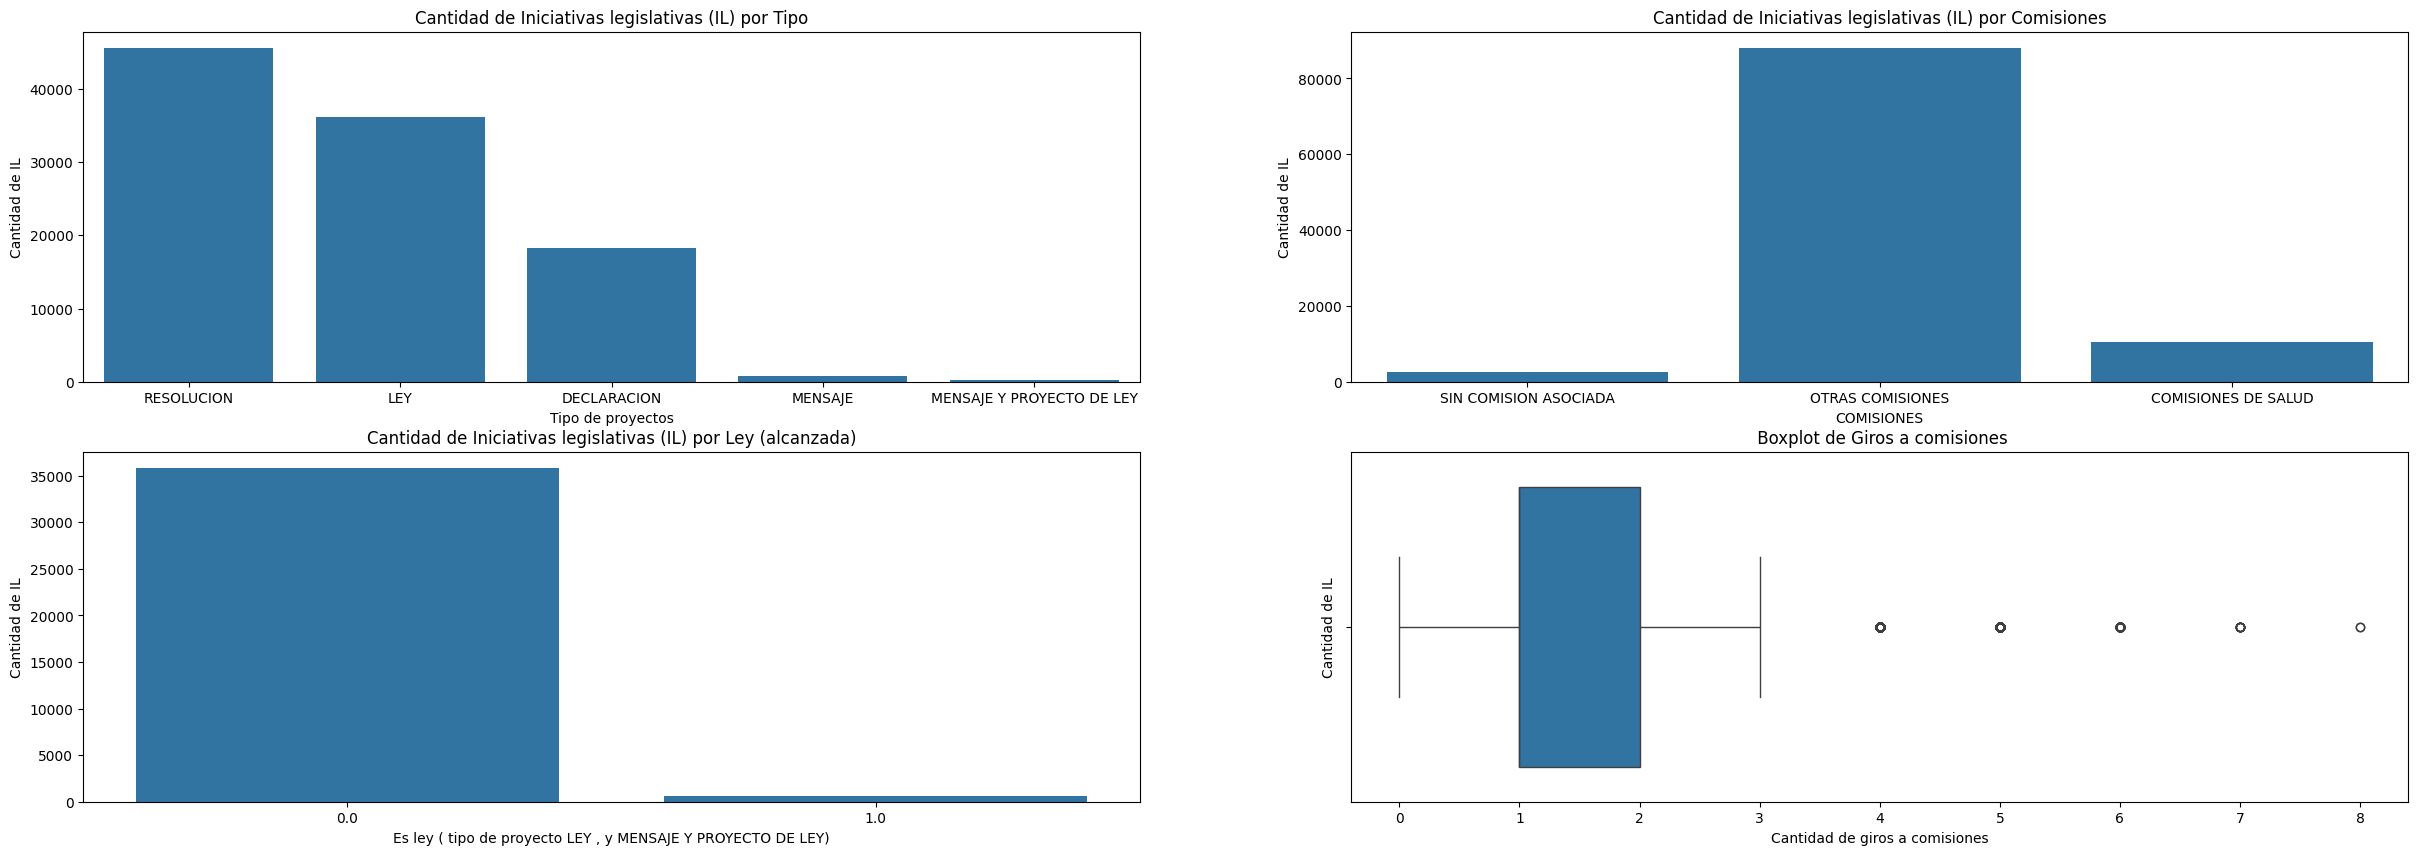

In [6]:
f, axs = plt.subplots(2, 2, figsize=(30, 10))
sns.countplot(x='tipo',  data=proyecto_df, ax = axs[0][0])
sns.countplot(x='proyecto_girado_a_comisiones_SALUD',  data=proyecto_df, ax = axs[0][1])
sns.countplot(x='es_ley',  data=proyecto_df[proyecto_df['tipo'].isin(['LEY','MENSAJE Y PROYECTO DE LEY'])], ax = axs[1][0])
sns.boxplot(data = proyecto_df, x = 'giros_a_comisiones', ax = axs[1][1] ) 
axs[0][0].set_title('Cantidad de Iniciativas legislativas (IL) por Tipo')
axs[0][0].set_ylabel("Cantidad de IL")
axs[0][0].set_xlabel("Tipo de proyectos")
axs[0][1].set_title('Cantidad de Iniciativas legislativas (IL) por Comisiones')
axs[0][1].set_xlabel("COMISIONES")
axs[0][1].set_ylabel("Cantidad de IL")
axs[1][0].set_title('Cantidad de Iniciativas legislativas (IL) por Ley (alcanzada)')
axs[1][0].set_xlabel("Es ley ( tipo de proyecto LEY , y MENSAJE Y PROYECTO DE LEY)")
axs[1][0].set_ylabel("Cantidad de IL")
axs[1][1].set_title(' Boxplot de Giros a comisiones')
axs[1][1].set_xlabel("Cantidad de giros a comisiones")
axs[1][1].set_ylabel("Cantidad de IL")


In [7]:
#  Datos útiles
# IL por año para analizar las ventana de tiemo
proyecto_df['año'] = proyecto_df['publicacion_fecha'].dt.year
#*100913 IL tal que con información de giro a comisión solo 98469 IL (98%) y con resultado de tratamiento solo 97967 IL (97%)
# Se considera todos los registros. Pero recordar que el 2024 no esta completo
ano_tipo_df = pd.pivot_table(proyecto_df, values=['proyecto_id'], index=['año','tipo','proyecto_girado_a_comisiones_SALUD','resultado'],
                       aggfunc={'proyecto_id': "count"}).reset_index()

In [10]:
ano_tipo_df.sort_values(by='proyecto_id', ascending = False)

año                       tipo proyecto_girado_a_comisiones_SALUD  \
152  2014                 RESOLUCION                   OTRAS COMISIONES   
133  2013                 RESOLUCION                   OTRAS COMISIONES   
114  2012                 RESOLUCION                   OTRAS COMISIONES   
144  2014                        LEY                   OTRAS COMISIONES   
69   2010                 RESOLUCION                   OTRAS COMISIONES   
..    ...                        ...                                ...   
45   2009                 RESOLUCION                   OTRAS COMISIONES   
34   2009                        LEY                   OTRAS COMISIONES   
30   2009                        LEY                   OTRAS COMISIONES   
319  2023  MENSAJE Y PROYECTO DE LEY                COMISIONES DE SALUD   
320  2023  MENSAJE Y PROYECTO DE LEY                   OTRAS COMISIONES   

                                     resultado  proyecto_id  
152  NO TUVO TRATAMIENTO POSTERIOR NI DICTAMEN         2612  
133  NO TUVO TRATAMIENTO POSTERIOR NI DICTAMEN         2580  
114  NO TUVO TRATAMIENTO POSTERIOR NI DICTAMEN         2531  
144  NO TUVO TRATAMIENTO POSTERIOR NI DICTAMEN         2524  
69   NO TUVO TRATAMIENTO POSTERIOR NI DICTAMEN         2427  
..                                         ...          ...  
45                               DATO FALTANTE            1  
34                                  SANCIONADO            1  
30                                    APROBADO            1  
319  NO TUVO TRATAMIENTO POSTERIOR NI DICTAMEN            1  
320                              DATO FALTANTE            1  

[341 rows x 5 columns]

Text(0.5, 0, 'Año (publicación)')

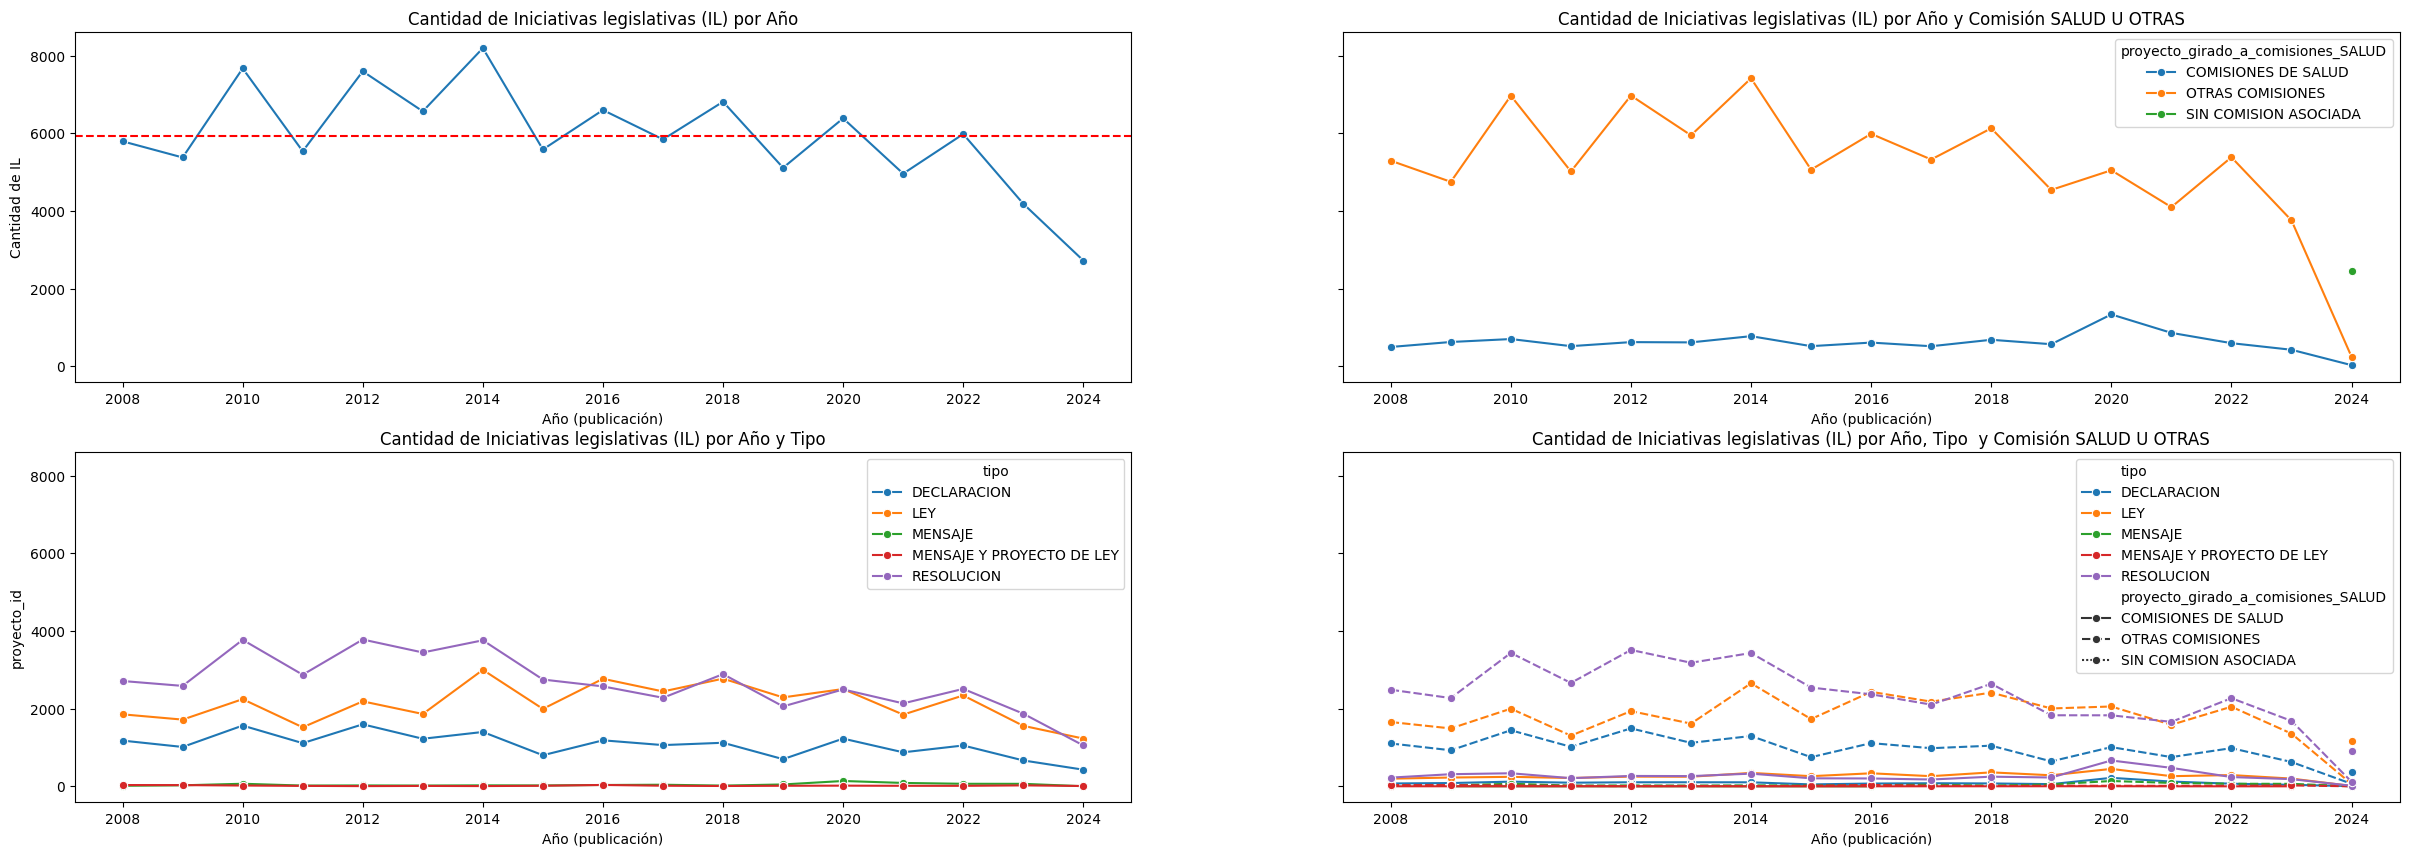

In [11]:
f, axs = plt.subplots(2, 2, figsize=(30, 10), sharey = True)
sns.lineplot(x=ano_tipo_df['año'], y=ano_tipo_df['proyecto_id'], estimator='sum', errorbar= None , linestyle='-', ax = axs[0][0], marker="o")
sns.lineplot(x=ano_tipo_df['año'], y=ano_tipo_df['proyecto_id'], estimator='sum',  hue = 'proyecto_girado_a_comisiones_SALUD', marker="o" ,data =ano_tipo_df,  errorbar= None , linestyle='-',ax = axs[0][1])
sns.lineplot(x=ano_tipo_df['año'], y=ano_tipo_df['proyecto_id'], estimator='sum',  hue = 'tipo', data =ano_tipo_df,  marker="o", errorbar= None , linestyle='-',ax = axs[1][0])
sns.lineplot(x=ano_tipo_df['año'], y=ano_tipo_df['proyecto_id'], estimator='sum',  hue = 'tipo', 
style="proyecto_girado_a_comisiones_SALUD", data =ano_tipo_df,  errorbar= None , linestyle='-',ax = axs[1][1], marker="o")

axs[0][0].axhline(y=ano_tipo_df.groupby('año')['proyecto_id'].sum().mean(), color='r', linestyle='--')
axs[0][0].set_title('Cantidad de Iniciativas legislativas (IL) por Año')
axs[0][0].set_xlabel("Año (publicación)")
axs[0][0].set_ylabel("Cantidad de IL")
axs[0][1].set_title('Cantidad de Iniciativas legislativas (IL) por Año y Comisión SALUD U OTRAS')
axs[0][1].set_xlabel("Año (publicación)")
axs[1][0].set_title('Cantidad de Iniciativas legislativas (IL) por Año y Tipo')
axs[1][0].set_xlabel("Año (publicación)")
axs[1][1].set_title('Cantidad de Iniciativas legislativas (IL) por Año, Tipo  y Comisión SALUD U OTRAS')
axs[1][1].set_xlabel("Año (publicación)")



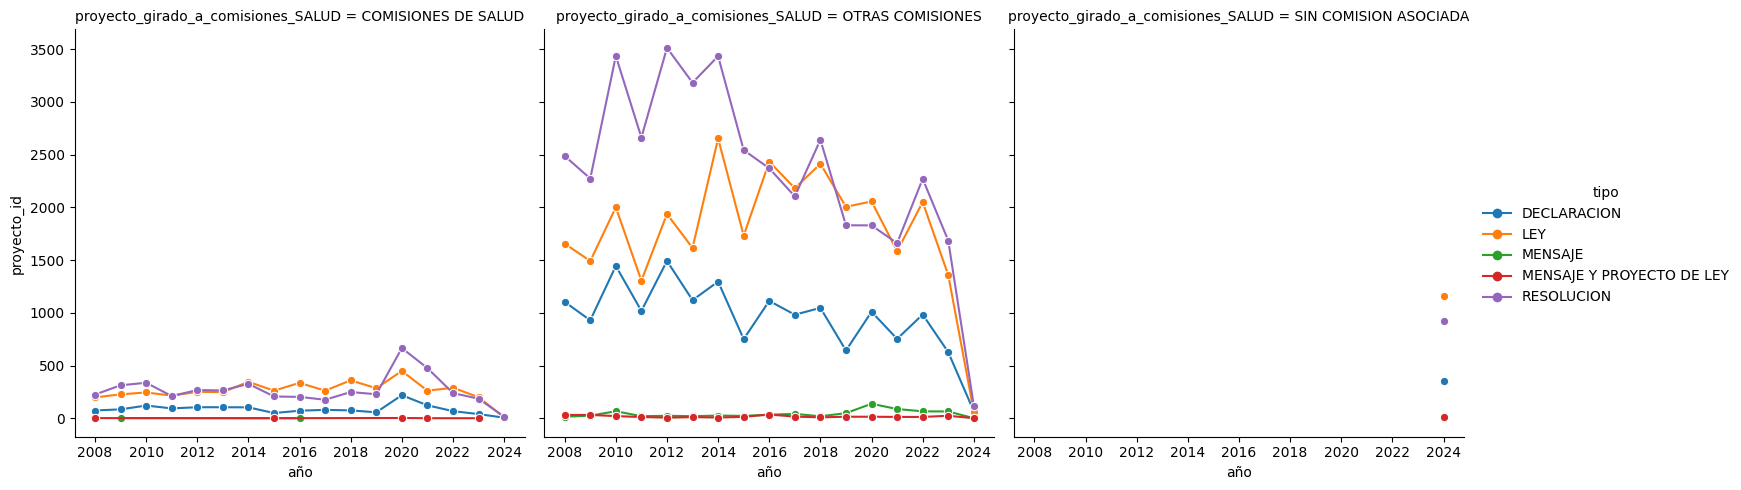

In [12]:
#100913 IL tal que con información de giro a comisión solo 98469 IL (98%) y con resultado de tratamiento solo 97967 IL (97%)
#ano_tipo_df
sns.relplot(
    data=ano_tipo_df, x="año", y="proyecto_id", col="proyecto_girado_a_comisiones_SALUD",
    hue="tipo",  kind="line", estimator = 'sum', errorbar= None, marker='o',
)

Text(0, 0.5, 'Cantidad de IL')

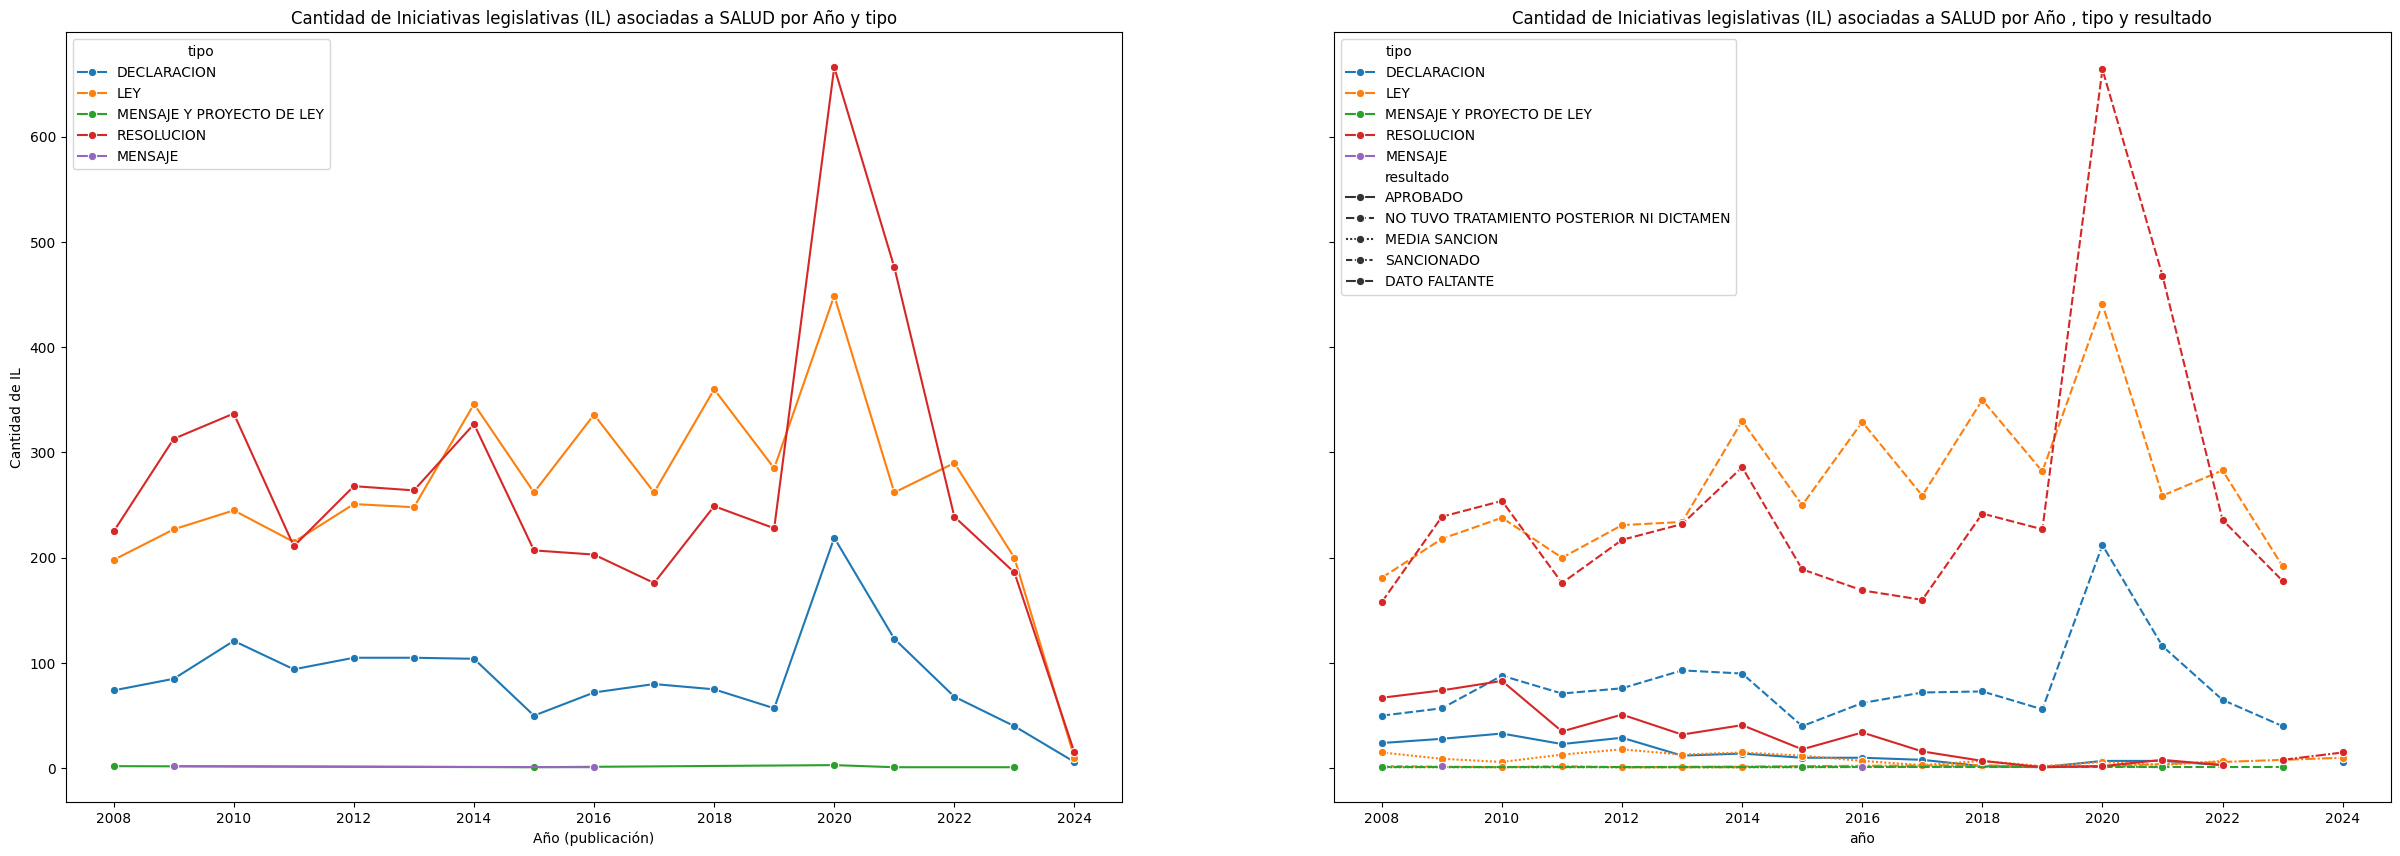

In [13]:
f, axs = plt.subplots(1, 2, figsize=(30, 10), sharey = True)
sns.lineplot(x=ano_tipo_df['año'], y=ano_tipo_df['proyecto_id'], estimator='sum',  hue = 'tipo', 
data =ano_tipo_df[ano_tipo_df['proyecto_girado_a_comisiones_SALUD'] == 'COMISIONES DE SALUD'],  errorbar= None , marker ='o',
             linestyle='-', ax = axs[0])
axs[0].set_title('Cantidad de Iniciativas legislativas (IL) asociadas a SALUD por Año y tipo')
axs[0].set_xlabel("Año (publicación)")
axs[0].set_ylabel("Cantidad de IL")

sns.lineplot(x=ano_tipo_df['año'], y=ano_tipo_df['proyecto_id'], estimator='sum',  hue = 'tipo',  marker ='o',
style="resultado", data =ano_tipo_df[ano_tipo_df['proyecto_girado_a_comisiones_SALUD'] == 'COMISIONES DE SALUD'],  errorbar= None, 
             linestyle='-', ax = axs[1])
axs[1].set_title('Cantidad de Iniciativas legislativas (IL) asociadas a SALUD por Año , tipo y resultado')
axs[0].set_xlabel("Año (publicación)")
axs[0].set_ylabel("Cantidad de IL")

**Giro a comisiones - Diccionario de datos**

* proyecto_id: identificador único de registro.
* comision: Nombre de comisión que se mantiene de fuente original
* Orden: Orden de giro a la comisión asociada
* comision_nombre_norm:  Nombre de comisión Normalizado


In [14]:
# Pickle de giro a comisión normalizado
# Después de eliminar duplicados: 392089, 4
with open('girocomisiones1.9_20241031.pkl', 'rb') as file:
    girocom_df = pickle.load(file)

In [15]:
girocom_df.head()

proyecto_id                   comision  orden      comision_nombre_norm
0  HCDN000000               SOBRE TABLAS      1              SOBRE TABLAS
1  HCDN001090            OBRAS PUBLICAS       1            OBRAS PUBLICAS
2  HCDN001090    PRESUPUESTO Y HACIENDA       2    PRESUPUESTO Y HACIENDA
3  HCDN001091                   TURISMO       1                   TURISMO
4  HCDN001092  ASUNTOS CONSTITUCIONALES       1  ASUNTOS CONSTITUCIONALES

In [16]:
girocom_df.describe(include='all').T

count  unique                     top   freq  \
proyecto_id             392089  259585              HCDN061700     13   
comision                392089     195  PRESUPUESTO Y HACIENDA  45770   
orden                 392089.0     NaN                     NaN    NaN   
comision_nombre_norm    392089     146  PRESUPUESTO Y HACIENDA  46529   

                          mean       std  min  25%  50%  75%   max  
proyecto_id                NaN       NaN  NaN  NaN  NaN  NaN   NaN  
comision                   NaN       NaN  NaN  NaN  NaN  NaN   NaN  
orden                 1.481539  0.805361  1.0  1.0  1.0  2.0  13.0  
comision_nombre_norm       NaN       NaN  NaN  NaN  NaN  NaN   NaN

**com_fuzz_comisiones_df - Diccionario de datos**

Ver notebook: 00_ANEXO_COMISION

* comision_nombre_norm:  Nombre de comisión Normalizado
* tipo de comision: Tipo de comisión. P, E o sin dato

In [17]:
# Información de las comisiones
with open('com_fuzz_comisiones_df_20241031.pkl', 'rb') as file:
    fuzz_comisiones_df = pickle.load(file)
display(fuzz_comisiones_df.head(5))
fuzz_comisiones_df.describe(include='all').T


comision_nombre_norm  \
0                              A LA PRESIDENCIA   
1                            A SUS ANTECEDENTES   
2                 ACCION SOCIAL Y SALUD PUBLICA   
3                                      ACUERDOS   
4  ADMINISTRADORA DE LA BIBLIOTECA DEL CONGRESO   

                                                     fuzz_match  fuzz_score  \
0                                           LABOR PARLAMENTARIA        51.0   
1                                              A LA PRESIDENCIA        41.0   
2                             ASISTENCIA SOCIAL Y SALUD PUBLICA        84.0   
3                                                      COMERCIO        50.0   
4  ADMINISTRADORA FONDO DE COMPENSACION RESARCITORIA TEMPORARIA        50.0   

   categ_louvain_LevenshteinMayor_60  categ_louvain_dinamica  degree  \
0                               -1.0                     1.0     2.0   
1                               -1.0                     7.0     1.0   
2                                9.0                     7.0    83.0   
3                               -1.0                     1.0     3.0   
4                               -1.0                     0.0     4.0   

   centrality  eigenvector  pagerank  betweenness  ...  comision_grupo  \
0    0.013793     0.003370  0.001413     0.000000  ...             NaN   
1    0.006897     0.002087  0.001209     0.000000  ...             NaN   
2    0.572414     0.137609  0.012957     0.006699  ...              CD   
3    0.020690     0.007012  0.001537     0.000000  ...             NaN   
4    0.027586     0.007587  0.001674     0.000002  ...             NaN   

   periodo_inicio periodo_finalizacion fecha_inicio fecha_finalizacion  \
0             0.0                  0.0          NaN                NaN   
1             0.0                  0.0          NaN                NaN   
2           116.0                999.0   01/03/1998                  0   
3             0.0                  0.0          NaN                NaN   
4             0.0                  0.0          NaN                NaN   

   tipo de comision  categ_OrtizDeRosa_Shugart     _merge cant_proy_CP  %_CP  
0          sin dato                        NaN  left_only        102.0  0.04  
1          sin dato                        NaN  left_only         18.0  0.01  
2                 P                 NACIONALES       both      16814.0  6.48  
3          sin dato                        NaN  left_only       3275.0  1.26  
4          sin dato                        NaN  left_only          4.0  0.00  

[5 rows x 24 columns]

count unique  \
comision_nombre_norm                 153    153   
fuzz_match                           153     95   
fuzz_score                         153.0    NaN   
categ_louvain_LevenshteinMayor_60  153.0    NaN   
categ_louvain_dinamica             146.0    NaN   
degree                             153.0    NaN   
centrality                         153.0    NaN   
eigenvector                        153.0    NaN   
pagerank                           153.0    NaN   
betweenness                        153.0    NaN   
categ_agg_ward_k7                  146.0    NaN   
categ_agg_ward_k4                  146.0    NaN   
id                                   153     56   
comision_nombre                       55     55   
comision_grupo                        55      1   
periodo_inicio                     153.0    NaN   
periodo_finalizacion               153.0    NaN   
fecha_inicio                          55     11   
fecha_finalizacion                    55      2   
tipo de comision                     153      3   
categ_OrtizDeRosa_Shugart             55      4   
_merge                               153      3   
cant_proy_CP                       153.0    NaN   
%_CP                               153.0    NaN   

                                                             top freq  \
comision_nombre_norm                            A LA PRESIDENCIA    1   
fuzz_match                                              sin dato    7   
fuzz_score                                                   NaN  NaN   
categ_louvain_LevenshteinMayor_60                            NaN  NaN   
categ_louvain_dinamica                                       NaN  NaN   
degree                                                       NaN  NaN   
centrality                                                   NaN  NaN   
eigenvector                                                  NaN  NaN   
pagerank                                                     NaN  NaN   
betweenness                                                  NaN  NaN   
categ_agg_ward_k7                                            NaN  NaN   
categ_agg_ward_k4                                            NaN  NaN   
id                                                      sin dato   98   
comision_nombre                    ACCION SOCIAL Y SALUD PUBLICA    1   
comision_grupo                                                CD   55   
periodo_inicio                                               NaN  NaN   
periodo_finalizacion                                         NaN  NaN   
fecha_inicio                                          01/03/1998   43   
fecha_finalizacion                                             0   54   
tipo de comision                                        sin dato   98   
categ_OrtizDeRosa_Shugart                        SIN CATEGORIZAR   30   
_merge                                                 left_only   98   
cant_proy_CP                                                 NaN  NaN   
%_CP                                                         NaN  NaN   

                                          mean         std   min       25%  \
comision_nombre_norm                       NaN         NaN   NaN       NaN   
fuzz_match                                 NaN         NaN   NaN       NaN   
fuzz_score                           63.931507   12.056696  40.0      55.0   
categ_louvain_LevenshteinMayor_60     5.248366    9.038864  -1.0      -1.0   
categ_louvain_dinamica                 3.10274    2.878528   0.0       0.0   
degree                               36.928105   31.065107   0.0       4.0   
centrality                            0.254677    0.214242   0.0  0.027586   
eigenvector                           0.063341    0.050403   0.0  0.007587   
pagerank                              0.006536    0.004861   0.0  0.001725   
betweenness                           0.004841    0.015471   0.0       0.0   
categ_agg_ward_k7                     2.034247    2.015165   0.0       0.0 

## 2 -Limpieza y preparación de los datos 

In [18]:
# Me interesa la relación proyecto y comisión. No la cantidad de veces girado ni orden a dicha comisión 
giro_com_nombre_df = girocom_df[['proyecto_id','comision','comision_nombre_norm']].copy() 
print("Antes de eliminar duplicados (relación proyecto y comisión):", giro_com_nombre_df.shape)
giro_com_nombre_df.drop_duplicates(keep='last', inplace=True)
print("Despues de eliminar duplicados (relación proyecto y comisión):", giro_com_nombre_df.shape)

Antes de eliminar duplicados (relación proyecto y comisión): (392089, 3)
Despues de eliminar duplicados (relación proyecto y comisión): (388202, 3)


In [19]:
# Para identificar las relaciones
giro_com_nombre_df.head(2)

proyecto_id         comision comision_nombre_norm
0  HCDN000000     SOBRE TABLAS         SOBRE TABLAS
1  HCDN001090  OBRAS PUBLICAS        OBRAS PUBLICAS

In [20]:
print('cantidad de comisiones giro_com_nombre_df:', len(giro_com_nombre_df['comision_nombre_norm'].unique()))
print('cantidad de proyectos unicos giro_com_nombre_df:', len(giro_com_nombre_df['proyecto_id'].unique()))

cantidad de comisiones giro_com_nombre_df: 146
cantidad de proyectos unicos giro_com_nombre_df: 259585


In [21]:
# Integramos proyecto y giro ... por cada proyecto la comisión asociada
memoria_df  = pd.merge(proyecto_df, giro_com_nombre_df, how = 'inner',left_on = 'proyecto_id', right_on = "proyecto_id")
memoria_df  = pd.merge(memoria_df, fuzz_comisiones_df, how = 'left',left_on = 'comision_nombre_norm', right_on = "comision_nombre_norm")
memoria_df.head()

id_x proyecto_id  \
0  2444  HCDN272754   
1  2444  HCDN272754   
2  2445  HCDN272752   
3  2446  HCDN272750   
4  2446  HCDN272750   

                                                                                                                                                                                                         titulo  \
0                                                                                                          SOLICITAR AL PODER EJECUTIVO DISPONGA SOSTENER EL PLENO FUNCIONAMIENTO DE TELAM SOCIEDAD DEL ESTADO.   
1                                                                                                          SOLICITAR AL PODER EJECUTIVO DISPONGA SOSTENER EL PLENO FUNCIONAMIENTO DE TELAM SOCIEDAD DEL ESTADO.   
2                                                         SOLICITAR AL PODER EJECUTIVO DISPONGA ENVIAR EL NUEVO PROYECTO DE LA LEY DE PRESUPUESTO GENERAL DE LA ADMINISTRACION NACIONAL PARA EL EJERCICIO 2024.   
3  REGIMEN LEGAL DE LOS DECRETOS DE NECESIDAD Y URGENCIA, DE DELEGACION LEGISLATIVA Y DE PROMULGACION PARCIAL DE LEYES - LEY 26122 -. MODIFICACIONES, SOBRE FUNCIONAMIENTO DE LA COMISION BICAMERAL PERMANENTE.   
4  REGIMEN LEGAL DE LOS DECRETOS DE NECESIDAD Y URGENCIA, DE DELEGACION LEGISLATIVA Y DE PROMULGACION PARCIAL DE LEYES - LEY 26122 -. MODIFICACIONES, SOBRE FUNCIONAMIENTO DE LA COMISION BICAMERAL PERMANENTE.   

  publicacion_fecha publicacion_id camara_origen exp_diputados exp_senado  \
0        2024-02-29   HCDN141TP249     Diputados   5410-D-2023        NaN   
1        2024-02-29   HCDN141TP249     Diputados   5410-D-2023        NaN   
2        2024-02-29   HCDN141TP249     Diputados   5409-D-2023        NaN   
3        2024-02-29   HCDN141TP249     Diputados   5408-D-2023        NaN   
4        2024-02-29   HCDN141TP249     Diputados   5408-D-2023        NaN   

         tipo  giros_a_comisiones  ... comision_grupo periodo_inicio  \
0  RESOLUCION                 2.0  ...            NaN            0.0   
1  RESOLUCION                 2.0  ...             CD          116.0   
2  RESOLUCION                 1.0  ...             CD          116.0   
3         LEY                 2.0  ...             CD          116.0   
4         LEY                 2.0  ...             CD          116.0   

  periodo_finalizacion fecha_inicio  fecha_finalizacion tipo de comision  \
0                  0.0          NaN                 NaN         sin dato   
1                999.0   01/03/1998                   0                P   
2                999.0   01/03/1998                   0                P   
3                999.0   01/03/1998                   0                P   
4                999.0   01/03/1998                   0                P   

  categ_OrtizDeRosa_Shugart     _merge  cant_proy_CP   %_CP  
0                       NaN  left_only        6521.0   2.51  
1           SIN CATEGORIZAR       both       45487.0  17.52  
2           SIN CATEGORIZAR       both       45487.0  17.52  
3           SIN CATEGORIZAR       both        3577.0   1.38  
4           SIN CATEGORIZAR       both       13156.0   5.07  

[5 rows x 45 columns]

In [22]:
#  150615  proyectos con detalle de giro
memoria_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150615 entries, 0 to 150614
Data columns (total 45 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   id_x                                150615 non-null  int64         
 1   proyecto_id                         150615 non-null  object        
 2   titulo                              150615 non-null  object        
 3   publicacion_fecha                   150615 non-null  datetime64[ns]
 4   publicacion_id                      149905 non-null  object        
 5   camara_origen                       150615 non-null  object        
 6   exp_diputados                       150615 non-null  object        
 7   exp_senado                          3781 non-null    object        
 8   tipo                                150615 non-null  object        
 9   giros_a_comisiones                  150615 non-null  float64       
 10  proyecto

## 3- SNA por ventana de tiempo, tipo, salud

In [23]:
# Genero gráfo base, tener en cuenta la lista de variable peso
def graph_get(df, titulo, x_from='comision_nombre_norm', x_to="fuzz_match", pesos_l = ['fuzz_score']):
    try:
        if(len(pesos_l)>0):
            G = nx.from_pandas_edgelist(df, x_from, x_to, pesos_l)
        else: 
            G = nx.from_pandas_edgelist(df, x_from, x_to)
            
        G.remove_edges_from(nx.selfloop_edges(G))
        print(f'Número de nodos en el gráfo: {len(G.nodes())}')
        print(f'Número de aristas en el gráfo: {len(G.edges())}')
        #plt.figure(figsize=(12, 10))
        #nx.draw(G, with_labels=False, node_color='skyblue', node_size=10, edge_color='gray')
        #plt.title(titulo)
        #plt.show()
        
    except Except as e:
        print("Controlar los datos")
        print(e)
    return G

# Para chequear repetidos, retorna indice para eliminar fila
def get_index(df, p_id = 'proyecto_id', x = 'comision_nombre_norm_x', y = 'comision_nombre_norm_y'):
    df = df.sort_values(by=p_id)
    idx_list = []
    indice_check = df.index.values
    length = len(indice_check)
    i = 0
    while(i < length-1):
        flag = True
        j = i + 1
        while flag:
            if (df.iloc[i][p_id] == df.iloc[j][p_id]):
                if  ((df.iloc[i][x] == df.iloc[j][y]) & (df.iloc[i][y] == df.iloc[j][x]) ):
                    idx_list.append(int(indice_check[i]))
                    flag = False
                else:
                    j =j+1
            else:
                flag = False
        i = i +1
    return idx_list


# # Para crear las lista de aristas del grafo

def get_clean_edge(m_filter, proy_id = 'proyecto_id', com_id = 'comision_nombre_norm'):
    # df determinado por filtro inicial
    print('cantidad de comisiones m_filter:', len(m_filter[com_id].unique()))
    print('cantidad de proyectos únicos m_filter:', len(m_filter[proy_id].unique()))
    edge_filter_df  = pd.merge(m_filter, m_filter, how = 'left',left_on = proy_id , right_on = proy_id)
    edge_filter_df.columns = [proy_id, 'x1','x2']
    display(edge_filter_df.head())
    print('Cantidad de aristas totales SIN CONTROL:',edge_filter_df.shape)
   
    #edge_filter_df = edge_filter_df[edge_filter_df['comision_nombre_norm_x'] != edge_filter_df['comision_nombre_norm_y']]
    #print('edge_filter_df CON control de que se llame a si mismo:',edge_filter_df.shape)
    # indice
    print('#########################################################') 
    # Se elimina la arista iguales (pares de nodos iguales), no me interesa la direcion en los nodos
    idx2_list = get_index(edge_filter_df,  proy_id, 'x1', 'x2')
   
    #proy_id = list(edge_filter_df.loc[edge_filter_df.index.isin(idx2_list)]['proyecto_id'])
    #edge_filter_df[edge_filter_df['proyecto_id'].isin(proy_id)]
    edge_filter_df = edge_filter_df.loc[~ (edge_filter_df.index.isin(idx2_list))]
    print('Cantidad de aristas totales CON CONTROL DE ORDEN por x1---x2 = x2---x1 :',edge_filter_df.shape)
    print('cantidad de comisiones únicas:', len(set(list(edge_filter_df['x1'].values)).union(set(list(edge_filter_df['x2'].values)))))
    print('cantidad de proyectos únicos:', len(edge_filter_df['proyecto_id'].unique()))
    return edge_filter_df

In [24]:
# Propiedades del grafo
def get_graph_property(G):
    den = nx.density(G)
    print('Densidad del grafo',den)
    return den

# Obtener los grados de los nodos
def get_grados(G):
    degree =   G.degree(weight='peso')
    degree_sequence = sorted( (d for n, d in degree), reverse=True)
    #print(degree_sequence)
    fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(10, 2))
    axis[0].plot(degree_sequence, 'b--', marker="o")
    axis[0].set_title("Rank de grados")
    axis[0].set_ylabel("Grados")
    axis[0].set_xlabel("Rank")
    
    #*np.unique(degree_sequence, return_counts=True)
    axis[1].hist(degree_sequence)
    axis[1].set_title("Histograma de grados")
    axis[1].set_xlabel("Grados")
    axis[1].set_ylabel("# Nodos")
    return degree

# Determinar las metricas, crear dataframe y asignar peos a grafica
def get_metricas_nodos(G, add = True):
    # Métricas de posición en la red
    # ======================================================================================
    d = nx.degree(G, weight='peso')
    degree      = pd.Series(dict(d), name='degree', dtype="float16")
    c = nx.degree_centrality(G)
    centrality  = pd.Series(dict(c), name='centrality')
    v = nx.eigenvector_centrality(G, weight='peso')
    eigenvector =  pd.Series( v, name='eigenvector')
    p = nx.pagerank(G, weight='peso')
    pagerank    =  pd.Series(p, name='pagerank')
    b = nx.betweenness_centrality(G, weight='peso')
    betweenness =  pd.Series(v, name='betweenness')
    centralidad = pd.concat([degree,centrality, eigenvector, pagerank, betweenness], axis=1)
    centralidad.index.name = 'node'

    if add: 
        nx.set_node_attributes(G, dict(d) , 'grado') 
        nx.set_node_attributes(G, c , 'centralidad')  
        nx.set_node_attributes(G, v , 'autovector')  
        nx.set_node_attributes(G, p , 'pagerank')  
        nx.set_node_attributes(G, b , 'intermediación')  
    
    print("********** Métricas de Centralidad de la Red **********")
    display(centralidad.describe(include='all').T)
    # Top 6 nodos para cada métrica
    # ======================================================================================
    for col in centralidad.columns:
        top_nodos = centralidad[col].sort_values(ascending=False).head(6).index.to_list()
        print(f"Nodos con mayor {col}: {top_nodos}")
    return centralidad
    

In [26]:
# Devuelve información del grafo, grafo con atributos y dataframe de centralidad
def get_dict_grafo(edges_df, flag_save=True):

    all_dict = {}
    # Preparamos peso de aristas por cantidad de proyectos
    cant_proyecto = len(edges_df.proyecto_id.unique()) # 36877 proyectos id
    edge_weight_df = edges_df[['x1','x2']].value_counts().reset_index()
    edge_weight_df['peso'] = round((edge_weight_df['count']/ cant_proyecto)*100,4)
     
    # Creamos gráfo
    print("** Creación de grafo desde :", edge_weight_df.shape)
    G = graph_get(edge_weight_df,"Red de comisiones legislativas", 'x1','x2' ,['peso'] )
    all_dict['grafo'] = G
    
    # Densidad del gráfo
    density = get_graph_property(G)
    d = get_grados(G)
    #nx.set_node_attributes(G, dict(d), 'grado') 
    
    centralidad_df = get_metricas_nodos(G)
    if flag_save:
        all_dict['centralidad'] = centralidad_df
    
    return all_dict

    

In [27]:
# Integración 85 comisiones de 146 identificadas en fuente de datos en Giro de comisiones
print('cantidad de comisiones memoria_df:', len(memoria_df['comision_nombre_norm'].unique()))
print('cantidad de proyectos unicos memoria_df:', len(memoria_df['proyecto_id'].unique()))

cantidad de comisiones memoria_df: 85
cantidad de proyectos unicos memoria_df: 98469


**Filtramos para el periodo 2010 - 2023**

In [28]:
# Preparamos Edges - BASE - VENTANA DE TIEMPO 2010-2023
edges_1023_df = get_clean_edge(memoria_df.loc[ (memoria_df['año']>2009) & (memoria_df['año']<2024) , ('proyecto_id','comision_nombre_norm')], proy_id = 'proyecto_id', com_id = 'comision_nombre_norm')

cantidad de comisiones m_filter: 85
cantidad de proyectos únicos m_filter: 87019


proyecto_id                   x1                   x2
0  HCDN272363  LEGISLACION GENERAL  LEGISLACION GENERAL
1  HCDN272363  LEGISLACION GENERAL            EDUCACION
2  HCDN272363            EDUCACION  LEGISLACION GENERAL
3  HCDN272363            EDUCACION            EDUCACION
4  HCDN272366   SEGURIDAD INTERIOR   SEGURIDAD INTERIOR

Cantidad de aristas totales SIN CONTROL: (260295, 3)
#########################################################
Cantidad de aristas totales CON CONTROL DE ORDEN por x1---x2 = x2---x1 : (197193, 3)
cantidad de comisiones únicas: 85
cantidad de proyectos únicos: 87019


### 1- Grafo IL entre 2010 a 2023

** Creación de grafo desde : (2234, 4)
Número de nodos en el gráfo: 85
Número de aristas en el gráfo: 1255
Densidad del grafo 0.35154061624649857
********** Métricas de Centralidad de la Red **********


count      mean       std           min       25%       50%  \
degree        85.0  0.804199  1.890625  0.000000e+00  0.017807  0.258789   
centrality    85.0  0.351541  0.234004  0.000000e+00  0.166667  0.380952   
eigenvector   85.0  0.055417  0.093793  7.242463e-09  0.000804  0.019413   
pagerank      85.0  0.011765  0.022472  1.918159e-03  0.002453  0.005597   
betweenness   85.0  0.055417  0.093793  7.242463e-09  0.000804  0.019413   

                  75%        max  
degree       1.022461  15.898438  
centrality   0.547619   0.845238  
eigenvector  0.066421   0.629636  
pagerank     0.013822   0.191953  
betweenness  0.066421   0.629636

Nodos con mayor degree: ['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'ACCION SOCIAL Y SALUD PUBLICA', 'ASUNTOS CONSTITUCIONALES', 'LEGISLACION DEL TRABAJO', 'JUSTICIA']
Nodos con mayor centrality: ['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'ACCION SOCIAL Y SALUD PUBLICA', 'LEGISLACION DEL TRABAJO', 'ASUNTOS CONSTITUCIONALES', 'PETICIONES PODERES Y REGLAMENTO']
Nodos con mayor eigenvector: ['PRESUPUESTO Y HACIENDA', 'ACCION SOCIAL Y SALUD PUBLICA', 'LEGISLACION GENERAL', 'ASUNTOS CONSTITUCIONALES', 'LEGISLACION DEL TRABAJO', 'EDUCACION']
Nodos con mayor pagerank: ['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'ACCION SOCIAL Y SALUD PUBLICA', 'ASUNTOS CONSTITUCIONALES', 'LEGISLACION DEL TRABAJO', 'LEGISLACION PENAL']
Nodos con mayor betweenness: ['PRESUPUESTO Y HACIENDA', 'ACCION SOCIAL Y SALUD PUBLICA', 'LEGISLACION GENERAL', 'ASUNTOS CONSTITUCIONALES', 'LEGISLACION DEL TRABAJO', 'EDUCACION']


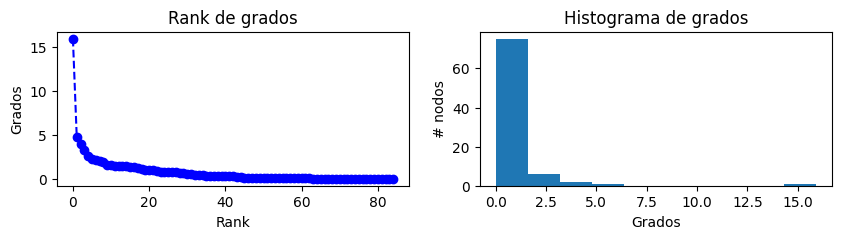

In [29]:
# Grafos
grafo_1023_dict = get_dict_grafo(edges_1023_df)

In [30]:
# https://pyvis.readthedocs.io/en/latest/tutorial.html
"""
nt = Network(notebook = False, #cdn_resources = "remote",
                bgcolor = "#222222",
                font_color = "white",
                height = "750px",
                width = "100%",
                select_menu = True,
                filter_menu = True,
)
nt.from_nx(grafo_1023_dict['grafo'])
nt.show_buttons(filter_=['physics'])
nt.show('nx.html',notebook = False)
"""


'\nnt = Network(notebook = False, #cdn_resources = "remote",\n                bgcolor = "#222222",\n                font_color = "white",\n                height = "750px",\n                width = "100%",\n                select_menu = True,\n                filter_menu = True,\n)\nnt.from_nx(grafo_1023_dict[\'grafo\'])\nnt.show_buttons(filter_=[\'physics\'])\nnt.show(\'nx.html\',notebook = False)\n'

In [31]:
# Devuelve datafram de evolución en el tiempo
def get_graph_time(rango_tiempo, filtro, memoriadf, edgesdf):
    años_g_df = []
    for ano in range(rango_tiempo[0],rango_tiempo[1]):
        #print('\n** Año: ',ano)
        a_list = memoriadf.loc[memoriadf['año'] == ano,'proyecto_id'].unique()
        temp_df = edgesdf[(edgesdf['proyecto_id'].isin(a_list))]
        G = nx.from_pandas_edgelist(temp_df, 'x1', 'x2')
        G.remove_edges_from(nx.selfloop_edges(G))
        n = len(G.nodes())
        a = len(G.edges())
        #print(f'Número de nodos en el gráfo: {n}')
        #print(f'Número de aristas en el gráfo: {a}')
        
        den = nx.density(G)
        d = nx.degree(G, weight='peso')
        nd = [d for n, d in d]
        mean_ = round(np.mean(nd),4)
        min_ = min(nd)
        max_ = max(nd)
        años_g_df.append((ano,n,a,den,min_,max_,mean_))
    
    df = pd.DataFrame(años_g_df, columns=['año', '# nodo', '# arista', 'densidad','min grado', 'max grado', 'mean grado'])
    df['filtro'] = filtro
    return df


Información anual sin filtro

In [32]:
df = get_graph_time( [2010,2024], 'Sin filtro', memoria_df, edges_1023_df)
df

año  # nodo  # arista  densidad  min grado  max grado  mean grado  \
0   2010      66       566  0.263869          0         47     17.1515   
1   2011      65       541  0.260096          0         53     16.6462   
2   2012      69       574  0.244672          0         55     16.6377   
3   2013      64       514  0.254960          0         51     16.0625   
4   2014      68       645  0.283143          0         58     18.9706   
5   2015      64       487  0.241567          0         55     15.2188   
6   2016      68       590  0.258999          0         59     17.3529   
7   2017      63       455  0.232975          0         50     14.4444   
8   2018      65       521  0.250481          0         50     16.0308   
9   2019      67       438  0.198100          0         52     13.0746   
10  2020      64       480  0.238095          0         53     15.0000   
11  2021      60       452  0.255367          0         50     15.0667   
12  2022      62       529  0.279746          0         51     17.0645   
13  2023      53       430  0.312046          0         44     16.2264   

        filtro  
0   Sin filtro  
1   Sin filtro  
2   Sin filtro  
3   Sin filtro  
4   Sin filtro  
5   Sin filtro  
6   Sin filtro  
7   Sin filtro  
8   Sin filtro  
9   Sin filtro  
10  Sin filtro  
11  Sin filtro  
12  Sin filtro  
13  Sin filtro

In [33]:
# grafo de tiempo
def get_plot_graph_time(df):
    f, axs = plt.subplots(2, 2, figsize=(30, 10), sharex = True)
    sns.lineplot(x=df['año'], y=df['# nodo'], estimator='sum', errorbar= None , linestyle='-', ax = axs[0][0], marker='o')
    sns.lineplot(x=df['año'], y=df['# arista'], estimator='sum', errorbar= None , linestyle='-', ax = axs[0][1], marker='o')
    sns.lineplot(x=df['año'], y=df['densidad'], estimator='sum', errorbar= None , linestyle='-', ax = axs[1][0], marker='o')
    sns.lineplot(x=df['año'], y=df['mean grado'], estimator='sum', errorbar= None , linestyle='-', ax = axs[1][1], marker='o')
    
    axs[0][0].set_title('Comisiones (nodo) por Año')
    axs[0][0].set_xlabel("Año (publicación)")
    axs[0][0].set_ylabel("# nodo")
    axs[0][0].axhline(y=df['# nodo'].mean(), color='r', linestyle='--')
    axs[0][1].set_title('Relación de comisión por Año')
    axs[0][1].set_xlabel("Año (publicación)")
    axs[0][1].set_ylabel("# arista")
    axs[0][1].axhline(y=df['# arista'].mean(), color='r', linestyle='--')
    axs[1][0].set_title('Densidad de red por Año ')
    axs[1][0].set_xlabel("Año (publicación)")
    axs[1][0].set_ylabel("densidad")
    axs[1][0].axhline(y=df['densidad'].mean(), color='r', linestyle='--')
    axs[1][1].set_title('Media de grado de red por Año')
    axs[1][1].set_xlabel("Año (publicación)")
    axs[1][1].set_ylabel("Mean de grado")
    axs[1][1].axhline(y=df['mean grado'].mean(), color='r', linestyle='--')
    axs[1][1].set_xlim(2009, 2024) 

In [35]:
df.describe().T

count         mean        std        min          25%  \
año          14.0  2016.500000   4.183300  2010.0000  2013.250000   
# nodo       14.0    64.142857   4.054573    53.0000    63.250000   
# arista     14.0   515.857143  63.389950   430.0000   461.250000   
densidad     14.0     0.255294   0.026449     0.1981     0.242344   
min grado    14.0     0.000000   0.000000     0.0000     0.000000   
max grado    14.0    52.000000   4.000000    44.0000    50.000000   
mean grado   14.0    16.067686   1.451506    13.0746    15.104725   

                    50%          75%          max  
año         2016.500000  2019.750000  2023.000000  
# nodo        64.500000    66.750000    69.000000  
# arista     517.500000   559.750000   645.000000  
densidad       0.255164     0.262926     0.312046  
min grado      0.000000     0.000000     0.000000  
max grado     51.500000    54.500000    59.000000  
mean grado    16.144450    16.959925    18.970600

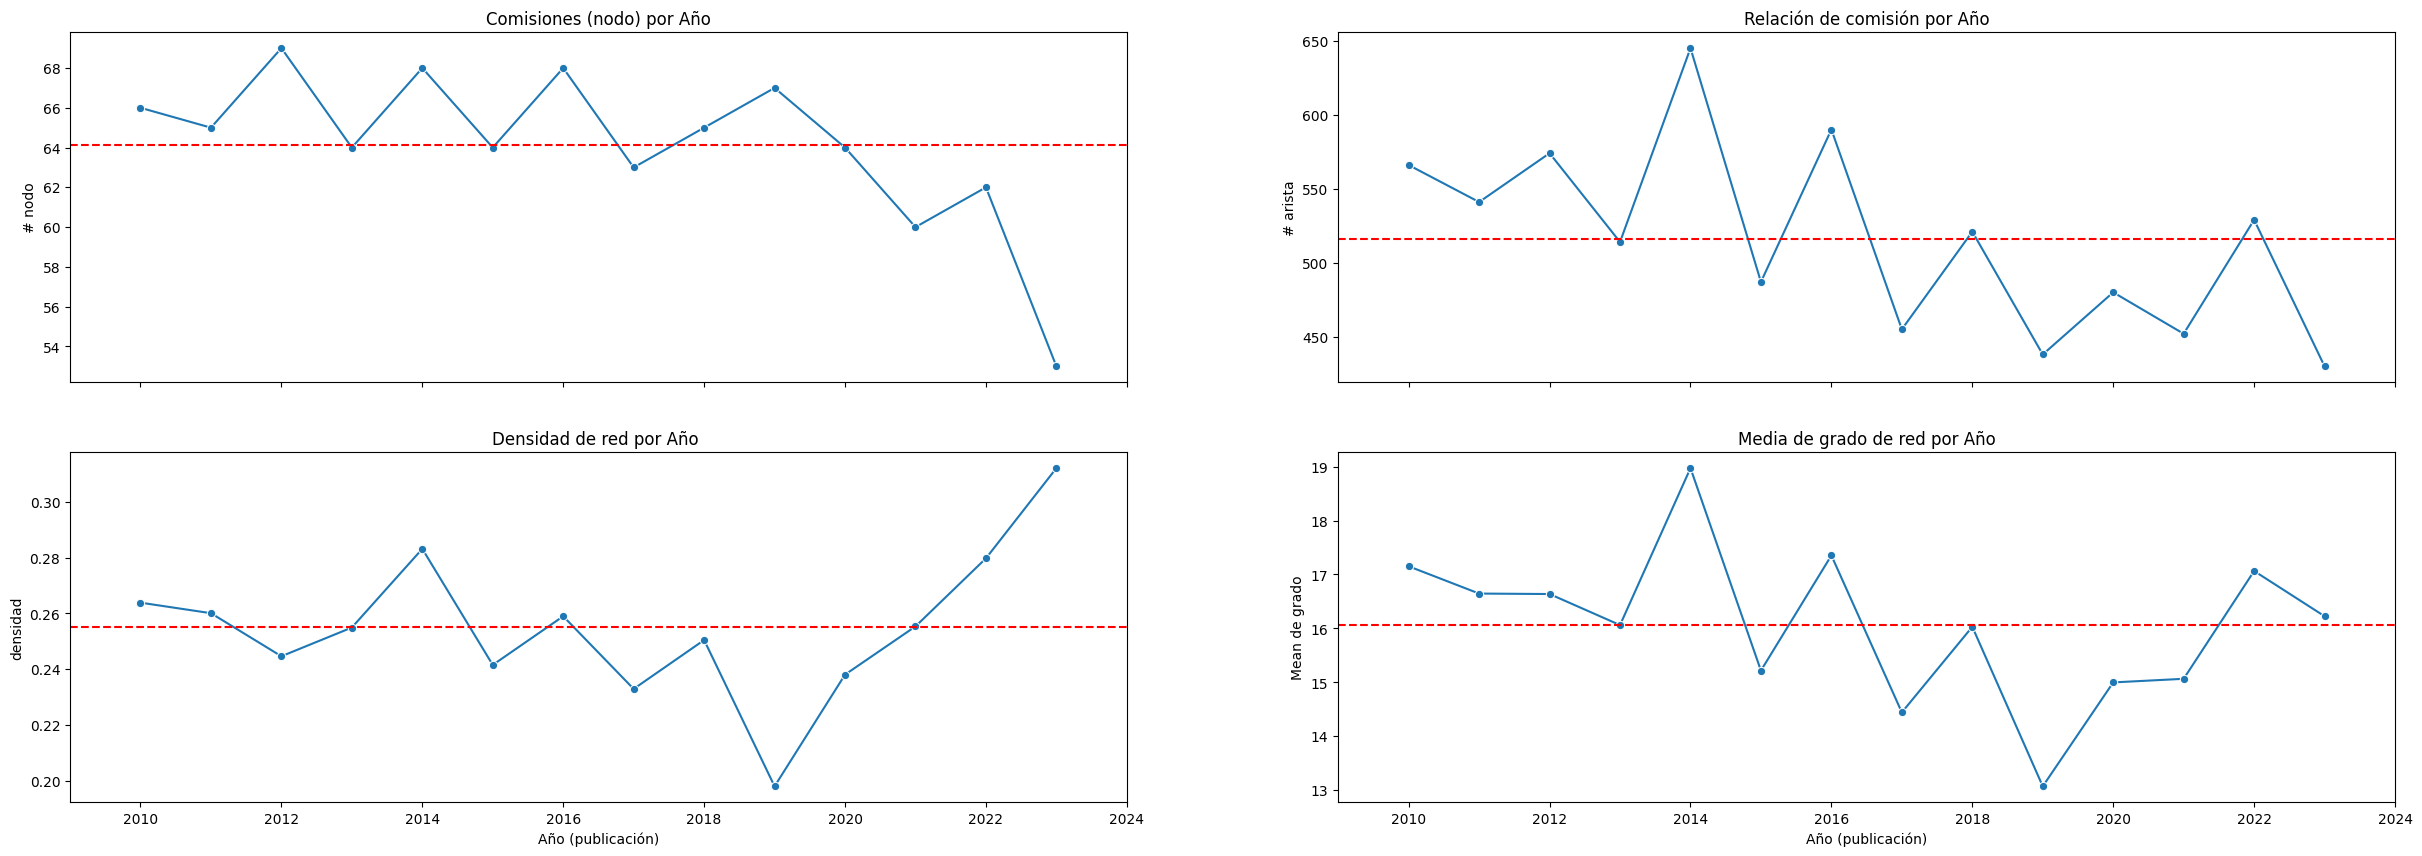

In [34]:
get_plot_graph_time(df)

In [36]:
# Para validar el 2023
a_list = memoria_df.loc[memoria_df['año'] == 2023,'proyecto_id'].unique()
temp_df = edges_1023_df[(edges_1023_df['proyecto_id'].isin(a_list))]
G = nx.from_pandas_edgelist(temp_df, 'x1', 'x2')
G.remove_edges_from(nx.selfloop_edges(G))
n = len(G.nodes())
a = len(G.edges())
den = nx.density(G)
print(n,a,den)

53 430 0.31204644412191584


#### Comisiones permanentes

*** COMISIONES PERMANTES 46:
** Creación de grafo desde : (1489, 4)
Número de nodos en el gráfo: 46
Número de aristas en el gráfo: 781
Densidad del grafo 0.7545893719806763
********** Métricas de Centralidad de la Red **********


count      mean       std       min       25%       50%  \
degree        46.0  1.416016  2.390625  0.006001  0.368958  0.807129   
centrality    46.0  0.754589  0.194292  0.111111  0.666667  0.800000   
eigenvector   46.0  0.098892  0.110568  0.000398  0.031596  0.058097   
pagerank      46.0  0.021739  0.032073  0.003335  0.008001  0.013786   
betweenness   46.0  0.098892  0.110568  0.000398  0.031596  0.058097   

                  75%        max  
degree       1.491943  15.812500  
centrality   0.888889   1.000000  
eigenvector  0.140672   0.630814  
pagerank     0.022395   0.216033  
betweenness  0.140672   0.630814

Nodos con mayor degree: ['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'ACCION SOCIAL Y SALUD PUBLICA', 'ASUNTOS CONSTITUCIONALES', 'LEGISLACION DEL TRABAJO', 'JUSTICIA']
Nodos con mayor centrality: ['PRESUPUESTO Y HACIENDA', 'ASUNTOS CONSTITUCIONALES', 'LEGISLACION DEL TRABAJO', 'ACCION SOCIAL Y SALUD PUBLICA', 'LEGISLACION GENERAL', 'PETICIONES PODERES Y REGLAMENTO']
Nodos con mayor eigenvector: ['PRESUPUESTO Y HACIENDA', 'ACCION SOCIAL Y SALUD PUBLICA', 'LEGISLACION GENERAL', 'ASUNTOS CONSTITUCIONALES', 'LEGISLACION DEL TRABAJO', 'EDUCACION']
Nodos con mayor pagerank: ['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'ACCION SOCIAL Y SALUD PUBLICA', 'ASUNTOS CONSTITUCIONALES', 'LEGISLACION DEL TRABAJO', 'LEGISLACION PENAL']
Nodos con mayor betweenness: ['PRESUPUESTO Y HACIENDA', 'ACCION SOCIAL Y SALUD PUBLICA', 'LEGISLACION GENERAL', 'ASUNTOS CONSTITUCIONALES', 'LEGISLACION DEL TRABAJO', 'EDUCACION']


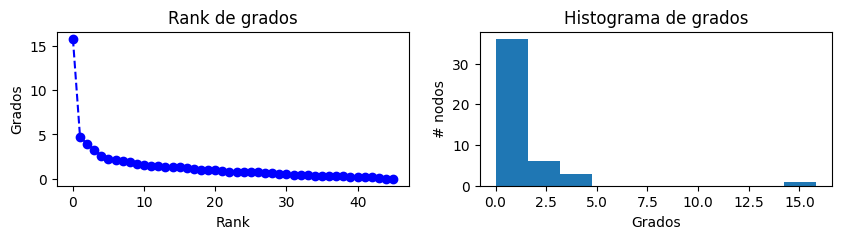

In [37]:
# memoria_df['tipo de comision'].unique() # proyecto_id # comision_nombre_norm # proyecto_girado_a_comisiones_SALUD

# Lista de comisiones permanentes
P_list = memoria_df.loc[memoria_df['tipo de comision'] == 'P','comision_nombre_norm'].unique()
print("*** COMISIONES PERMANTES 46:")
#print(P_list)
edges_df = edges_1023_df[(edges_1023_df['x1'].isin(P_list)) & (edges_1023_df['x2'].isin(P_list))]
grafo_1023_p_dict = get_dict_grafo(edges_df)


año  # nodo  # arista  densidad  min grado  max grado  mean grado  \
0   2010      42       445  0.516841          0         39     21.1905   
1   2011      41       399  0.486585          0         38     19.4634   
2   2012      42       396  0.459930          1         39     18.8571   
3   2013      43       400  0.442968          1         40     18.6047   
4   2014      43       485  0.537099          1         41     22.5581   
5   2015      43       388  0.429679          0         41     18.0465   
6   2016      44       454  0.479915          0         42     20.6364   
7   2017      43       369  0.408638          0         39     17.1628   
8   2018      44       396  0.418605          0         41     18.0000   
9   2019      46       368  0.355556          0         44     16.0000   
10  2020      44       393  0.415433          0         42     17.8636   
11  2021      44       394  0.416490          0         40     17.9091   
12  2022      44       460  0.486258          0         42     20.9091   
13  2023      44       397  0.419662          0         41     18.0455   

                         filtro  
0   Sólo comisiones permanentes  
1   Sólo comisiones permanentes  
2   Sólo comisiones permanentes  
3   Sólo comisiones permanentes  
4   Sólo comisiones permanentes  
5   Sólo comisiones permanentes  
6   Sólo comisiones permanentes  
7   Sólo comisiones permanentes  
8   Sólo comisiones permanentes  
9   Sólo comisiones permanentes  
10  Sólo comisiones permanentes  
11  Sólo comisiones permanentes  
12  Sólo comisiones permanentes  
13  Sólo comisiones permanentes

count         mean        std          min          25%  \
año          14.0  2016.500000   4.183300  2010.000000  2013.250000   
# nodo       14.0    43.357143   1.215739    41.000000    43.000000   
# arista     14.0   410.285714  35.670347   368.000000   393.250000   
densidad     14.0     0.448118   0.048807     0.355556     0.417019   
min grado    14.0     0.214286   0.425815     0.000000     0.000000   
max grado    14.0    40.642857   1.598420    38.000000    39.250000   
mean grado   14.0    18.946200   1.793337    16.000000    17.931825   

                    50%          75%          max  
año         2016.500000  2019.750000  2023.000000  
# nodo        43.500000    44.000000    46.000000  
# arista     396.500000   433.750000   485.000000  
densidad       0.436323     0.484672     0.537099  
min grado      0.000000     0.000000     1.000000  
max grado     41.000000    41.750000    44.000000  
mean grado    18.325600    20.343150    22.558100

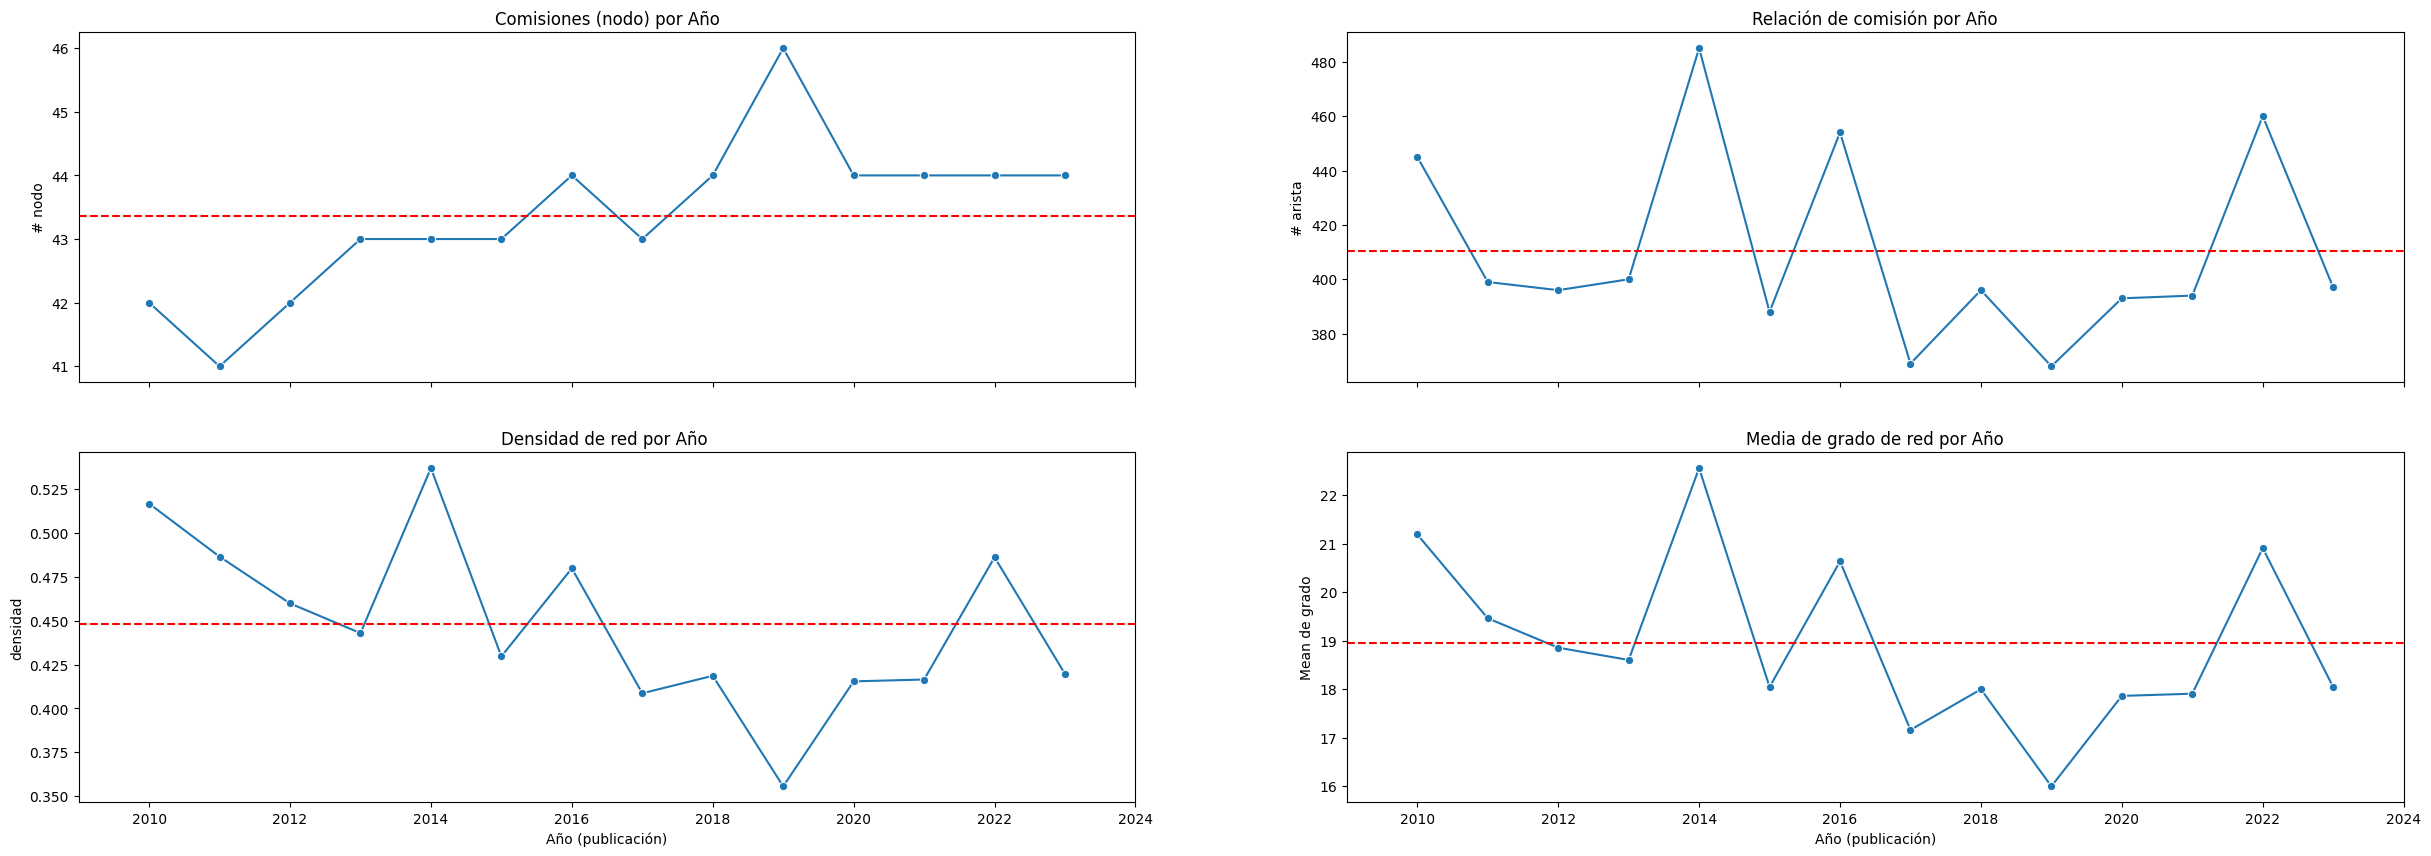

In [44]:
pdf = get_graph_time( [2010,2024], 'Sólo comisiones permanentes', memoria_df, edges_df)
display(pdf)
display(pdf.describe().T)
get_plot_graph_time(pdf)


#### Comisiones de Salud

*** Cantidad de proyectos de SALUD : 10525
** Creación de grafo desde : (689, 4)
Número de nodos en el gráfo: 61
Número de aristas en el gráfo: 411
Densidad del grafo 0.22459016393442624
********** Métricas de Centralidad de la Red **********


count      mean       std       min       25%       50%  \
degree        61.0  1.716797  5.421875  0.021301  0.085571  0.480469   
centrality    61.0  0.224590  0.195922  0.016667  0.083333  0.166667   
eigenvector   61.0  0.045960  0.120495  0.000554  0.001860  0.010520   
pagerank      61.0  0.016393  0.044332  0.002610  0.003383  0.007377   
betweenness   61.0  0.045960  0.120495  0.000554  0.001860  0.010520   

                  75%        max  
degree       1.056641  36.687500  
centrality   0.300000   1.000000  
eigenvector  0.037907   0.683029  
pagerank     0.011263   0.306277  
betweenness  0.037907   0.683029

Nodos con mayor degree: ['ACCION SOCIAL Y SALUD PUBLICA', 'PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA', 'LEGISLACION DEL TRABAJO', 'EDUCACION']
Nodos con mayor centrality: ['ACCION SOCIAL Y SALUD PUBLICA', 'PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'SALUD', 'JUSTICIA Y ASUNTOS PENALES', 'LEGISLACION PENAL']
Nodos con mayor eigenvector: ['ACCION SOCIAL Y SALUD PUBLICA', 'PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA', 'LEGISLACION DEL TRABAJO', 'EDUCACION']
Nodos con mayor pagerank: ['ACCION SOCIAL Y SALUD PUBLICA', 'PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA', 'LEGISLACION DEL TRABAJO', 'PREVENCION DE ADICCIONES Y CONTROL DEL NARCOTRAFICO']
Nodos con mayor betweenness: ['ACCION SOCIAL Y SALUD PUBLICA', 'PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA', 'LEGISLACION DEL TRABAJO', 'EDUCACION']


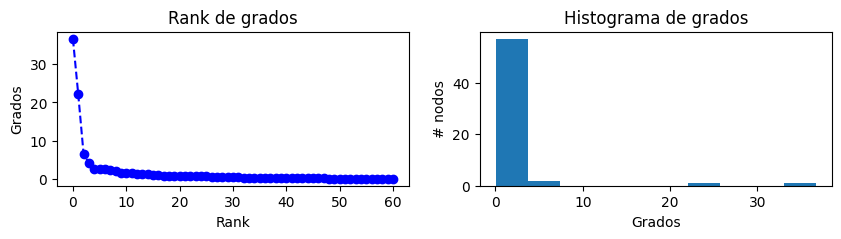

In [40]:
#memoria_df['tipo de comision'].unique() # proyecto_id # comision_nombre_norm # proyecto_girado_a_comisiones_SALUD
# Lista de proyectos de comisiones de salud
s_list = memoria_df.loc[memoria_df['proyecto_girado_a_comisiones_SALUD']=='COMISIONES DE SALUD','proyecto_id'].unique()
print("*** Cantidad de proyectos de SALUD :",len(s_list))
grafo_1023_s_dict = get_dict_grafo(edges_1023_df[(edges_1023_df['proyecto_id'].isin(s_list))])


In [41]:
for col in grafo_1023_s_dict['centralidad'].columns:
    top_nodos = grafo_1023_s_dict['centralidad'][~grafo_1023_s_dict['centralidad'].index.isin(['ACCION SOCIAL Y SALUD PUBLICA', 'SALUD', 'SALUD Y DEPORTE'])][col].sort_values(ascending=False).head(6).index.to_list()
    print(f"Nodos con mayor {col}: {top_nodos}")

    

Nodos con mayor degree: ['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA', 'LEGISLACION DEL TRABAJO', 'EDUCACION', 'PREVENCION DE ADICCIONES Y CONTROL DEL NARCOTRAFICO']
Nodos con mayor centrality: ['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'JUSTICIA Y ASUNTOS PENALES', 'LEGISLACION PENAL', 'COMERCIO', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA']
Nodos con mayor eigenvector: ['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA', 'LEGISLACION DEL TRABAJO', 'EDUCACION', 'DISCAPACIDAD']
Nodos con mayor pagerank: ['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA', 'LEGISLACION DEL TRABAJO', 'PREVENCION DE ADICCIONES Y CONTROL DEL NARCOTRAFICO', 'EDUCACION']
Nodos con mayor betweenness: ['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA', 'LEGISLACION DEL TRABAJO', 'EDUCACION', 'DISCAPACIDAD']


count         mean        std          min          25%  \
año          14.0  2016.500000   4.183300  2010.000000  2013.250000   
# nodo       14.0    38.428571   4.518582    30.000000    36.250000   
# arista     14.0   116.857143  21.795755    69.000000   106.250000   
densidad     14.0     0.163115   0.021689     0.123227     0.149470   
min grado    14.0     1.214286   0.425815     1.000000     1.000000   
max grado    14.0    37.285714   4.427685    29.000000    35.250000   
mean grado   14.0     6.054679   0.734013     4.600000     5.647925   

                   50%          75%        max  
año         2016.50000  2019.750000  2023.0000  
# nodo        39.50000    40.750000    48.0000  
# arista     116.50000   135.000000   148.0000  
densidad       0.16547     0.174681     0.2000  
min grado      1.00000     1.000000     2.0000  
max grado     38.50000    39.000000    47.0000  
mean grado     5.92415     6.727625     7.0476

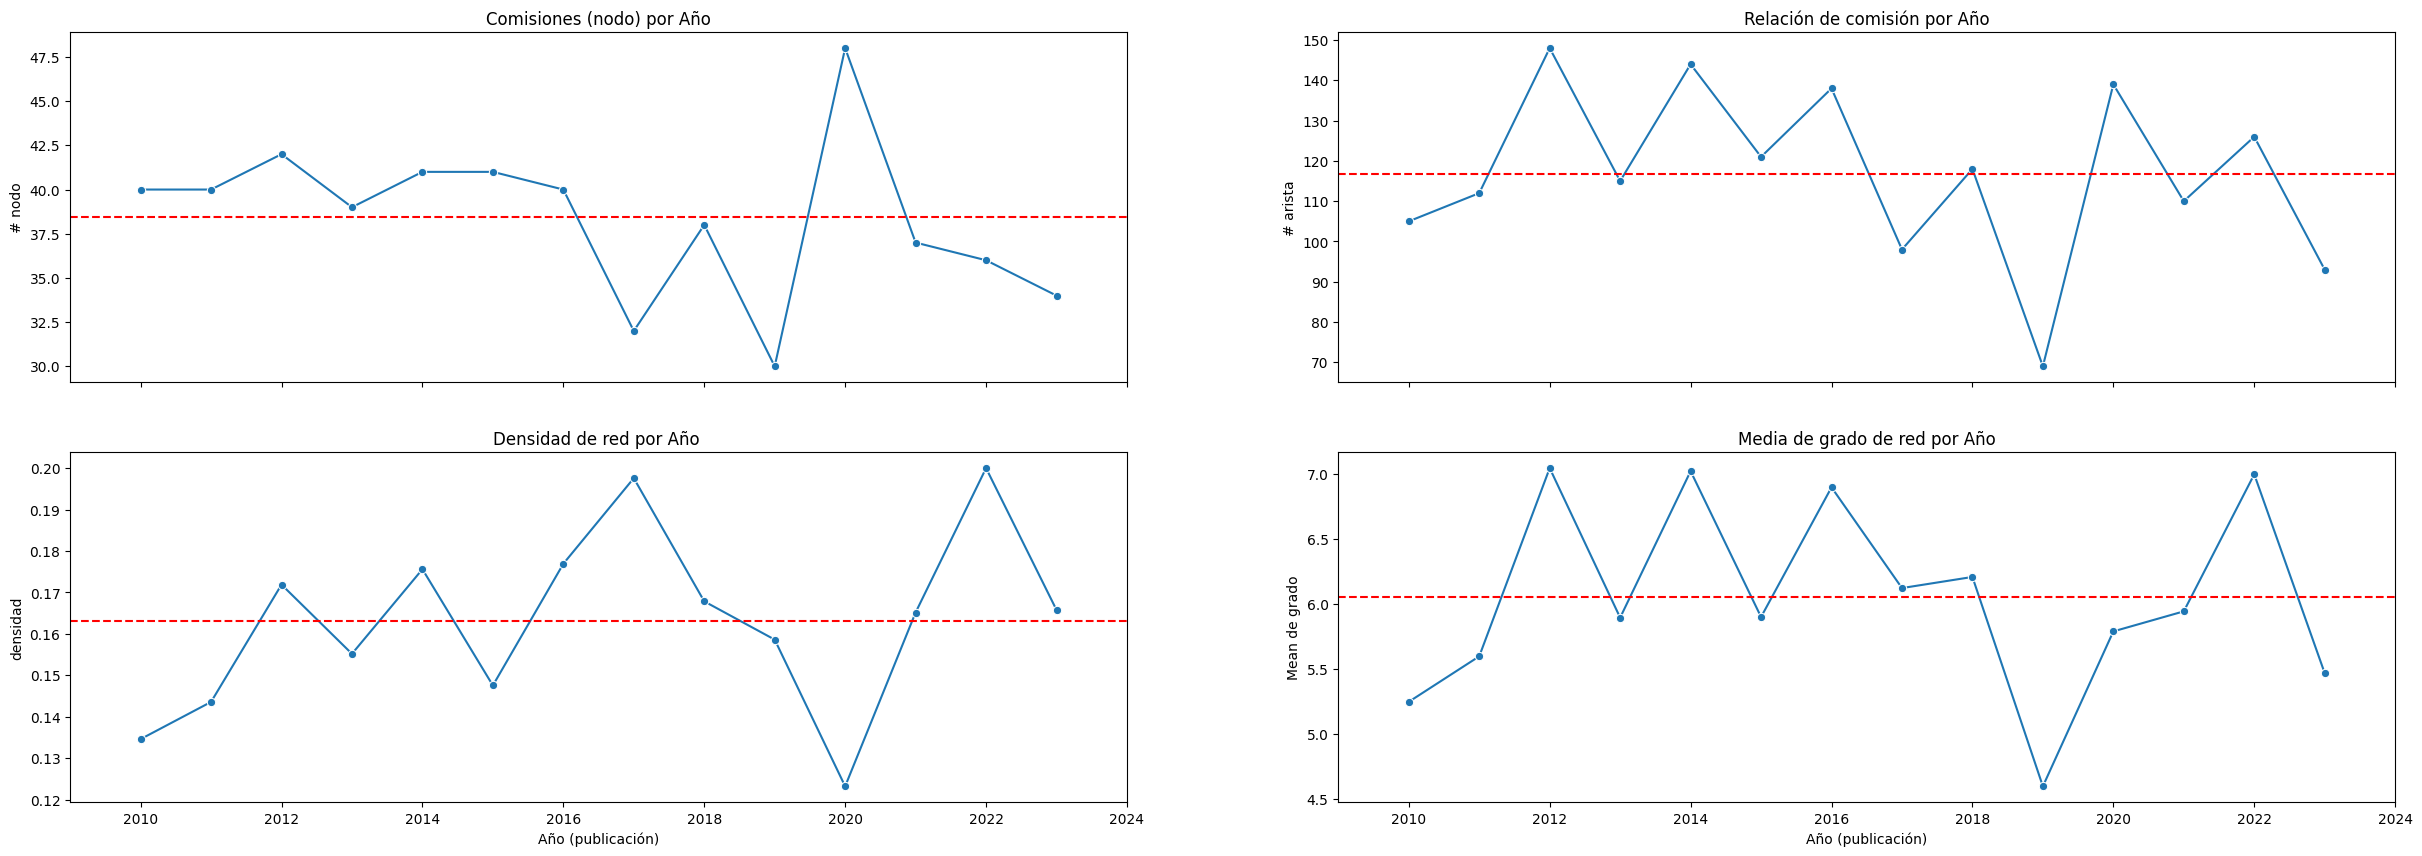

In [43]:
sdf = get_graph_time( [2010,2024], 'Solo proyectos asociados a comisiones de SALUD', memoria_df, edges_1023_df[(edges_1023_df['proyecto_id'].isin(s_list))])
#display(sdf)
display(sdf.describe().T)
get_plot_graph_time(sdf)

In [45]:
all_df = pd.concat([df,pdf,sdf]).reset_index()
#display(all_df)

(2009.0, 2024.0)

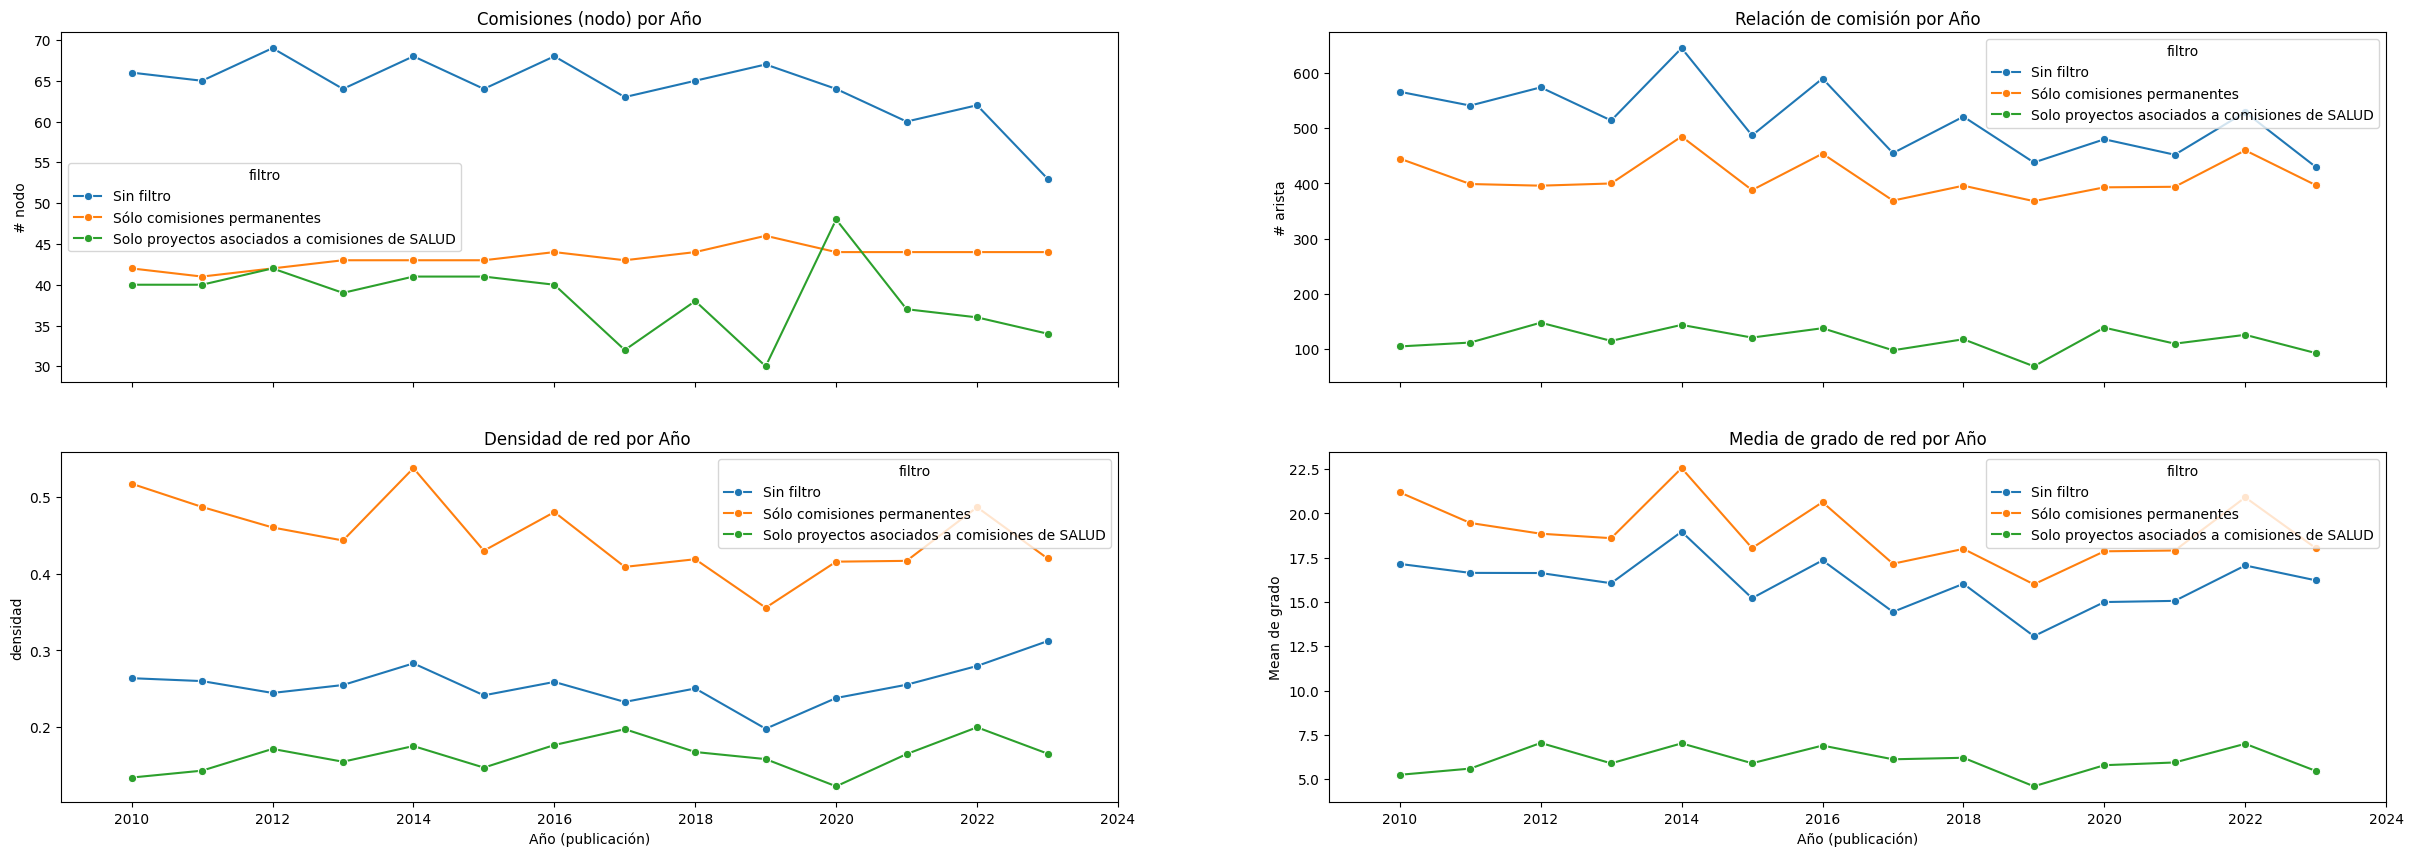

In [46]:
    f, axs = plt.subplots(2, 2, figsize=(30, 10), sharex = True)
    sns.lineplot(x=all_df['año'], y=all_df['# nodo'], estimator='sum', errorbar= None , data = all_df, hue='filtro',linestyle='-', ax = axs[0][0], marker='o')
    sns.lineplot(x=all_df['año'], y=all_df['# arista'], estimator='sum', errorbar= None, data = all_df ,hue='filtro', linestyle='-', ax = axs[0][1], marker='o')
    sns.lineplot(x=all_df['año'], y=all_df['densidad'], estimator='sum', errorbar= None, data = all_df ,hue='filtro', linestyle='-', ax = axs[1][0], marker='o')
    sns.lineplot(x=all_df['año'], y=all_df['mean grado'], estimator='sum', errorbar= None , data = all_df,hue='filtro', linestyle='-', ax = axs[1][1], marker='o')
    
    axs[0][0].set_title('Comisiones (nodo) por Año')
    axs[0][0].set_xlabel("Año (publicación)")
    axs[0][0].set_ylabel("# nodo")
    axs[0][1].set_title('Relación de comisión por Año')
    axs[0][1].set_xlabel("Año (publicación)")
    axs[0][1].set_ylabel("# arista")

    axs[1][0].set_title('Densidad de red por Año ')
    axs[1][0].set_xlabel("Año (publicación)")
    axs[1][0].set_ylabel("densidad")

    axs[1][1].set_title('Media de grado de red por Año')
    axs[1][1].set_xlabel("Año (publicación)")
    axs[1][1].set_ylabel("Mean de grado")

    axs[1][1].set_xlim(2009, 2024) 


**Comisiones permanente y de SALUD**

** Creación de grafo desde : (444, 4)
Número de nodos en el gráfo: 44
Número de aristas en el gráfo: 246
Densidad del grafo 0.26004228329809725
********** Métricas de Centralidad de la Red **********


count      mean       std       min       25%       50%  \
degree        44.0  2.175781  6.050781  0.021301  0.178894  0.656494   
centrality    44.0  0.260042  0.213690  0.023256  0.110465  0.209302   
eigenvector   44.0  0.061280  0.139332  0.000955  0.006278  0.019819   
pagerank      44.0  0.022727  0.055732  0.003580  0.004921  0.009147   
betweenness   44.0  0.061280  0.139332  0.000955  0.006278  0.019819   

                  75%        max  
degree       1.232666  35.031250  
centrality   0.308140   1.000000  
eigenvector  0.042697   0.683635  
pagerank     0.013988   0.329992  
betweenness  0.042697   0.683635

Nodos con mayor degree: ['ACCION SOCIAL Y SALUD PUBLICA', 'PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA', 'LEGISLACION DEL TRABAJO', 'EDUCACION']
Nodos con mayor centrality: ['ACCION SOCIAL Y SALUD PUBLICA', 'PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'ASUNTOS CONSTITUCIONALES', 'LEGISLACION PENAL', 'LEGISLACION DEL TRABAJO']
Nodos con mayor eigenvector: ['ACCION SOCIAL Y SALUD PUBLICA', 'PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA', 'LEGISLACION DEL TRABAJO', 'EDUCACION']
Nodos con mayor pagerank: ['ACCION SOCIAL Y SALUD PUBLICA', 'PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA', 'LEGISLACION DEL TRABAJO', 'EDUCACION']
Nodos con mayor betweenness: ['ACCION SOCIAL Y SALUD PUBLICA', 'PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA', 'LEGISLACION DEL TRABAJO', 'EDUCACION']


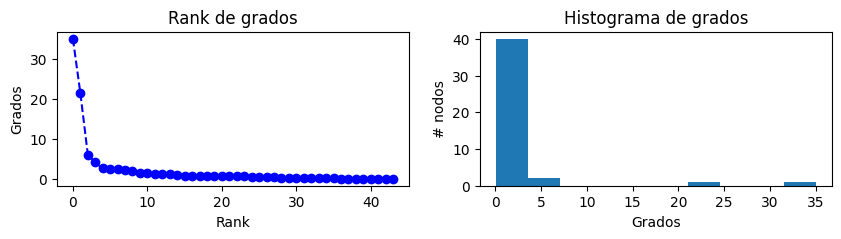

In [47]:
grafo_1023_s_p_dict = get_dict_grafo(edges_df[(edges_df['proyecto_id'].isin(s_list))])

In [48]:
for col in grafo_1023_s_p_dict['centralidad'].columns:
    top_nodos = grafo_1023_s_p_dict['centralidad'][~grafo_1023_s_p_dict['centralidad'].index.isin(['ACCION SOCIAL Y SALUD PUBLICA', 'SALUD', 'SALUD Y DEPORTE'])][col].sort_values(ascending=False).head(6).index.to_list()
    print(f"Nodos con mayor {col}: {top_nodos}")

Nodos con mayor degree: ['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA', 'LEGISLACION DEL TRABAJO', 'EDUCACION', 'PREVENCION DE ADICCIONES Y CONTROL DEL NARCOTRAFICO']
Nodos con mayor centrality: ['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'ASUNTOS CONSTITUCIONALES', 'LEGISLACION PENAL', 'LEGISLACION DEL TRABAJO', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA']
Nodos con mayor eigenvector: ['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA', 'LEGISLACION DEL TRABAJO', 'EDUCACION', 'DISCAPACIDAD']
Nodos con mayor pagerank: ['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA', 'LEGISLACION DEL TRABAJO', 'EDUCACION', 'PREVENCION DE ADICCIONES Y CONTROL DEL NARCOTRAFICO']
Nodos con mayor betweenness: ['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA', 'LEGISLACION DEL TRABAJO', 'EDUCACION', 'DISCAPACIDAD']


count         mean        std          min          25%  \
año          14.0  2016.500000   4.183300  2010.000000  2013.250000   
# nodo       14.0    32.642857   3.295852    27.000000    31.000000   
# arista     14.0    89.714286  15.715884    57.000000    81.500000   
densidad     14.0     0.174021   0.021525     0.126829     0.162988   
min grado    14.0     1.214286   0.425815     1.000000     1.000000   
max grado    14.0    31.571429   3.367590    26.000000    30.000000   
mean grado   14.0     5.477636   0.674325     4.222200     5.095225   

                    50%          75%          max  
año         2016.500000  2019.750000  2023.000000  
# nodo        33.000000    33.750000    41.000000  
# arista      88.500000    98.500000   116.000000  
densidad       0.173143     0.192147     0.204433  
min grado      1.000000     1.000000     2.000000  
max grado     32.000000    32.750000    40.000000  
mean grado     5.600400     5.709750     6.647100

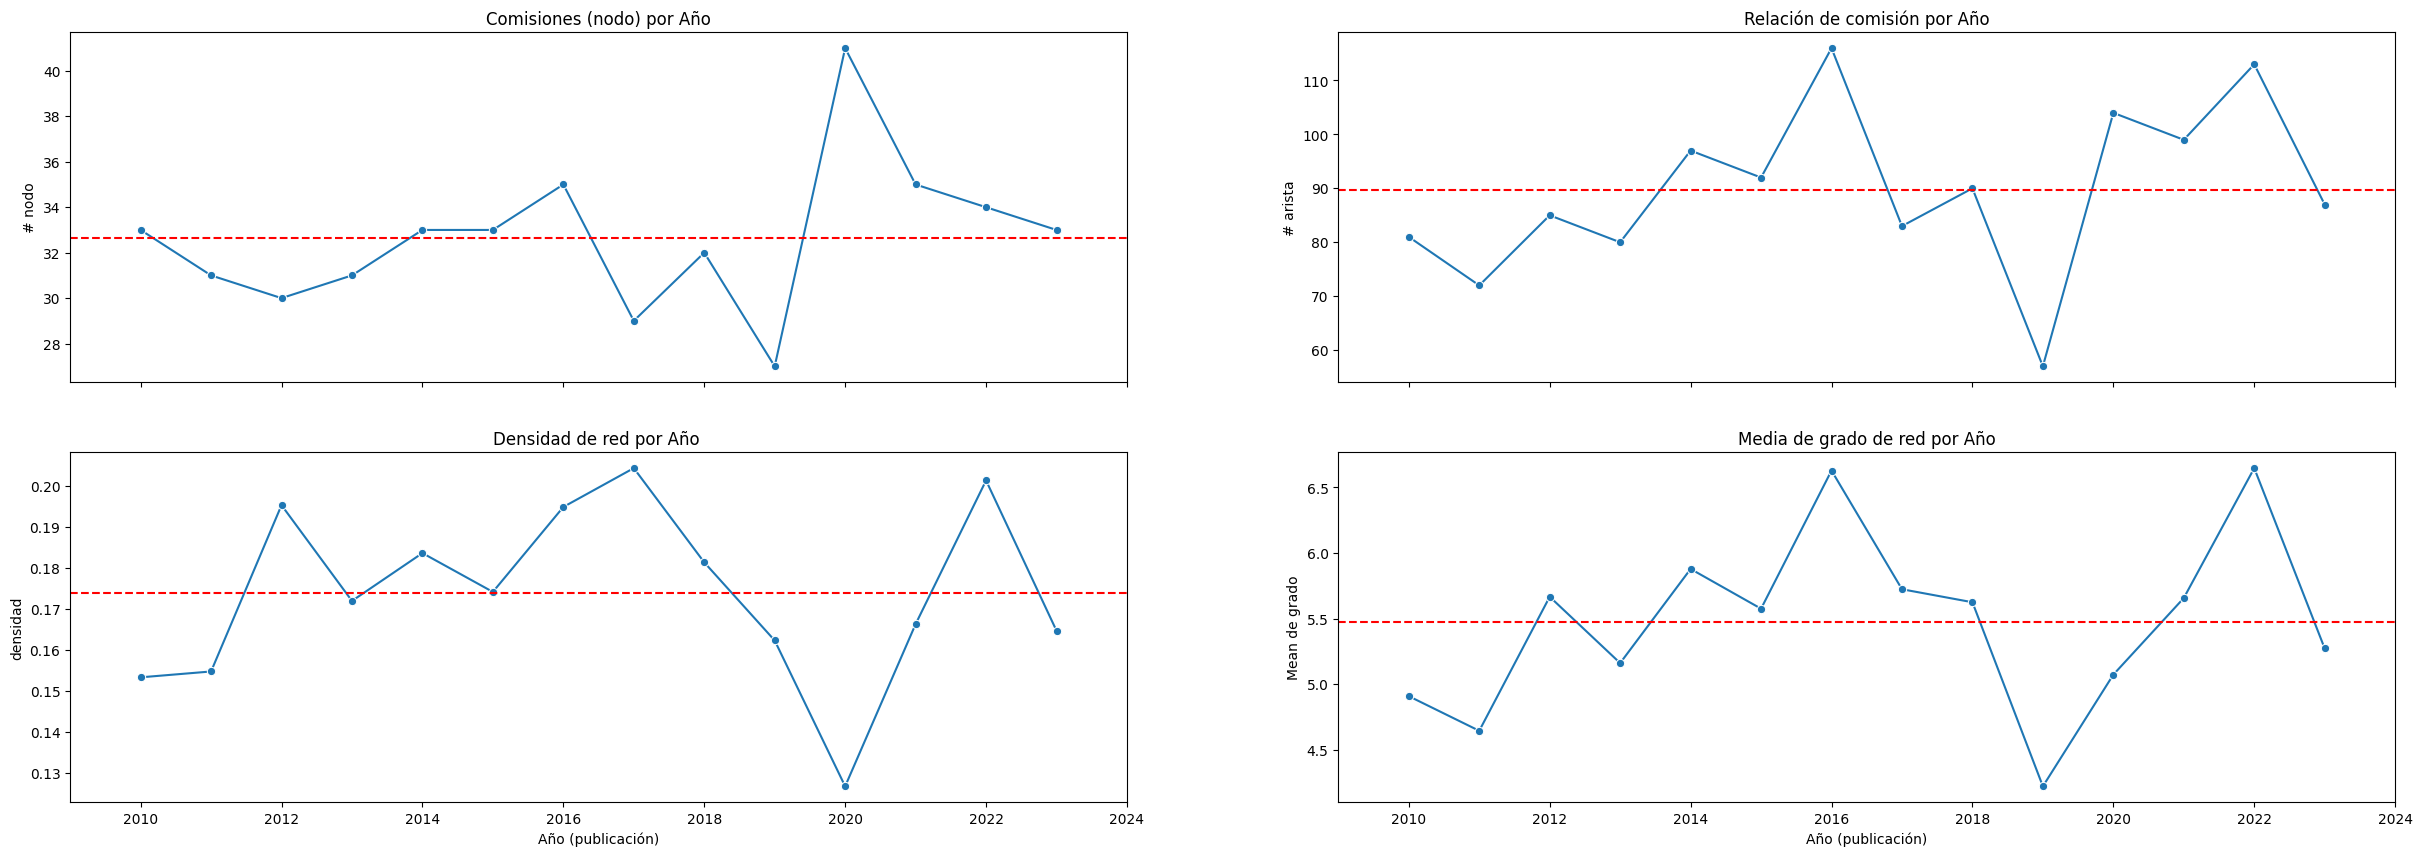

In [50]:
psdf = get_graph_time( [2010,2024], 'Solo proyectos asociados a comisiones de PERMANENTE- SALUD', memoria_df, edges_df[(edges_df['proyecto_id'].isin(s_list))])
#display(sdf)
display(psdf.describe().T)
get_plot_graph_time(psdf)

### 1.1 - Grafo IL entre 2010 a 2023 por tipo de proyecto : Ley

Se denominan proyectos a las iniciativas legislativas de los Diputados, Senadores y Poder Ejecutivo. Hay distintos tipos de proyectos:
* Proyectos de ley: destinados a crear, modificar, sustituir o abrogar una ley, institución o norma de caracter general.
* Proyectos de resolución: destinados a la adopción de medidas relativas a la composición u organización interna del cuerpo, las modificaciones del reglamento y, en general, de toda disposición de carácter imperativo que pueda adoptar la Cámara.
* Proyectos de declaración: destinados a expresar una opinión del cuerpo sobre cualquier hecho de carácter público o privado, o manifestar la voluntad de que el Poder Ejecutivo practique algún acto en particular.

Cantidad de proyectos de ley: 78218
** Creación de grafo desde : (2084, 4)
Número de nodos en el gráfo: 71
Número de aristas en el gráfo: 1180
Densidad del grafo 0.47484909456740443
********** Métricas de Centralidad de la Red **********


count      mean       std           min       25%       50%  \
degree        71.0  2.289062  5.128906  0.000000e+00  0.137390  0.900391   
centrality    71.0  0.474849  0.232096  0.000000e+00  0.335714  0.485714   
eigenvector   71.0  0.064987  0.100011  7.757558e-21  0.002646  0.030479   
pagerank      71.0  0.014085  0.026808  2.138275e-03  0.003361  0.006945   
betweenness   71.0  0.064987  0.100011  7.757558e-21  0.002646  0.030479   

                  75%        max  
degree       2.400391  40.281250  
centrality   0.657143   0.971429  
eigenvector  0.086461   0.635261  
pagerank     0.014436   0.213336  
betweenness  0.086461   0.635261

Nodos con mayor degree: ['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'ACCION SOCIAL Y SALUD PUBLICA', 'LEGISLACION DEL TRABAJO', 'ASUNTOS CONSTITUCIONALES', 'JUSTICIA']
Nodos con mayor centrality: ['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'ACCION SOCIAL Y SALUD PUBLICA', 'LEGISLACION DEL TRABAJO', 'COMERCIO', 'COMUNICACIONES E INFORMATICA']
Nodos con mayor eigenvector: ['PRESUPUESTO Y HACIENDA', 'ACCION SOCIAL Y SALUD PUBLICA', 'LEGISLACION GENERAL', 'LEGISLACION DEL TRABAJO', 'EDUCACION', 'ASUNTOS CONSTITUCIONALES']
Nodos con mayor pagerank: ['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'ACCION SOCIAL Y SALUD PUBLICA', 'LEGISLACION DEL TRABAJO', 'ASUNTOS CONSTITUCIONALES', 'LEGISLACION PENAL']
Nodos con mayor betweenness: ['PRESUPUESTO Y HACIENDA', 'ACCION SOCIAL Y SALUD PUBLICA', 'LEGISLACION GENERAL', 'LEGISLACION DEL TRABAJO', 'EDUCACION', 'ASUNTOS CONSTITUCIONALES']


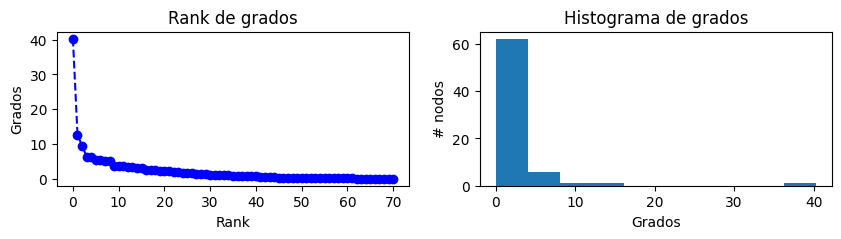

In [51]:
t_list = memoria_df.loc[memoria_df['tipo'] == 'LEY', 'proyecto_id']
print("Cantidad de proyectos de ley:",len(t_list))
grafo_1023_ley_dict = get_dict_grafo(edges_1023_df[(edges_1023_df['proyecto_id'].isin(t_list))])
ley_df = get_graph_time( [2010,2024], 'Ley', memoria_df, edges_1023_df[(edges_1023_df['proyecto_id'].isin(t_list))])


** Creación de grafo desde : (1394, 4)
Número de nodos en el gráfo: 45
Número de aristas en el gráfo: 734
Densidad del grafo 0.7414141414141414
********** Métricas de Centralidad de la Red **********


count      mean       std       min       25%       50%  \
degree        45.0  3.314453  5.906250  0.016006  0.885742  1.832031   
centrality    45.0  0.741414  0.192438  0.113636  0.636364  0.795455   
eigenvector   45.0  0.099024  0.112688  0.000427  0.031195  0.058460   
pagerank      45.0  0.022222  0.034840  0.003421  0.008325  0.013579   
betweenness   45.0  0.099024  0.112688  0.000427  0.031195  0.058460   

                  75%        max  
degree       3.388672  38.687500  
centrality   0.863636   1.000000  
eigenvector  0.141259   0.636295  
pagerank     0.021979   0.232207  
betweenness  0.141259   0.636295

Nodos con mayor degree: ['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'ACCION SOCIAL Y SALUD PUBLICA', 'ASUNTOS CONSTITUCIONALES', 'LEGISLACION DEL TRABAJO', 'JUSTICIA']
Nodos con mayor centrality: ['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'LEGISLACION DEL TRABAJO', 'ACCION SOCIAL Y SALUD PUBLICA', 'ASUNTOS CONSTITUCIONALES', 'PETICIONES PODERES Y REGLAMENTO']
Nodos con mayor eigenvector: ['PRESUPUESTO Y HACIENDA', 'ACCION SOCIAL Y SALUD PUBLICA', 'LEGISLACION GENERAL', 'LEGISLACION DEL TRABAJO', 'EDUCACION', 'ASUNTOS CONSTITUCIONALES']
Nodos con mayor pagerank: ['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'ACCION SOCIAL Y SALUD PUBLICA', 'ASUNTOS CONSTITUCIONALES', 'LEGISLACION DEL TRABAJO', 'LEGISLACION PENAL']
Nodos con mayor betweenness: ['PRESUPUESTO Y HACIENDA', 'ACCION SOCIAL Y SALUD PUBLICA', 'LEGISLACION GENERAL', 'LEGISLACION DEL TRABAJO', 'EDUCACION', 'ASUNTOS CONSTITUCIONALES']


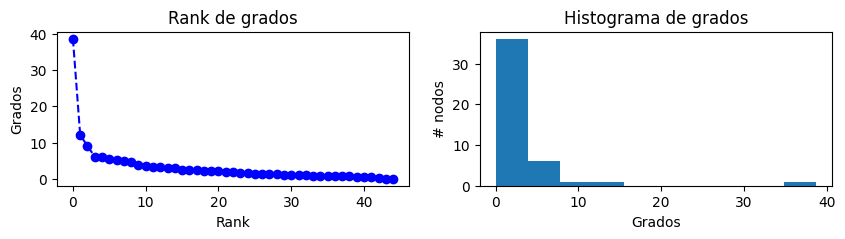

In [52]:
# Comisiones permanentes
grafo_1023_ley_p_dict = get_dict_grafo(edges_df[(edges_df['proyecto_id'].isin(t_list))])
ley_p_df = get_graph_time( [2010,2024], 'Ley y comisiones permanentes', memoria_df, edges_df[(edges_df['proyecto_id'].isin(t_list))])

** Creación de grafo desde : (649, 4)
Número de nodos en el gráfo: 60
Número de aristas en el gráfo: 385
Densidad del grafo 0.2175141242937853
********** Métricas de Centralidad de la Red **********


count      mean        std       min       25%       50%  \
degree        60.0  3.646484  11.382812  0.049805  0.199341  0.760498   
centrality    60.0  0.217514   0.195035  0.033898  0.084746  0.161017   
eigenvector   60.0  0.045039   0.122009  0.000593  0.002219  0.009312   
pagerank      60.0  0.016667   0.044188  0.002666  0.003438  0.005474   
betweenness   60.0  0.045039   0.122009  0.000593  0.002219  0.009312   

                  75%        max  
degree       1.919189  74.062500  
centrality   0.266949   1.000000  
eigenvector  0.025736   0.681517  
pagerank     0.010612   0.293212  
betweenness  0.025736   0.681517

Nodos con mayor degree: ['ACCION SOCIAL Y SALUD PUBLICA', 'PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA', 'EDUCACION', 'PREVENCION DE ADICCIONES Y CONTROL DEL NARCOTRAFICO']
Nodos con mayor centrality: ['ACCION SOCIAL Y SALUD PUBLICA', 'PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'SALUD', 'JUSTICIA Y ASUNTOS PENALES', 'LEGISLACION PENAL']
Nodos con mayor eigenvector: ['ACCION SOCIAL Y SALUD PUBLICA', 'PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA', 'EDUCACION', 'LEGISLACION DEL TRABAJO']
Nodos con mayor pagerank: ['ACCION SOCIAL Y SALUD PUBLICA', 'PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA', 'PREVENCION DE ADICCIONES Y CONTROL DEL NARCOTRAFICO', 'EDUCACION']
Nodos con mayor betweenness: ['ACCION SOCIAL Y SALUD PUBLICA', 'PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA', 'EDUCACION', 'LEGISLACION DEL TRABAJO']


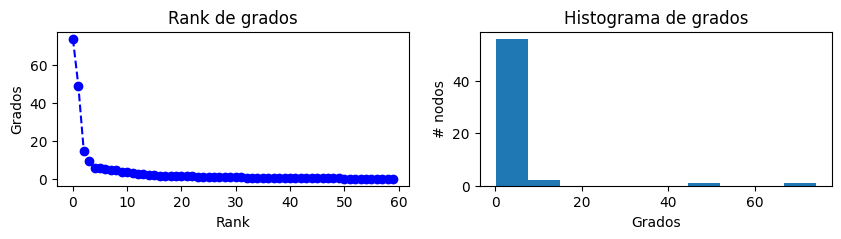

In [53]:
grafo_1023_s_ley_dict = get_dict_grafo(edges_1023_df[(edges_1023_df['proyecto_id'].isin(s_list)) & (edges_1023_df['proyecto_id'].isin(t_list))])
ley_s_df = get_graph_time( [2010,2024], 'Ley y Salud', memoria_df, edges_1023_df[(edges_1023_df['proyecto_id'].isin(s_list)) & (edges_1023_df['proyecto_id'].isin(t_list))])



In [54]:
for col in grafo_1023_s_ley_dict['centralidad'].columns:
    top_nodos = grafo_1023_s_ley_dict['centralidad'][~grafo_1023_s_ley_dict['centralidad'].index.isin(['ACCION SOCIAL Y SALUD PUBLICA', 'SALUD', 'SALUD Y DEPORTE'])][col].sort_values(ascending=False).head(6).index.to_list()
    print(f"Nodos con mayor {col}: {top_nodos}")

Nodos con mayor degree: ['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA', 'EDUCACION', 'PREVENCION DE ADICCIONES Y CONTROL DEL NARCOTRAFICO', 'LEGISLACION DEL TRABAJO']
Nodos con mayor centrality: ['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'JUSTICIA Y ASUNTOS PENALES', 'LEGISLACION PENAL', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA', 'COMERCIO']
Nodos con mayor eigenvector: ['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA', 'EDUCACION', 'LEGISLACION DEL TRABAJO', 'PREVENCION DE ADICCIONES Y CONTROL DEL NARCOTRAFICO']
Nodos con mayor pagerank: ['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA', 'PREVENCION DE ADICCIONES Y CONTROL DEL NARCOTRAFICO', 'EDUCACION', 'LEGISLACION DEL TRABAJO']
Nodos con mayor betweenness: ['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA', 'EDUCACION', 'LEGISLACION DEL TRABAJO', 'PREVENCION DE ADICCIONES Y CONTROL 

** Creación de grafo desde : (415, 4)
Número de nodos en el gráfo: 43
Número de aristas en el gráfo: 226
Densidad del grafo 0.2502768549280177
********** Métricas de Centralidad de la Red **********


count      mean        std       min       25%       50%  \
degree        43.0  4.625000  12.710938  0.049805  0.386475  1.146484   
centrality    43.0  0.250277   0.215001  0.047619  0.107143  0.190476   
eigenvector   43.0  0.060327   0.141716  0.000994  0.006080  0.015083   
pagerank      43.0  0.023256   0.055919  0.003677  0.005169  0.008496   
betweenness   43.0  0.060327   0.141716  0.000994  0.006080  0.015083   

                  75%        max  
degree       2.766602  70.500000  
centrality   0.285714   1.000000  
eigenvector  0.043137   0.682160  
pagerank     0.014430   0.315918  
betweenness  0.043137   0.682160

Nodos con mayor degree: ['ACCION SOCIAL Y SALUD PUBLICA', 'PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA', 'EDUCACION', 'LEGISLACION DEL TRABAJO']
Nodos con mayor centrality: ['ACCION SOCIAL Y SALUD PUBLICA', 'PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'LEGISLACION PENAL', 'LEGISLACION DEL TRABAJO', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA']
Nodos con mayor eigenvector: ['ACCION SOCIAL Y SALUD PUBLICA', 'PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA', 'EDUCACION', 'LEGISLACION DEL TRABAJO']
Nodos con mayor pagerank: ['ACCION SOCIAL Y SALUD PUBLICA', 'PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA', 'LEGISLACION DEL TRABAJO', 'EDUCACION']
Nodos con mayor betweenness: ['ACCION SOCIAL Y SALUD PUBLICA', 'PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA', 'EDUCACION', 'LEGISLACION DEL TRABAJO']


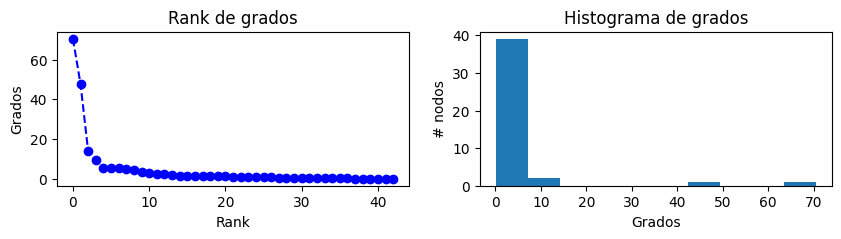

In [55]:
grafo_1023_s_p_ley_dict = get_dict_grafo(edges_df[(edges_df['proyecto_id'].isin(s_list)) & (edges_df['proyecto_id'].isin(t_list))])
ley_s_p_df = get_graph_time( [2010,2024], 'Ley, comisiones permanente y  Salud', memoria_df,edges_df[(edges_df['proyecto_id'].isin(s_list)) & (edges_df['proyecto_id'].isin(t_list))])

In [56]:
for col in grafo_1023_s_p_ley_dict['centralidad'].columns:
    top_nodos = grafo_1023_s_p_ley_dict['centralidad'][~grafo_1023_s_p_ley_dict['centralidad'].index.isin(['ACCION SOCIAL Y SALUD PUBLICA', 'SALUD', 'SALUD Y DEPORTE'])][col].sort_values(ascending=False).head(6).index.to_list()
    print(f"Nodos con mayor {col}: {top_nodos}")

Nodos con mayor degree: ['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA', 'EDUCACION', 'LEGISLACION DEL TRABAJO', 'PREVENCION DE ADICCIONES Y CONTROL DEL NARCOTRAFICO']
Nodos con mayor centrality: ['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'LEGISLACION PENAL', 'LEGISLACION DEL TRABAJO', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA', 'EDUCACION']
Nodos con mayor eigenvector: ['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA', 'EDUCACION', 'LEGISLACION DEL TRABAJO', 'PREVENCION DE ADICCIONES Y CONTROL DEL NARCOTRAFICO']
Nodos con mayor pagerank: ['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA', 'LEGISLACION DEL TRABAJO', 'EDUCACION', 'PREVENCION DE ADICCIONES Y CONTROL DEL NARCOTRAFICO']
Nodos con mayor betweenness: ['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA', 'EDUCACION', 'LEGISLACION DEL TRABAJO', 'PREVENCION DE ADICCIONES Y CONTROL DE

In [57]:
all_ley_df = pd.concat([ley_df,ley_p_df,ley_s_df,ley_s_p_df]).reset_index()
df = pd.concat([all_df,all_ley_df])

(2009.0, 2024.0)

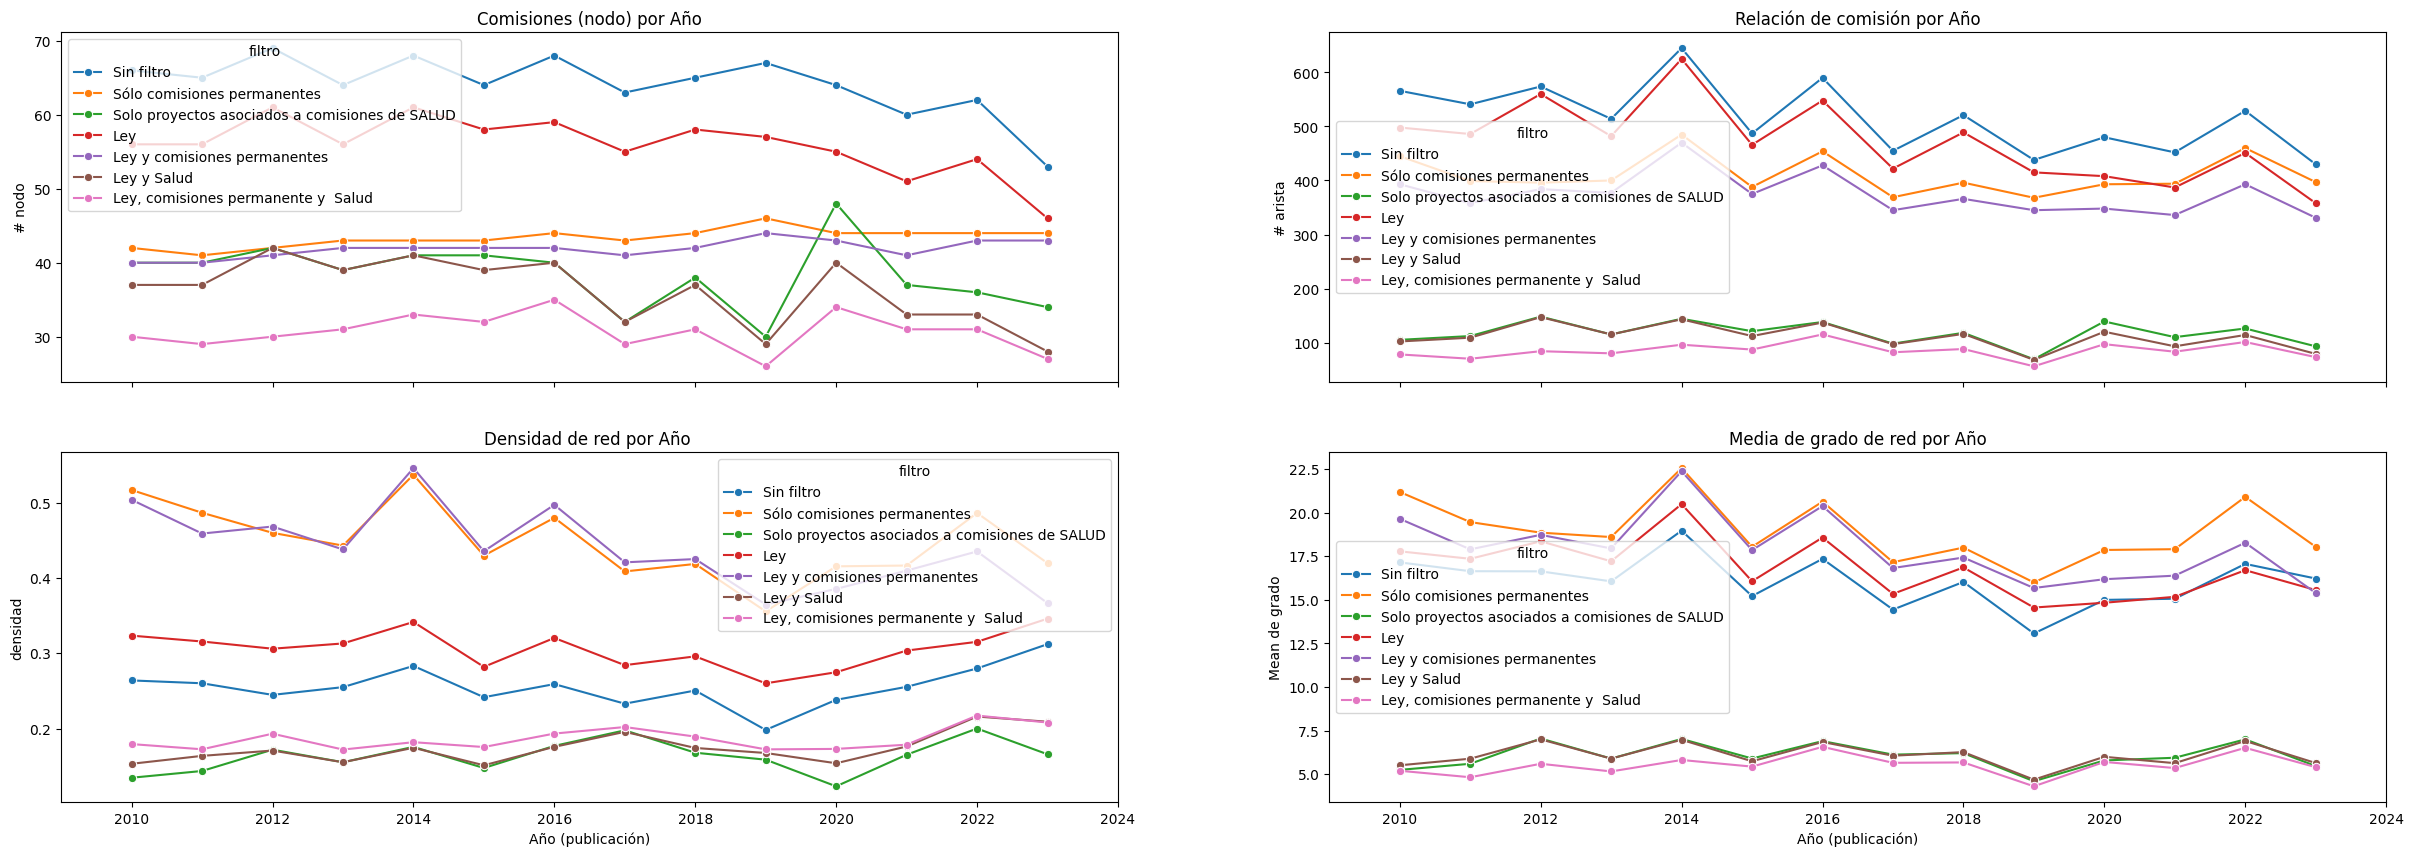

In [58]:
    f, axs = plt.subplots(2, 2, figsize=(30, 10), sharex = True)
    sns.lineplot(x=df['año'], y=df['# nodo'], estimator='sum', errorbar= None , data = df, hue='filtro',linestyle='-', ax = axs[0][0], marker='o')
    sns.lineplot(x=df['año'], y=df['# arista'], estimator='sum', errorbar= None, data = df ,hue='filtro', linestyle='-', ax = axs[0][1], marker='o')
    sns.lineplot(x=df['año'], y=df['densidad'], estimator='sum', errorbar= None, data = df ,hue='filtro', linestyle='-', ax = axs[1][0], marker='o')
    sns.lineplot(x=df['año'], y=df['mean grado'], estimator='sum', errorbar= None , data = df,hue='filtro', linestyle='-', ax = axs[1][1], marker='o')
    
    axs[0][0].set_title('Comisiones (nodo) por Año')
    axs[0][0].set_xlabel("Año (publicación)")
    axs[0][0].set_ylabel("# nodo")
    axs[0][1].set_title('Relación de comisión por Año')
    axs[0][1].set_xlabel("Año (publicación)")
    axs[0][1].set_ylabel("# arista")

    axs[1][0].set_title('Densidad de red por Año ')
    axs[1][0].set_xlabel("Año (publicación)")
    axs[1][0].set_ylabel("densidad")

    axs[1][1].set_title('Media de grado de red por Año')
    axs[1][1].set_xlabel("Año (publicación)")
    axs[1][1].set_ylabel("Mean de grado")

    axs[1][1].set_xlim(2009, 2024) 


### Ventana 2008-2023
* Número de nodos en el gráfo: 85
* Número de aristas en el gráfo: 1255
* Densidad del grafo 0.35154061624649857
    * Solo comisiones permanentes :  0.7545893719806763
        * Solo comisiones permanentes proyecto de ley :  0.7414141414141414

    * Solo comisiones de salud: 0.22459016393442624
        * Solo comisiones permanentes, asociadas a salud: 0.26004228329809725
        * Solo comisiones salud proyecto de ley: 0.2175141242937853
        * Solo comisiones permanentes, asociadas a salud y proyecto de ley :0.2502768549280177

    * Solo proyectos de ley: 0.47484909456740443
 
      
* Según  métricas de centralidad contemplando la fuente giro de comisiones (Fuente original con limpieza), comisiones claves: 
* 
    * Contemplando tiempo, y existencia de datos, comisiones claves: ['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'ACCION SOCIAL Y SALUD PUBLICA', 'ASUNTOS CONSTITUCIONALES', **'LEGISLACION DEL TRABAJO'**]
        
		* Contemplando tiempo, y existencia de datos, comisiones claves - SALUD: ['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', **'FAMILIA MUJER NINEZ Y ADOLESCENCIA'**]
		
        * Contemplando tiempo, y existencia de datos, comisiones claves - PROYECTOS DE LEY:  ['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'ACCION SOCIAL Y SALUD PUBLICA', 'LEGISLACION DEL TRABAJO']

		* Contemplando tiempo, y existencia de datos, comisiones claves - SALUD - PROYECTO DE LEY: ['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA']		
    
    * Contemplando tiempo, y existencia de datos, comisiones claves - COMISIONES PERMANENTES: ['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'ACCION SOCIAL Y SALUD PUBLICA', 'ASUNTOS CONSTITUCIONALES', 'LEGISLACION DEL TRABAJO']  

    * Contemplando tiempo, y existencia de datos, comisiones claves - COMISIONES PERMANENTES - SALUD:['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA', 'LEGISLACION DEL TRABAJO']
       
		* Contemplando tiempo, y existencia de datos, comisiones claves - COMISIONES PERMANENTES - PROYECTO_LEY: ['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'ACCION SOCIAL Y SALUD PUBLICA', 'ASUNTOS CONSTITUCIONALES', 'LEGISLACION DEL TRABAJO']
		
		* Contemplando tiempo, y existencia de datos, comisiones claves - COMISIONES PERMANENTES - PROYECTO_LEY - SALUD: ['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA', **'EDUCACION'**, 'LEGISLACION DEL TRABAJO']

## 2 - Identificando clustering mediantes red de comisiones

In [59]:
# Para obtener gráfica
# ver https://cienciadedatos.net/documentos/py20-clustering-con-python
def plot_dendrogram(model, **kwargs):
    '''
    Esta función extrae la información de un modelo AgglomerativeClustering
    y representa su dendograma con la función dendogram de scipy.cluster.hierarchy
    '''
    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot
    ddata = dendrogram(linkage_matrix, **kwargs)
    return linkage_matrix, ddata

In [60]:
def encontrar_clusters(c):
    # Escalado de las métricas para pooder compararlas
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(c)
    centralidad_scaled = pd.DataFrame(
                            scaler.transform(c),
                            columns=scaler.feature_names_in_,
                            index=c.index
                        )
    
    x = centralidad_scaled
    # Modelos
    # ==============================================================================
    modelo_hclust_complete = AgglomerativeClustering(
                                metric = 'euclidean',
                                linkage  = 'complete',
                                distance_threshold = 0,
                                n_clusters         = None
                            )
    modelo_hclust_complete.fit(X=x)
    
    modelo_hclust_average = AgglomerativeClustering(
                                metric = 'euclidean',
                                linkage  = 'average',
                                distance_threshold = 0,
                                n_clusters         = None
                            )
    modelo_hclust_average.fit(X=x)
    
    modelo_hclust_ward = AgglomerativeClustering(
                                metric = 'euclidean',
                                linkage  = 'ward',
                                distance_threshold = 0,
                                n_clusters         = None
                         )
    modelo_hclust_ward.fit(X=x)
    
    # Dendrogramas
    # ==============================================================================
    fig, axs = plt.subplots(3, 1, figsize=(10, 9))
    plot_dendrogram(modelo_hclust_average, color_threshold=0, ax=axs[0])
    axs[0].set_title("Distancia euclídea, Linkage average")
    plot_dendrogram(modelo_hclust_complete, color_threshold=0, ax=axs[1])
    axs[1].set_title("Distancia euclídea, Linkage complete")
    plot_dendrogram(modelo_hclust_ward, color_threshold=0, ax=axs[2])
    axs[2].set_title("Distancia euclídea, Linkage ward")
    plt.tight_layout();

    # El método de average silhouette considera como número óptimo de clusters aquel que maximiza la media del silhouette coeficient de todas las observaciones.
    #El silhouette coeficient (si)
    #cuantifica cómo de buena es la asignación que se ha hecho de una observación comparando su similitud con el resto de observaciones de su cluster frente a las de los otros clusters. Su valor puede estar entre -1 y 1, siendo valores próximos a 1 un indicativo de que la observación se ha asignado al cluster correcto.
    
    
    # Método silhouette para identificar el número óptimo de clusters
    # ==============================================================================
    range_n_clusters = range(2, 15)
    valores_medios_silhouette = []
    
    for n_clusters in range_n_clusters:
        modelo = AgglomerativeClustering(
                        metric   = 'euclidean',
                        linkage    = 'ward',
                        n_clusters = n_clusters
                 )
    
        cluster_labels = modelo.fit_predict(x)
        silhouette_avg = silhouette_score(x, cluster_labels)
        valores_medios_silhouette.append(silhouette_avg)
        
    fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
    ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
    ax.set_title("Evolución de media de los índices silhouette")
    ax.set_xlabel('Número clusters')
    ax.set_ylabel('Media índices silhouette');
    
        #El método Elbow, también conocido como método del codo, sigue una estrategia comúnmente empleada para encontrar el valor óptimo de un hiperparámetro.
    #La idea es probar un rango de valores del hiperparámetro en cuestión, representar gráficamente los resultados obtenidos con cada uno, e identificar 
    #aquel punto de la curva (codo) a partir del cual la mejora deja de ser notable. En los casos de partitioning clustering, como por ejemplo K-means, 
    #las observaciones se agrupan de una forma tal que se minimiza la varianza total intra-cluster. 
    #El método Elbow calcula la varianza total intra-cluster en función del número de clusters y escoge como óptimo aquel valor a partir del cual añadir más clusters apenas consigue mejoría. 
    
    range_n_clusters = range(2, 15)
    inertias = []
    
    for n_clusters in range_n_clusters:
        modelo_kmeans = KMeans(
                            n_clusters   = n_clusters, 
                            n_init       = 20, 
                            random_state = 123
                        )
        modelo_kmeans.fit(x)
        inertias.append(modelo_kmeans.inertia_)
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
    ax.plot(range_n_clusters, inertias, marker='o')
    ax.set_title("Evolución de la varianza intra-cluster total")
    ax.set_xlabel('Número clusters')
    ax.set_ylabel('Intra-cluster (inertia)');
    return x

In [61]:

import matplotlib.colors as mcolors
from matplotlib import colormaps
import matplotlib as mlp

def get_cluster (x, k= 6):
    modelo_hclust_ward = AgglomerativeClustering(
                                metric = 'euclidean',
                                compute_distances=True,
                                linkage  = 'ward',
                                n_clusters  = k
                         )
    aggmodel = modelo_hclust_ward.fit(X=x)
    
    # Seteamos color
    #hierarchy.set_link_color_palette(colors)
    
    cmap = mpl.colormaps['Dark2'].colors
    a_colors = [mlp.colors.to_hex(cmap[i]) for i in range(0,k)]
    agg_map = {}
    l = aggmodel.labels_
    for i in range(len(l)):
        agg_map[i]=  int(l[i])
    
    # Dendograma
    fig, ax = plt.subplots(1, 1, figsize=(10, 30))
    z, d = plot_dendrogram(aggmodel, labels = x.index, ax= ax, leaf_font_size=8, orientation="right", above_threshold_color='black')
    
    # Asiganamos color
    l = d['leaves']
    color_nodos = []
    for node in l:
        color_nodos.append(a_colors[agg_map[node]])
    
    d['leaves_color_list'] = color_nodos
    for leaf, leaf_color in zip(plt.gca().get_yticklabels(),d['leaves_color_list']):
        leaf.set_color(leaf_color)
    
    
    ax.set_title("Distancia euclídea, Linkage ward")
    plt.show()
    return aggmodel
    


#### SIN FILTRO 

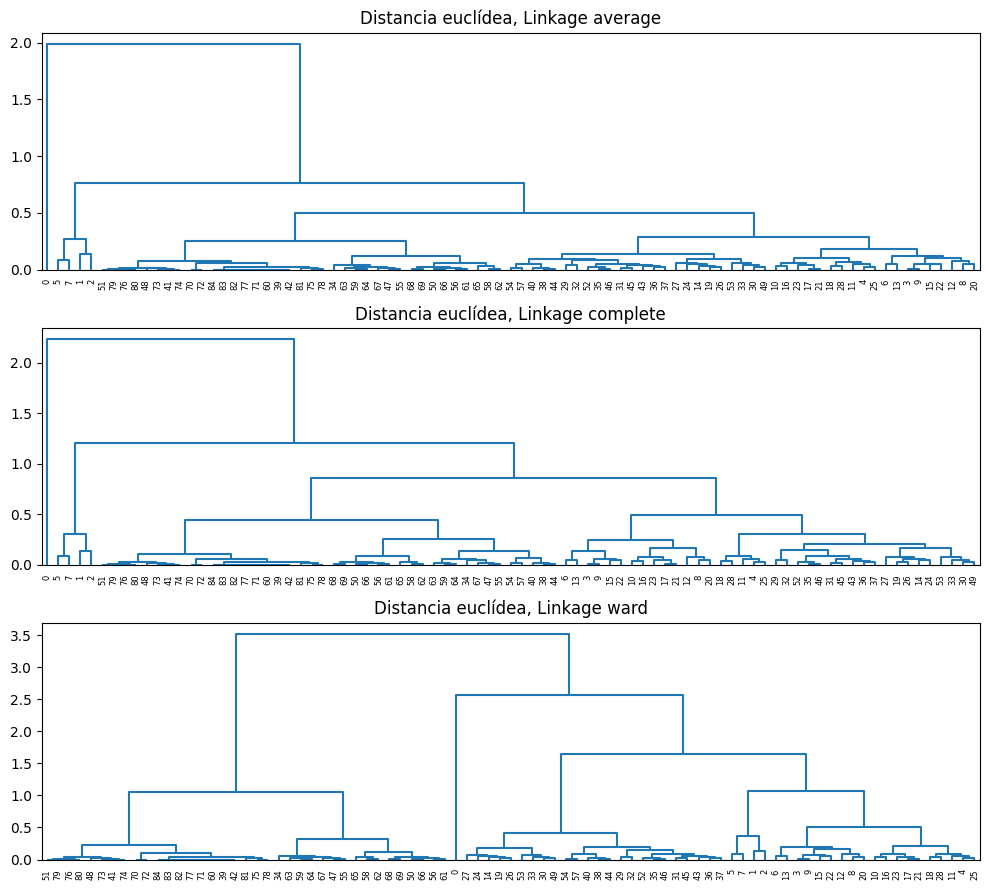

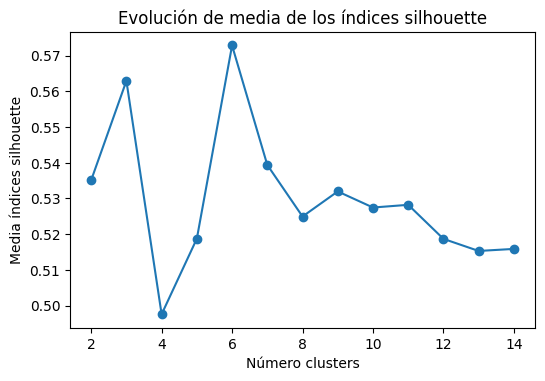

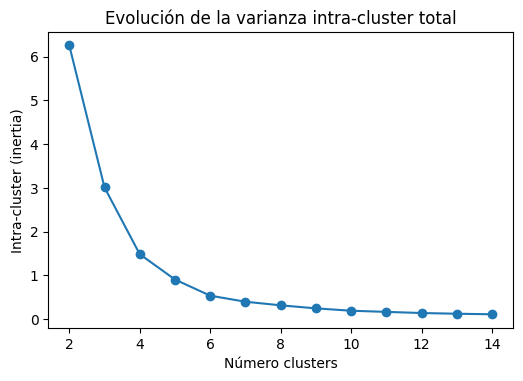

In [62]:
# Datos sin filtros
centralidad = grafo_1023_dict['centralidad']
all_x = encontrar_clusters(centralidad)

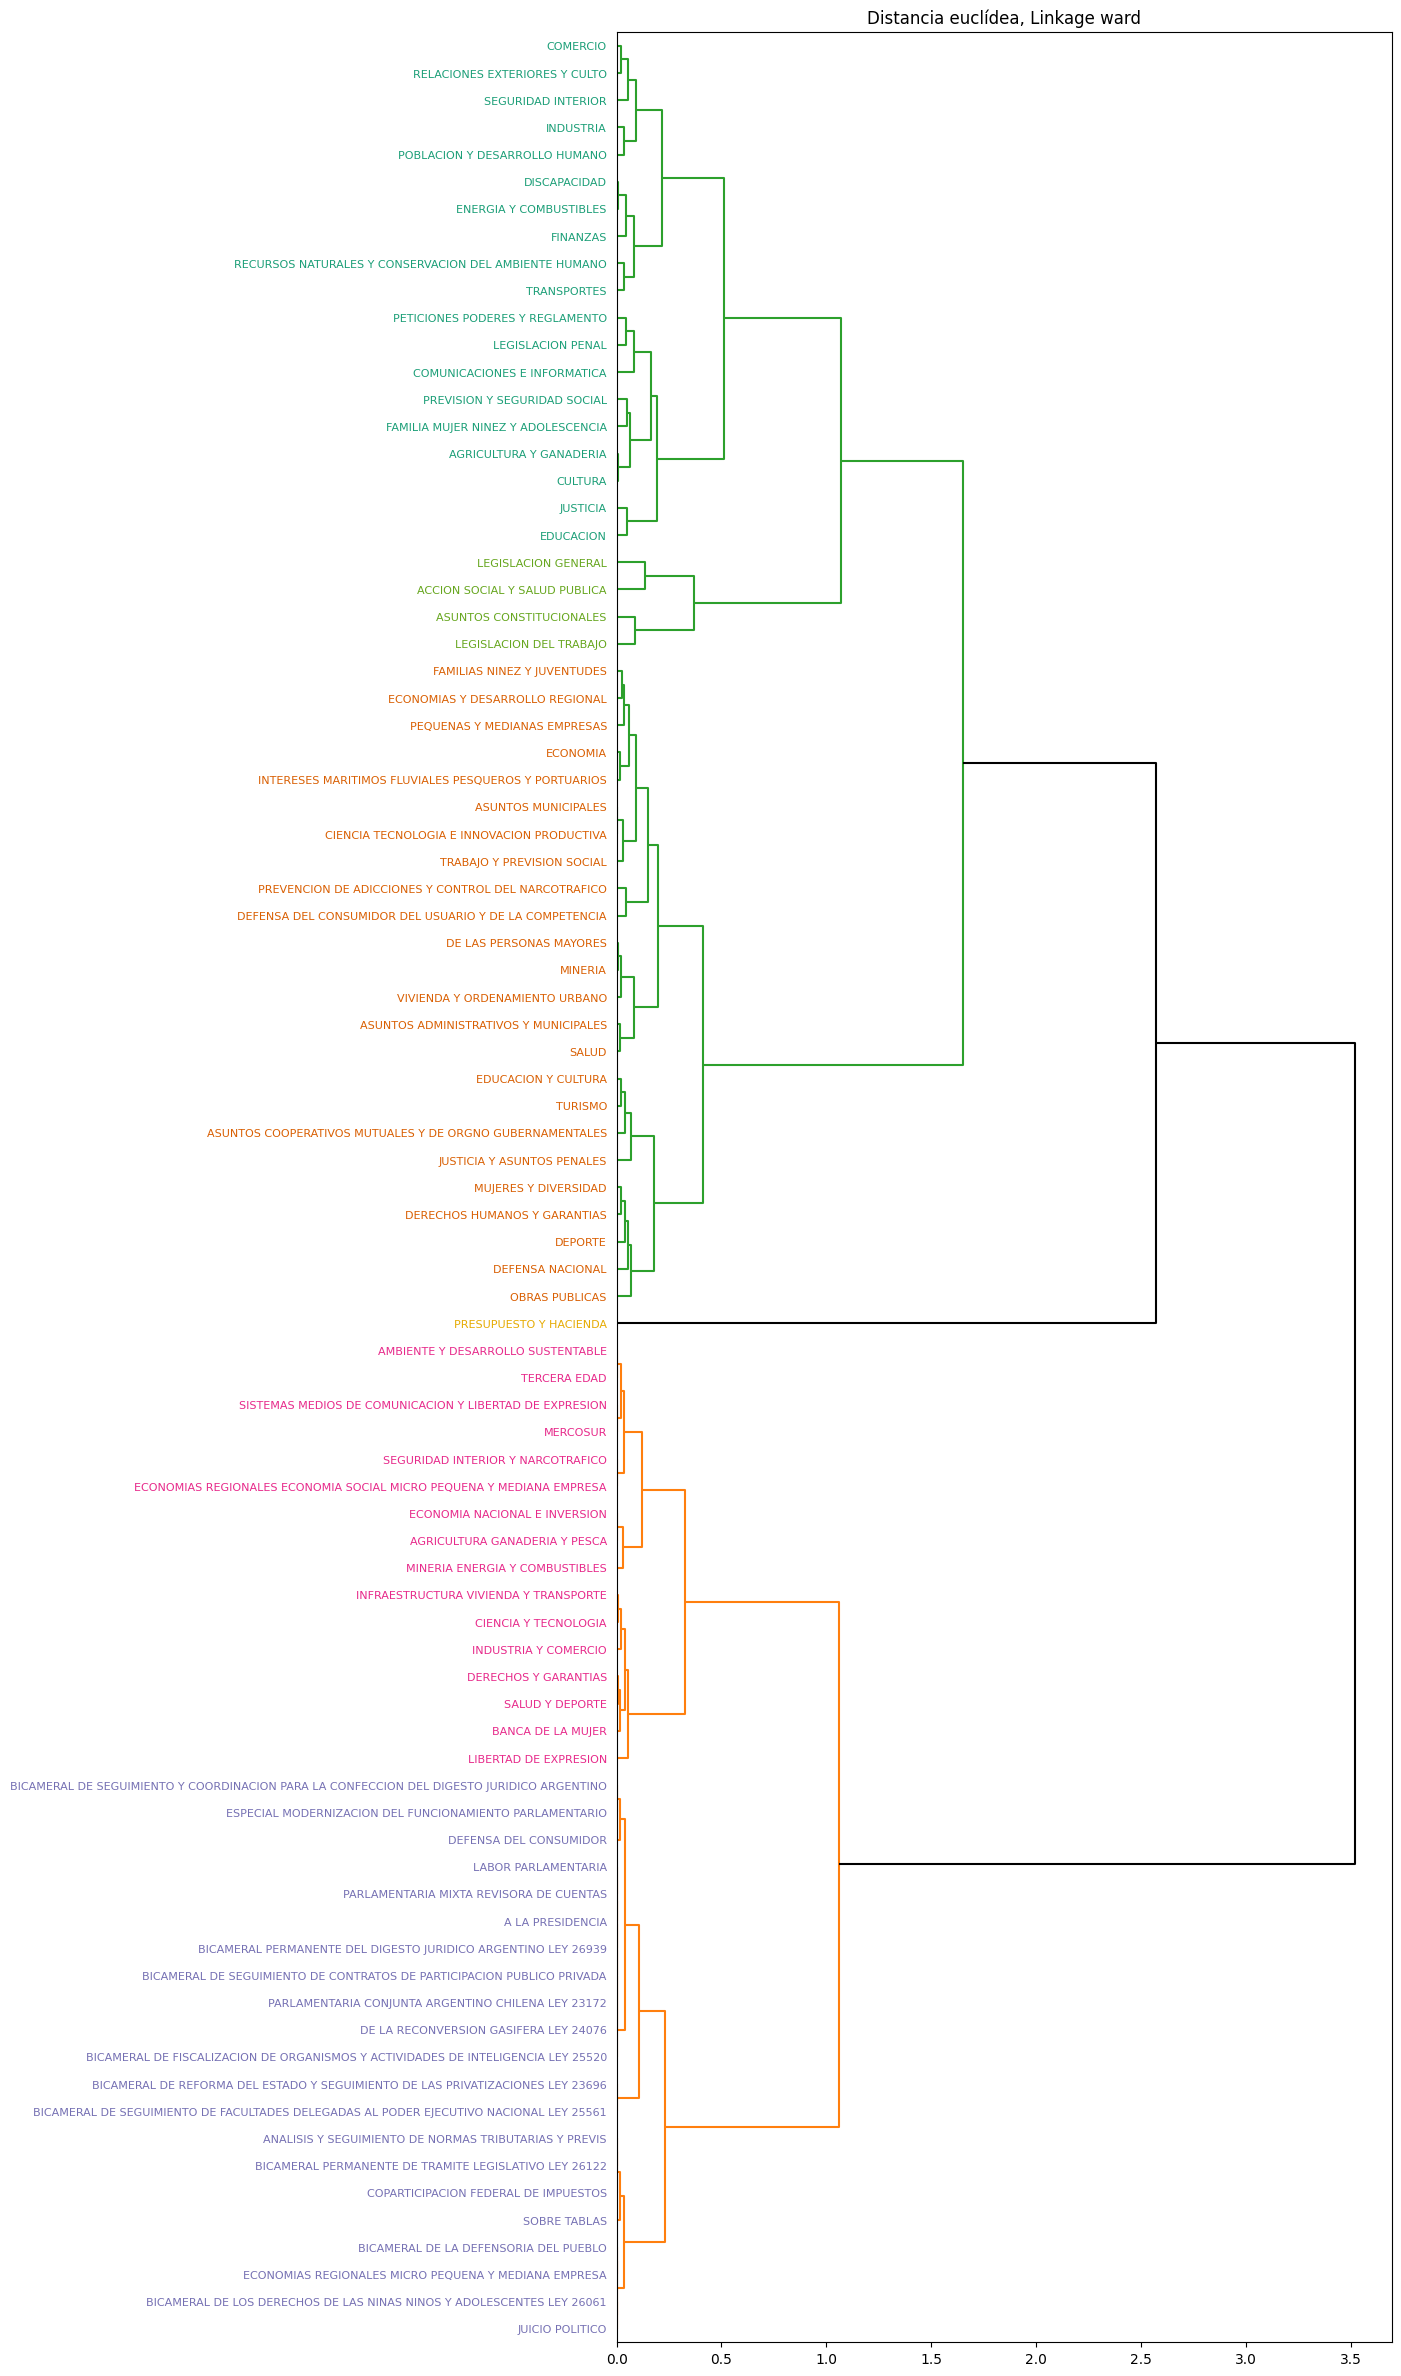

categ_agg_ward_k6
1    24
2    21
0    19
3    16
4     4
5     1
Name: count, dtype: int64

In [63]:
# Creamos dataframe
k = 6
model = get_cluster(all_x,k)
aggmodel_df =  pd.DataFrame(model.labels_ ,index = all_x.index).reset_index()
aggmodel_df.columns = ['comision_nombre_norm','categ_agg_ward_k'+str(k)]
display(aggmodel_df['categ_agg_ward_k'+str(k)].value_counts())

#### COMISIONES PERMANENTES

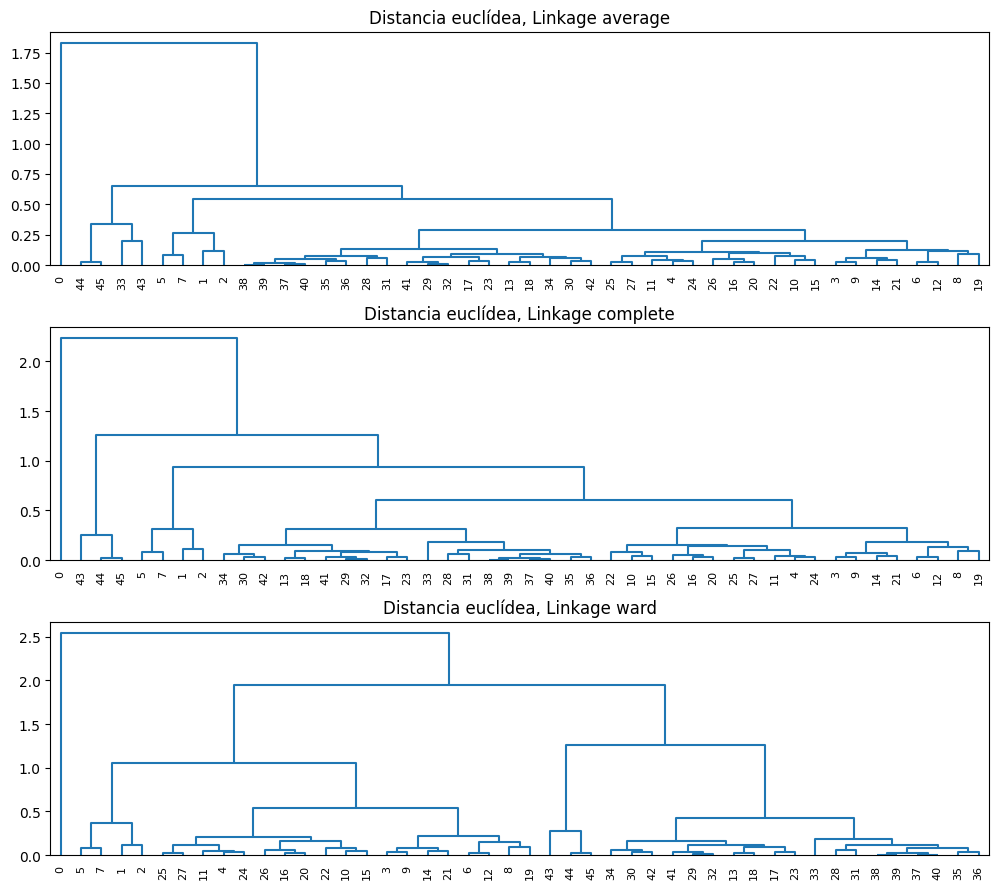

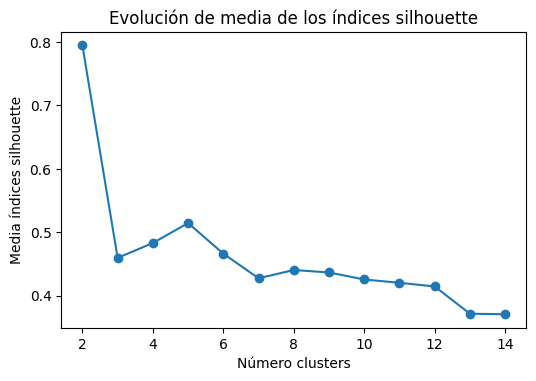

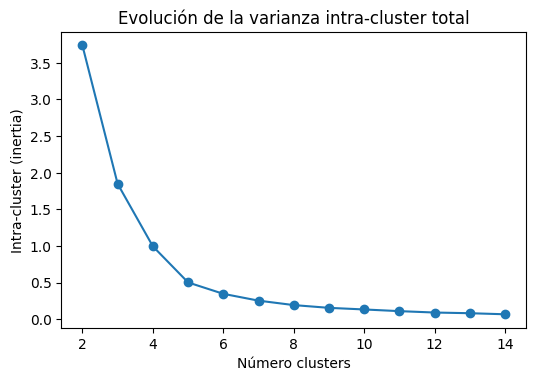

In [64]:
centralidad = grafo_1023_p_dict['centralidad'] #[['degree','betweenness','pagerank']]
all_p_x = encontrar_clusters(centralidad)

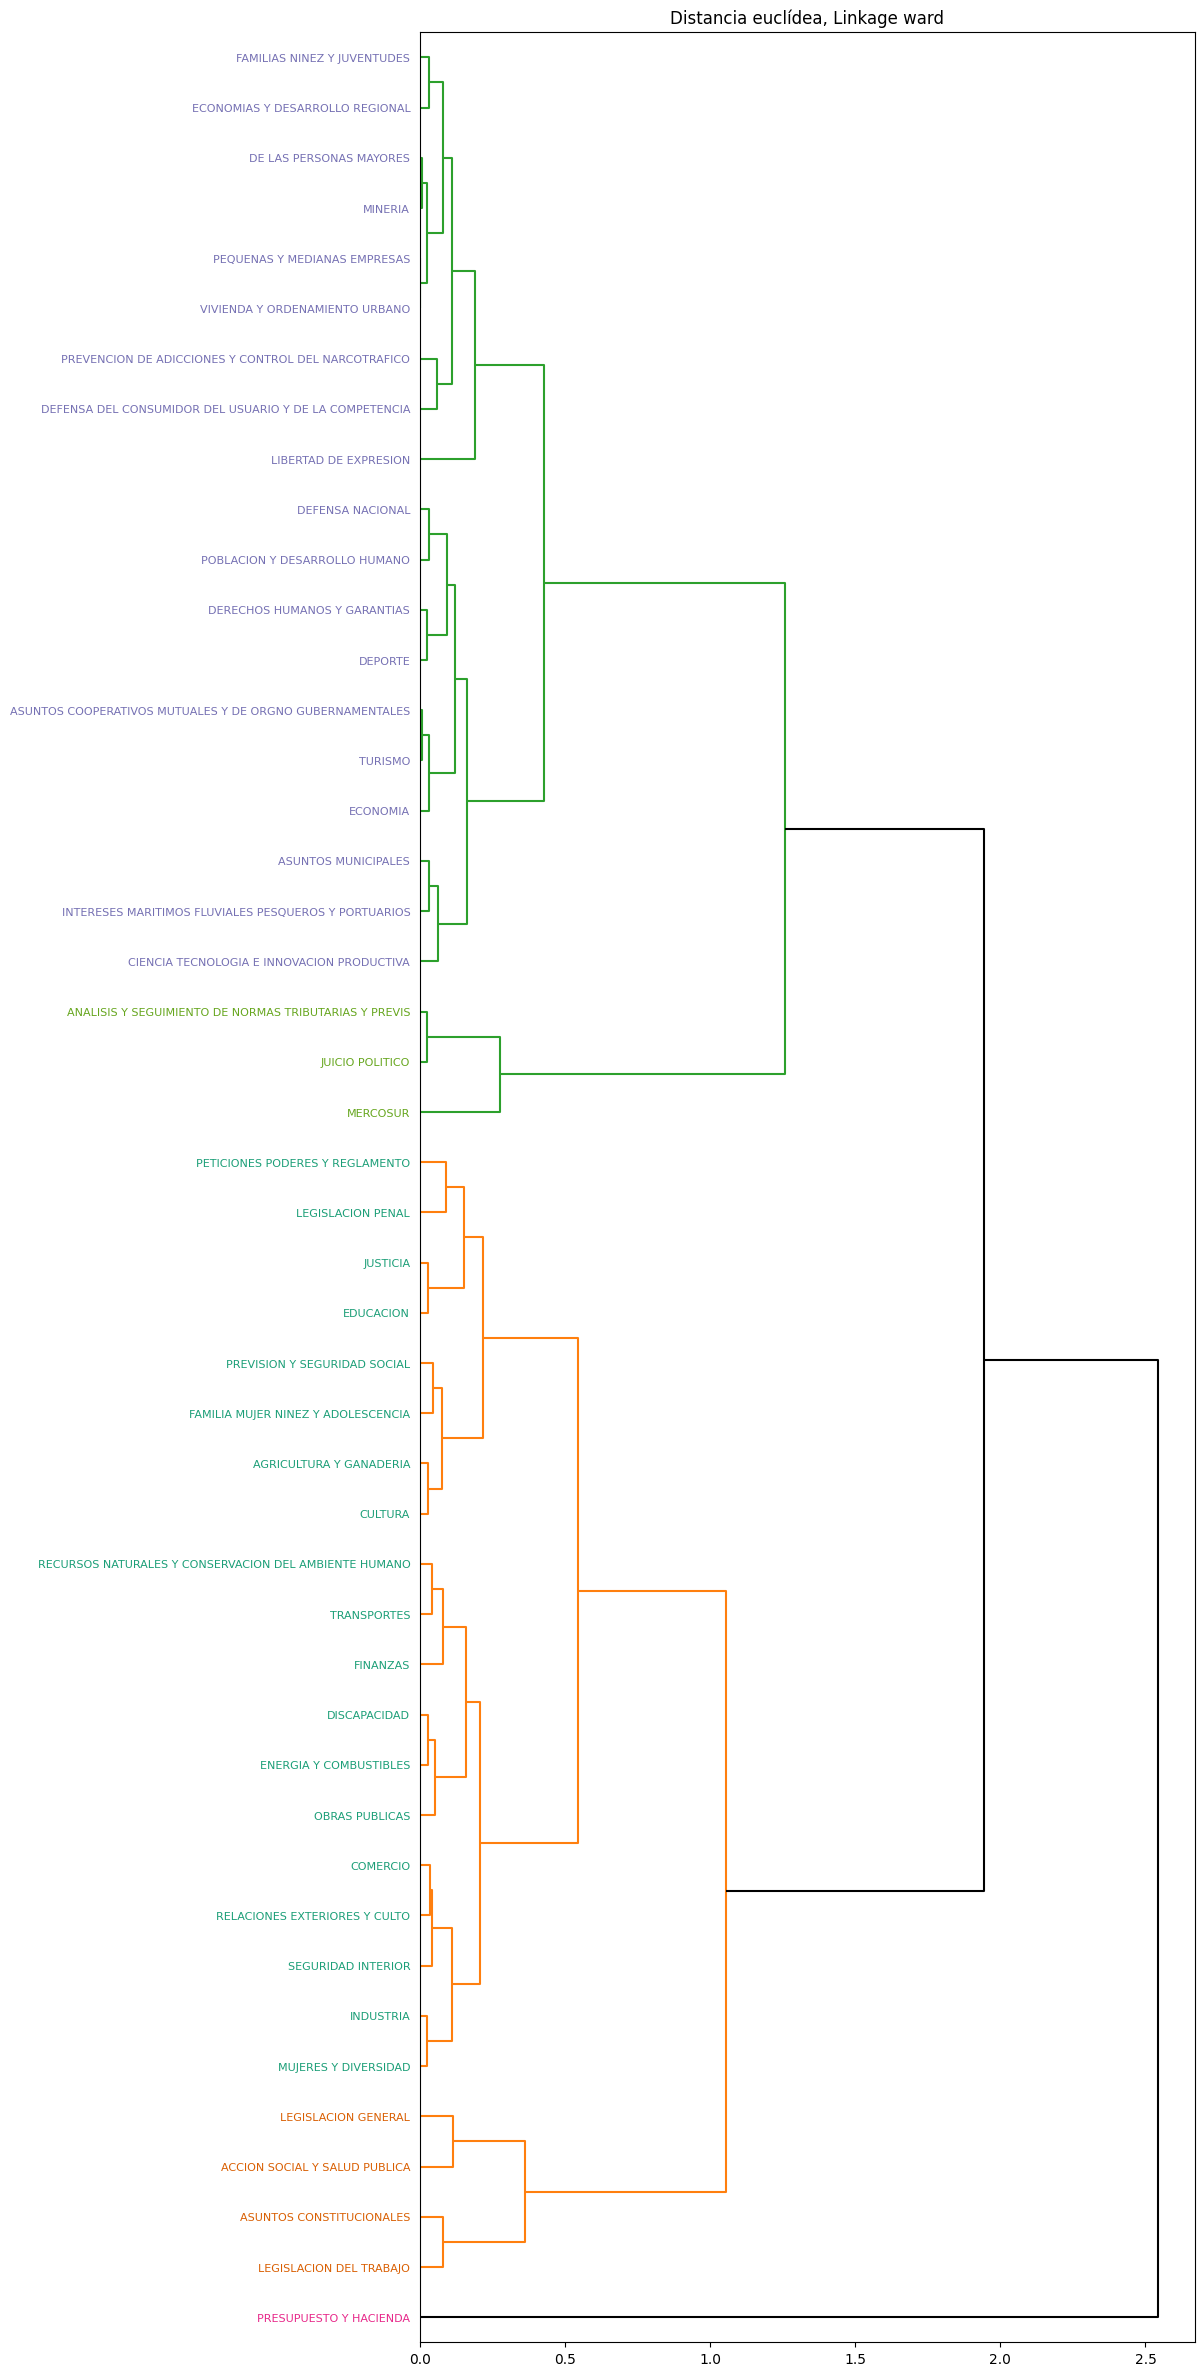

categ_agg_ward_k5
0    19
2    19
1     4
4     3
3     1
Name: count, dtype: int64

In [65]:
# Creamos dataframe
k = 5
model_p = get_cluster(all_p_x,k)
aggmodel_p_df =  pd.DataFrame(model_p.labels_ ,index = all_p_x.index).reset_index()
aggmodel_p_df.columns = ['comision_nombre_norm','categ_agg_ward_k'+str(k)]
display(aggmodel_p_df['categ_agg_ward_k'+str(k)].value_counts())

#### COMISION PERMANENTE Y PROYECTOS DE LEY

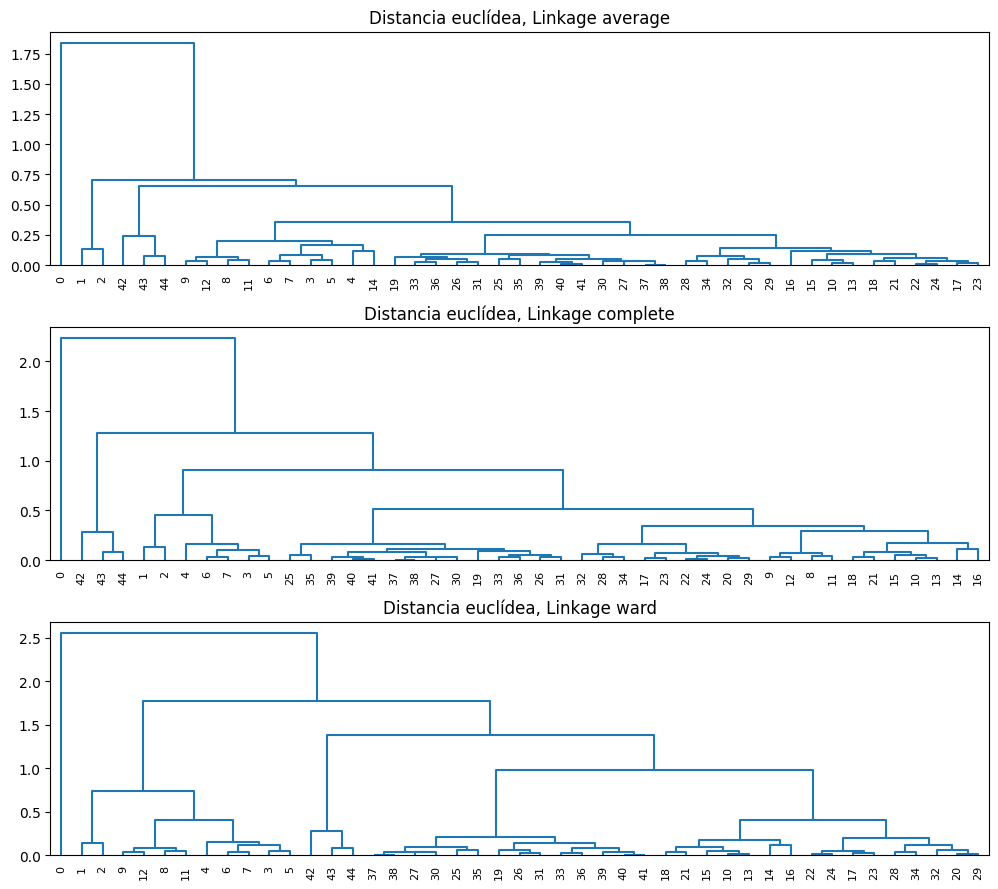

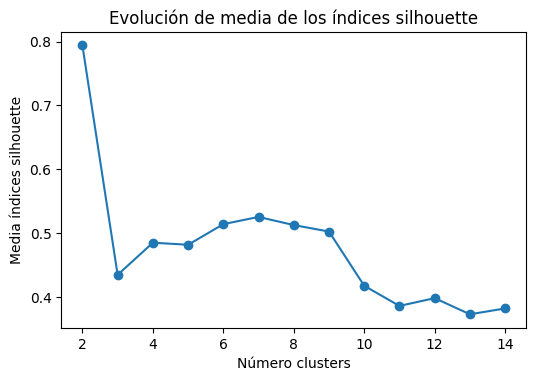

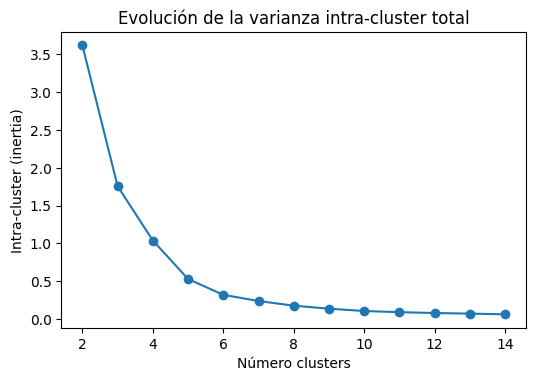

In [66]:
centralidad = grafo_1023_ley_p_dict['centralidad']#[['degree','betweenness','pagerank']]
all_ley_x = encontrar_clusters(centralidad)

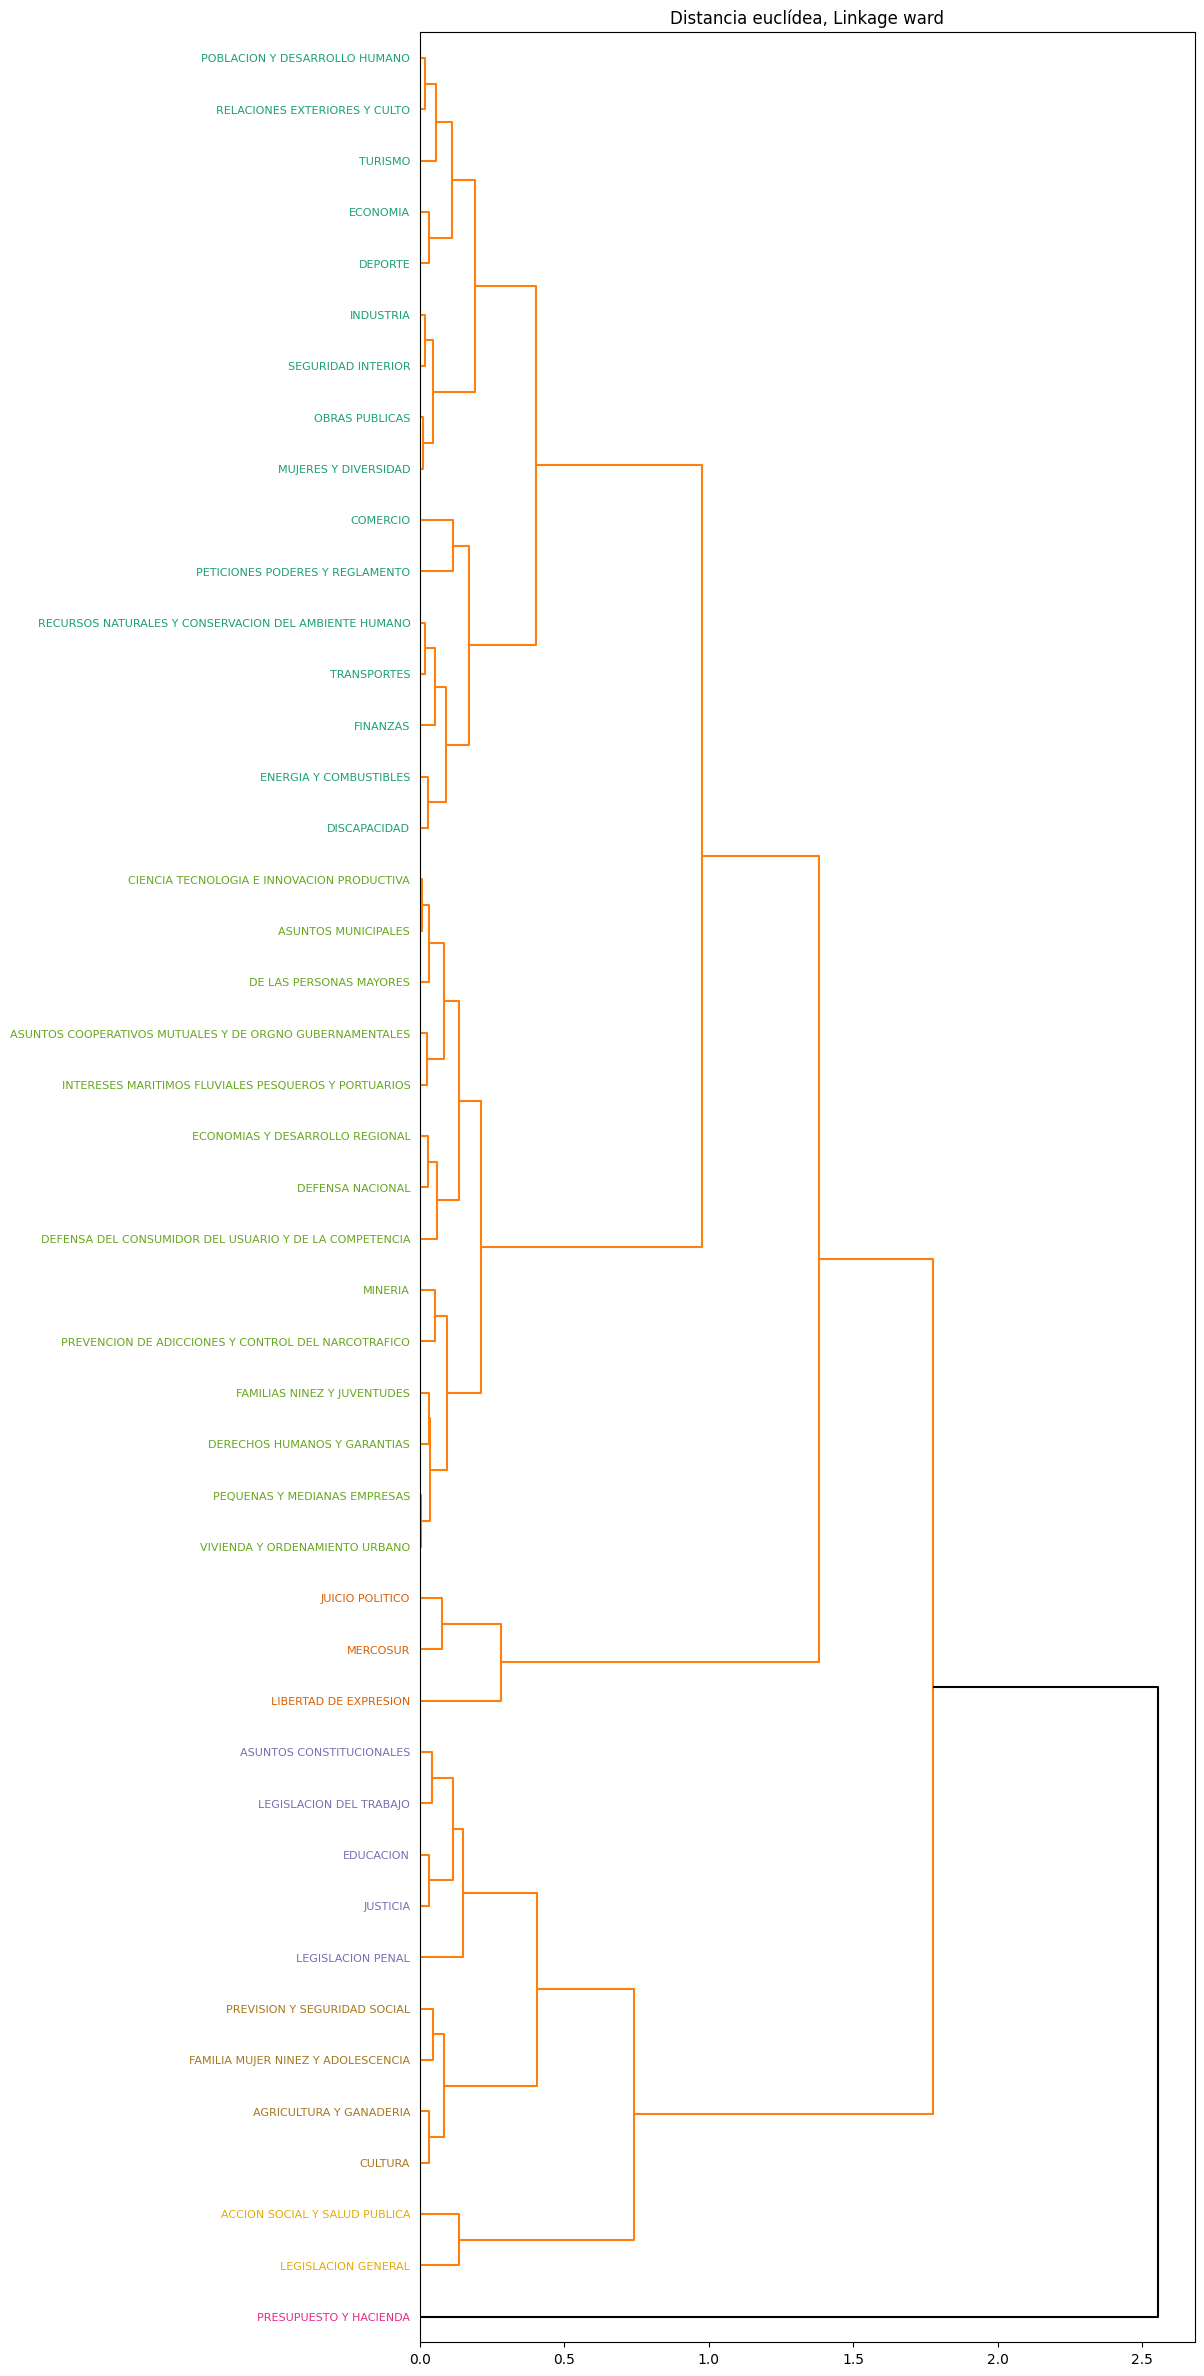

categ_agg_ward_k7
0    16
4    14
2     5
6     4
1     3
5     2
3     1
Name: count, dtype: int64

In [67]:
# Creamos dataframe
k = 7
model_p = get_cluster(all_ley_x,k)
aggmodel_p_df =  pd.DataFrame(model_p.labels_ ,index = all_ley_x.index).reset_index()
aggmodel_p_df.columns = ['comision_nombre_norm','categ_agg_ward_k'+str(k)]
display(aggmodel_p_df['categ_agg_ward_k'+str(k)].value_counts())

### SALUD

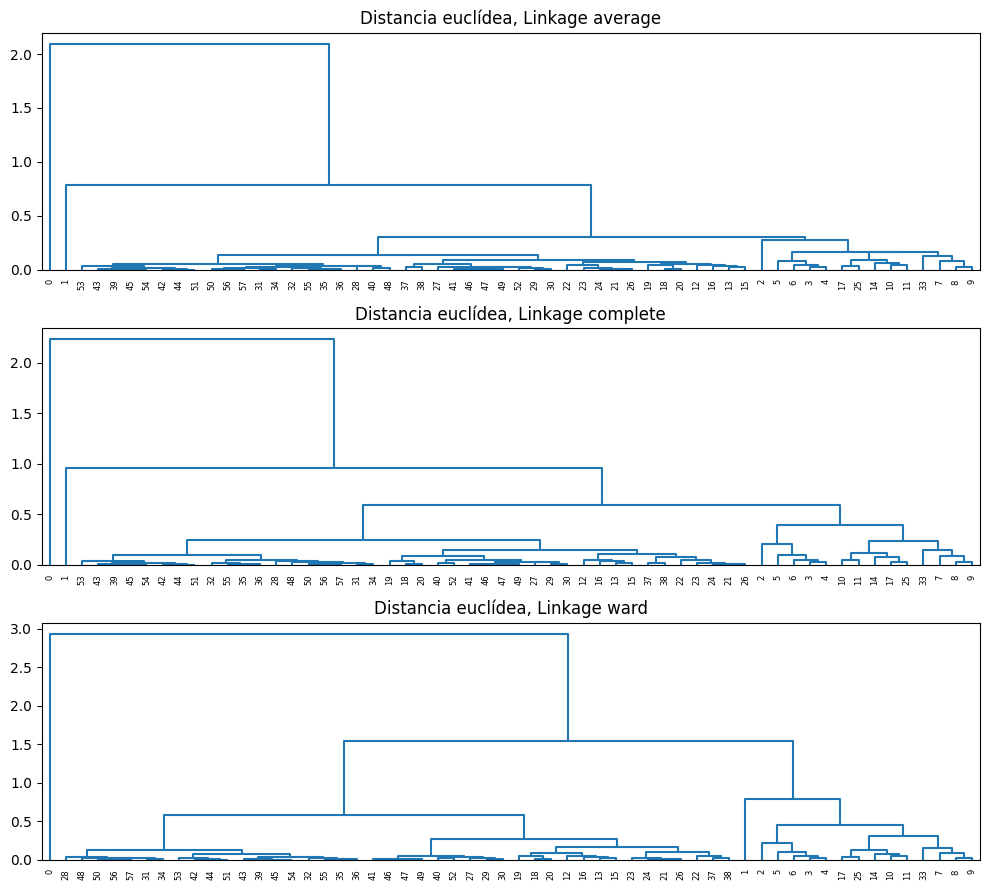

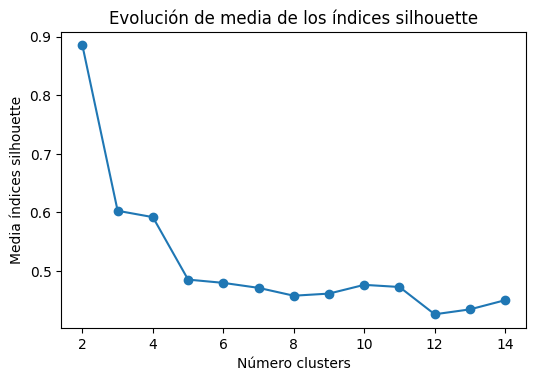

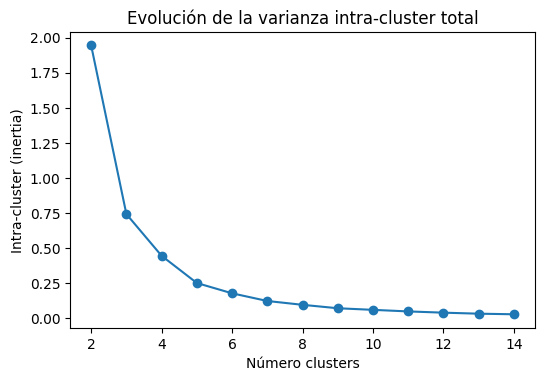

In [68]:
centralidad = grafo_1023_s_dict['centralidad'] #[['degree','betweenness','pagerank']]
#centralidad[~centralidad.index.isin(['ACCION SOCIAL Y SALUD PUBLICA', 'SALUD', 'SALUD Y DEPORTE'])].index
all_s_x = encontrar_clusters(centralidad[~centralidad.index.isin(['ACCION SOCIAL Y SALUD PUBLICA', 'SALUD', 'SALUD Y DEPORTE'])])

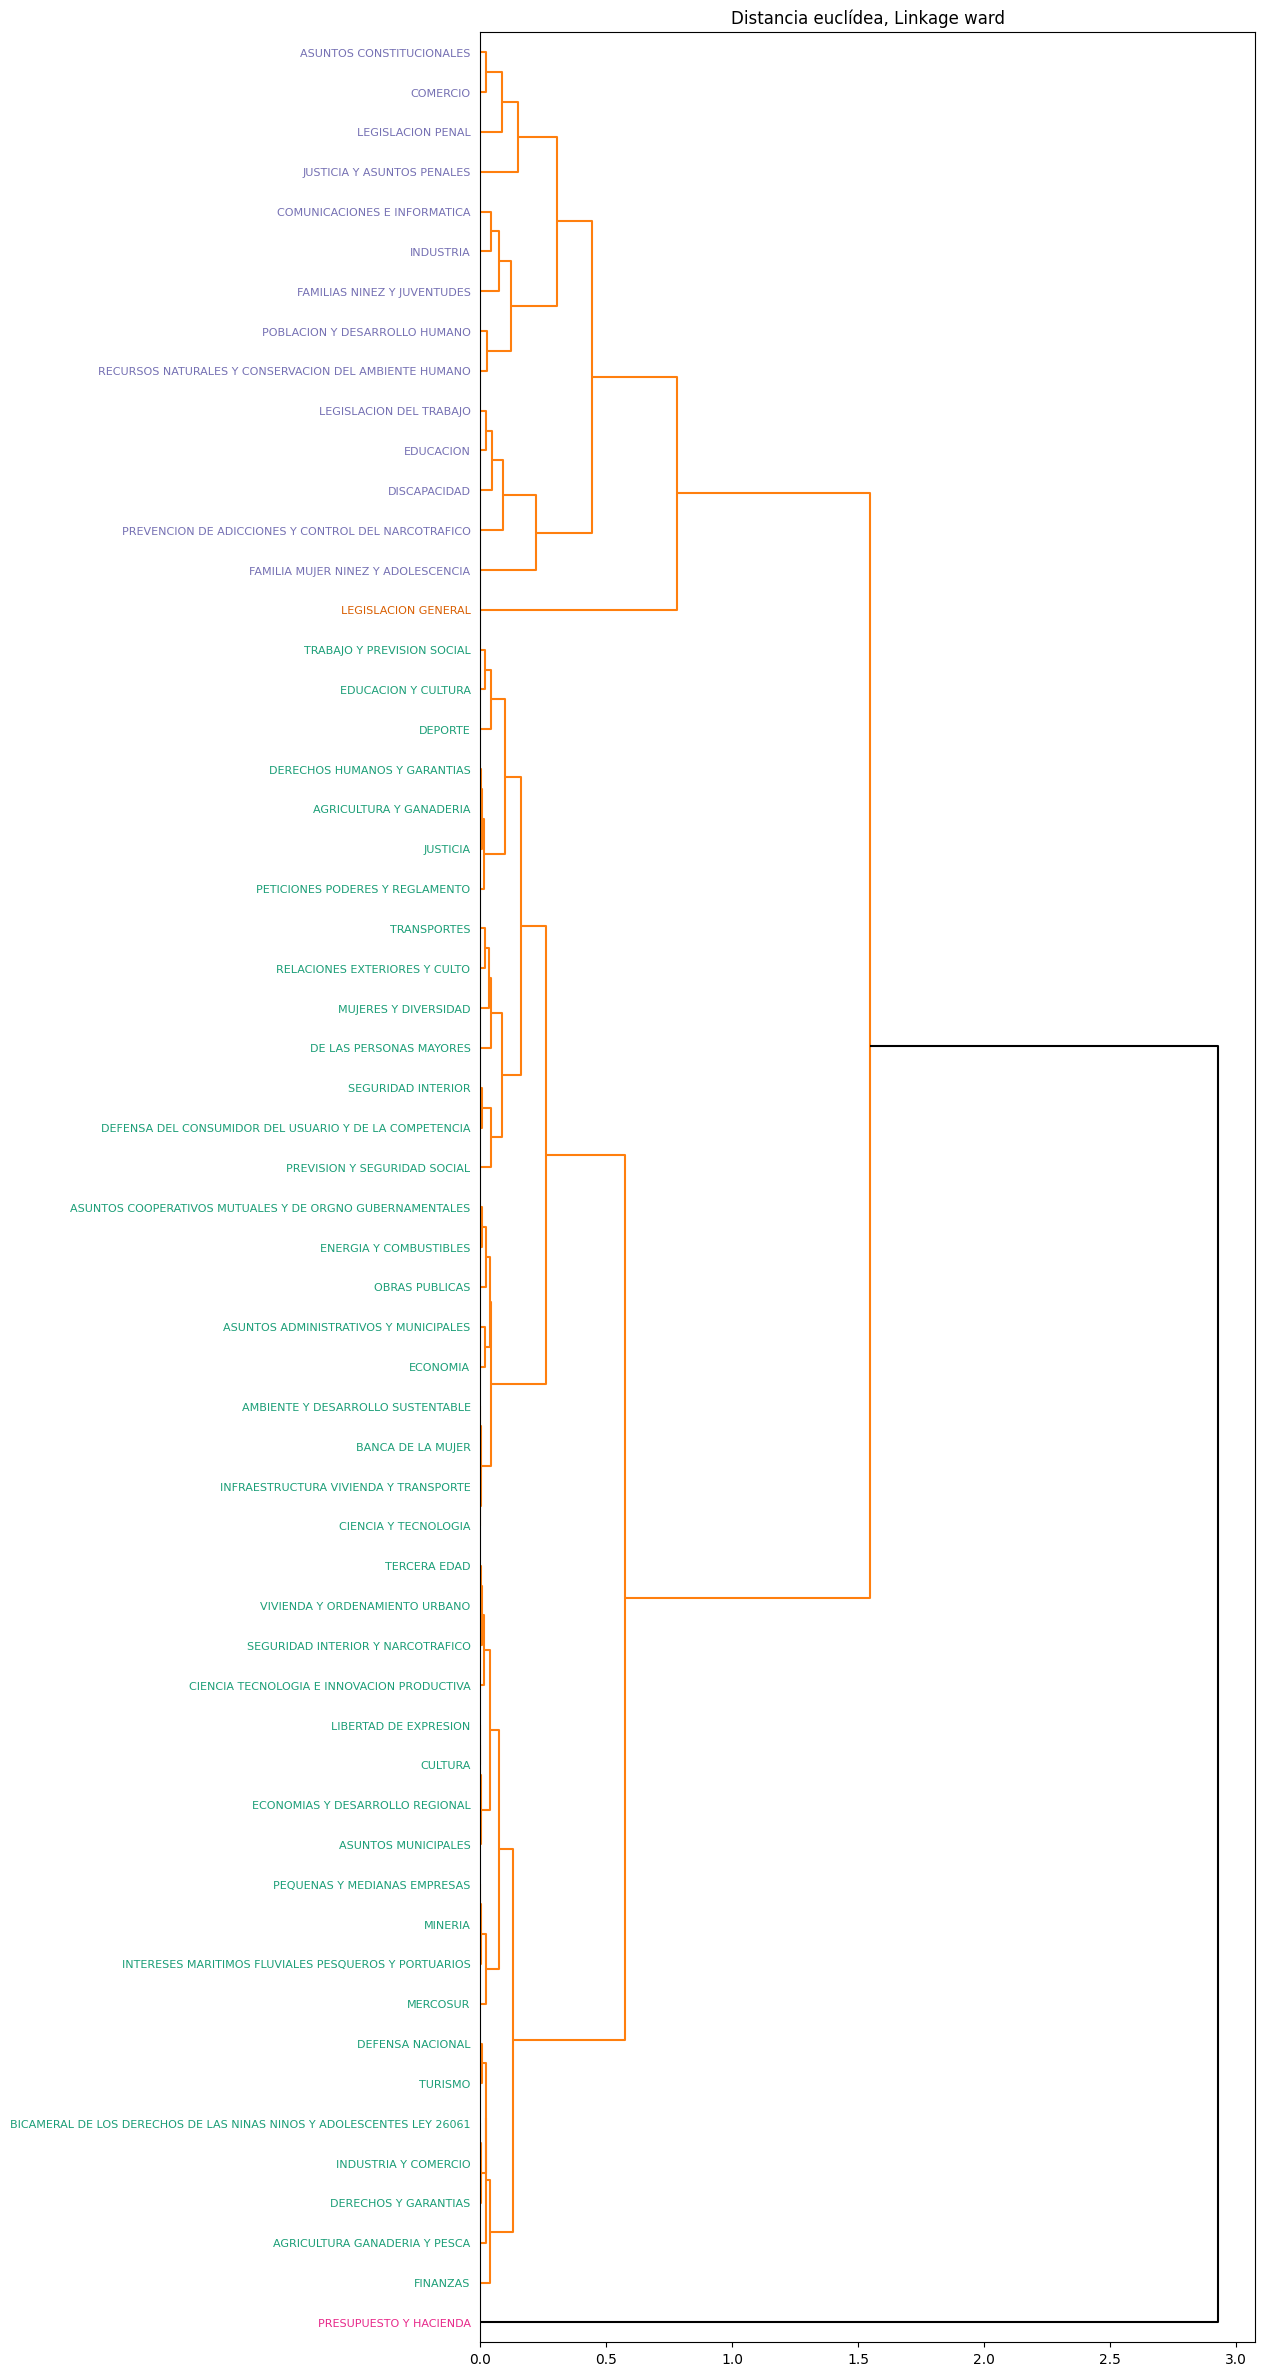

categ_agg_ward_k4
0    42
2    14
1     1
3     1
Name: count, dtype: int64

In [69]:
# Creamos dataframe
k = 4
model_p = get_cluster(all_s_x,k)
aggmodel_p_df =  pd.DataFrame(model_p.labels_ ,index = all_s_x.index).reset_index()
aggmodel_p_df.columns = ['comision_nombre_norm','categ_agg_ward_k'+str(k)]
display(aggmodel_p_df['categ_agg_ward_k'+str(k)].value_counts())

### 2.1 - Identificando clustering mediantes red de comisiones - salud

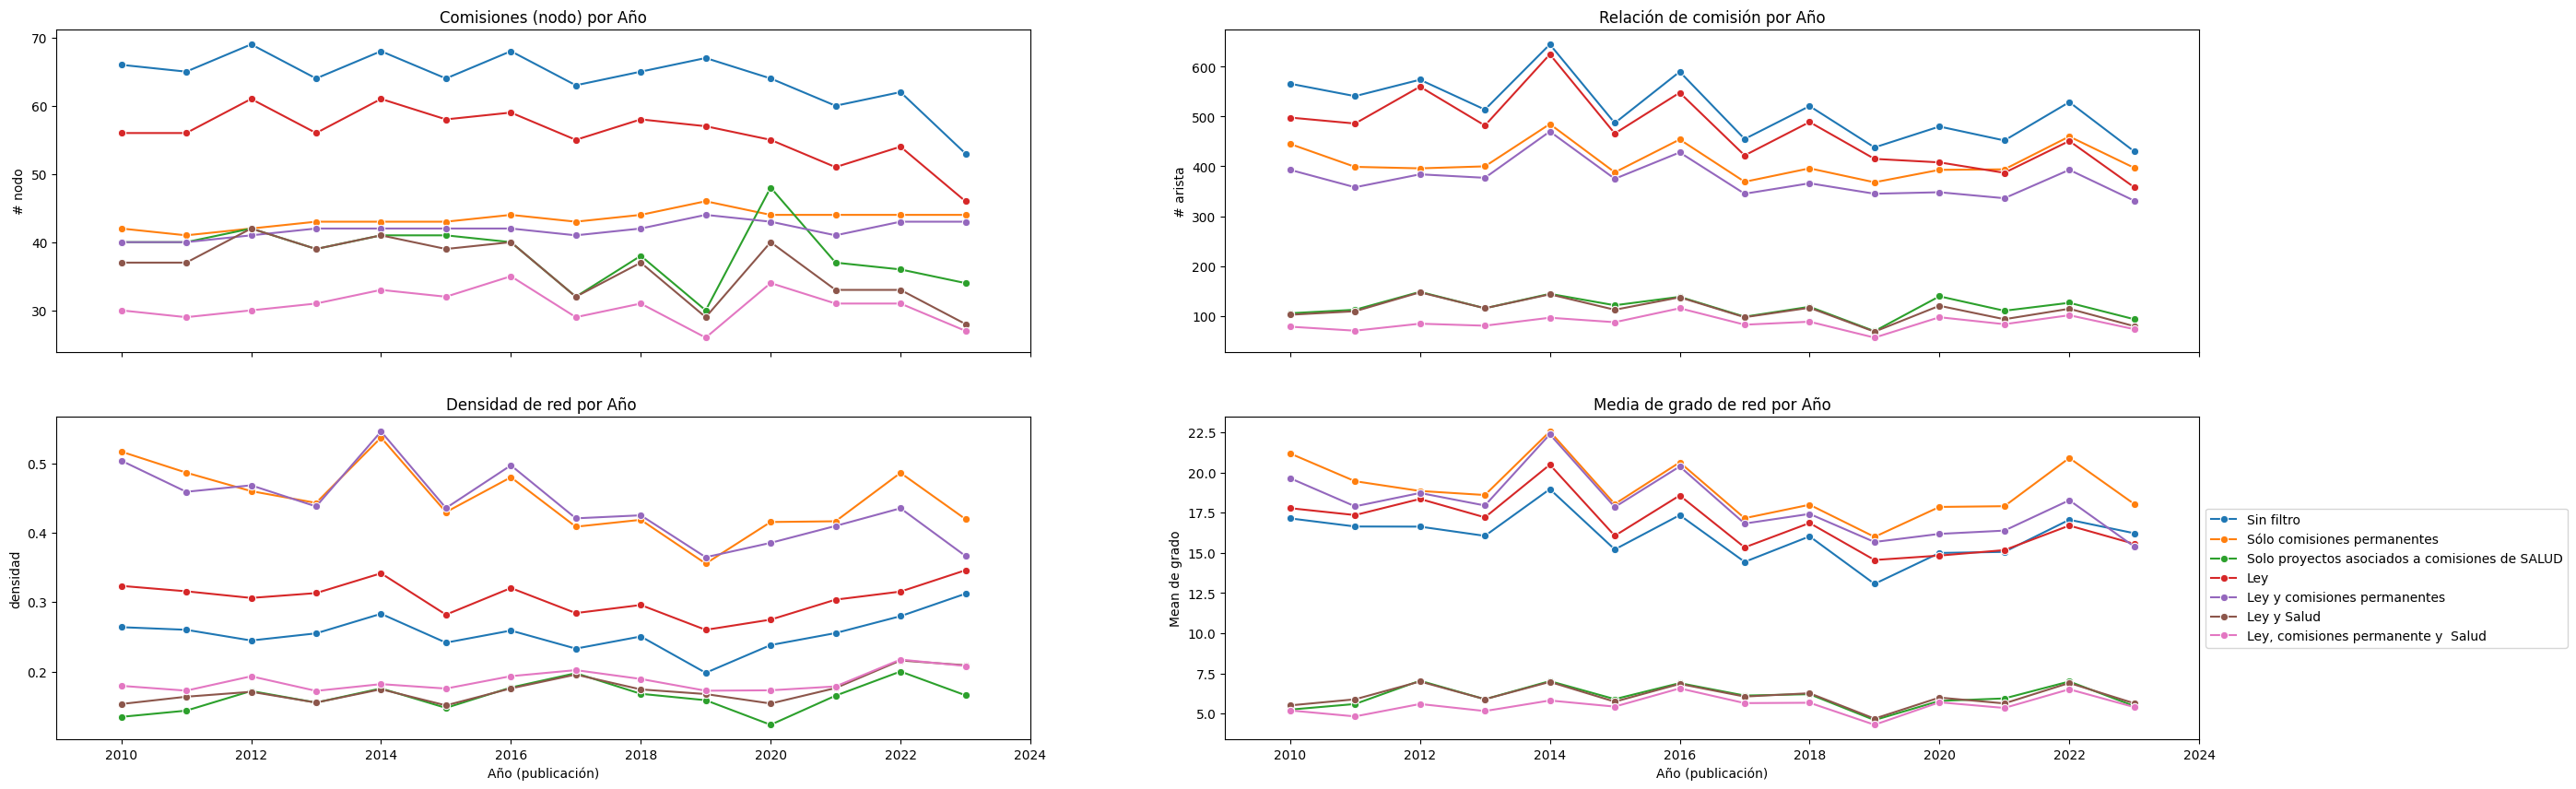

In [70]:
    f, axs = plt.subplots(2, 2, figsize=(30, 10), sharex = True)
    sns.lineplot(x=df['año'], y=df['# nodo'], estimator='sum', errorbar= None , data = df, hue='filtro',linestyle='-', ax = axs[0][0], marker='o')
    sns.lineplot(x=df['año'], y=df['# arista'], estimator='sum', errorbar= None, data = df ,hue='filtro', linestyle='-', ax = axs[0][1], marker='o')
    sns.lineplot(x=df['año'], y=df['densidad'], estimator='sum', errorbar= None, data = df ,hue='filtro', linestyle='-', ax = axs[1][0], marker='o')
    sns.lineplot(x=df['año'], y=df['mean grado'], estimator='sum', errorbar= None , data = df,hue='filtro', linestyle='-', ax = axs[1][1], marker='o')
    
    axs[0][0].set_title('Comisiones (nodo) por Año')
    axs[0][0].set_xlabel("Año (publicación)")
    axs[0][0].set_ylabel("# nodo")
    axs[0][0].get_legend().remove()
    
    axs[0][1].set_title('Relación de comisión por Año')
    axs[0][1].set_xlabel("Año (publicación)")
    axs[0][1].set_ylabel("# arista")
    axs[0][1].get_legend().remove()

    axs[1][0].set_title('Densidad de red por Año ')
    axs[1][0].set_xlabel("Año (publicación)")
    axs[1][0].set_ylabel("densidad")
    axs[1][0].get_legend().remove()

    axs[1][1].set_title('Media de grado de red por Año')
    axs[1][1].set_xlabel("Año (publicación)")
    axs[1][1].set_ylabel("Mean de grado")
    

    axs[1][1].set_xlim(2009, 2024) 
    axs[1][1].legend(loc='center left', bbox_to_anchor=(1, 0.5))


#### Entre [2010-2019]

** Creación de grafo desde : (572, 4)
Número de nodos en el gráfo: 58
Número de aristas en el gráfo: 339
Densidad del grafo 0.20508166969147004
********** Métricas de Centralidad de la Red **********


count      mean       std       min       25%       50%  \
degree        58.0  1.865234  5.691406  0.016296  0.134369  0.431152   
centrality    58.0  0.205082  0.193394  0.017544  0.087719  0.140351   
eigenvector   58.0  0.046892  0.123719  0.000679  0.003023  0.010887   
pagerank      58.0  0.017241  0.044914  0.002698  0.003678  0.006139   
betweenness   58.0  0.046892  0.123719  0.000679  0.003023  0.010887   

                  75%        max  
degree       0.911621  36.750000  
centrality   0.258772   1.000000  
eigenvector  0.023923   0.677909  
pagerank     0.010606   0.296675  
betweenness  0.023923   0.677909

Nodos con mayor degree: ['ACCION SOCIAL Y SALUD PUBLICA', 'PRESUPUESTO Y HACIENDA', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA', 'LEGISLACION GENERAL', 'LEGISLACION DEL TRABAJO', 'PREVENCION DE ADICCIONES Y CONTROL DEL NARCOTRAFICO']
Nodos con mayor centrality: ['ACCION SOCIAL Y SALUD PUBLICA', 'PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'JUSTICIA Y ASUNTOS PENALES', 'SALUD', 'SALUD Y DEPORTE']
Nodos con mayor eigenvector: ['ACCION SOCIAL Y SALUD PUBLICA', 'PRESUPUESTO Y HACIENDA', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA', 'LEGISLACION GENERAL', 'LEGISLACION DEL TRABAJO', 'PREVENCION DE ADICCIONES Y CONTROL DEL NARCOTRAFICO']
Nodos con mayor pagerank: ['ACCION SOCIAL Y SALUD PUBLICA', 'PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA', 'LEGISLACION DEL TRABAJO', 'PREVENCION DE ADICCIONES Y CONTROL DEL NARCOTRAFICO']
Nodos con mayor betweenness: ['ACCION SOCIAL Y SALUD PUBLICA', 'PRESUPUESTO Y HACIENDA', 'FAMILIA MUJER NINEZ Y ADOLESCENCIA', 'LEGISLACION GEN

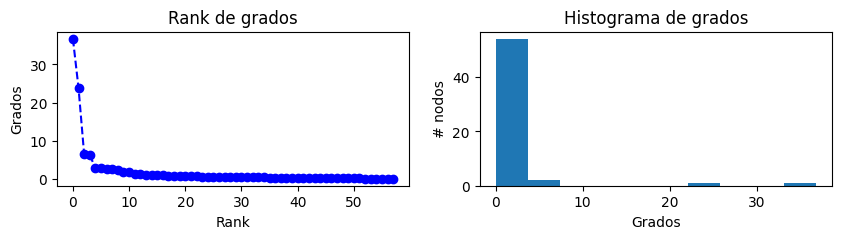

In [71]:
id_list = memoria_df.loc[(memoria_df['año']>2009) & (memoria_df['año']<2020) & (memoria_df['proyecto_girado_a_comisiones_SALUD']=='COMISIONES DE SALUD'),'proyecto_id'].unique()
edges_1019_df = edges_1023_df[(edges_1023_df['proyecto_id'].isin(id_list))]
grafo_1019_dict = get_dict_grafo(edges_1019_df)
for col in grafo_1019_dict['centralidad'].columns:
    top_nodos = grafo_1019_dict['centralidad'][~grafo_1019_dict['centralidad'].index.isin(['ACCION SOCIAL Y SALUD PUBLICA', 'SALUD', 'SALUD Y DEPORTE'])][col].sort_values(ascending=False).head(6).index.to_list()
    print(f"Nodos con mayor {col}: {top_nodos}")

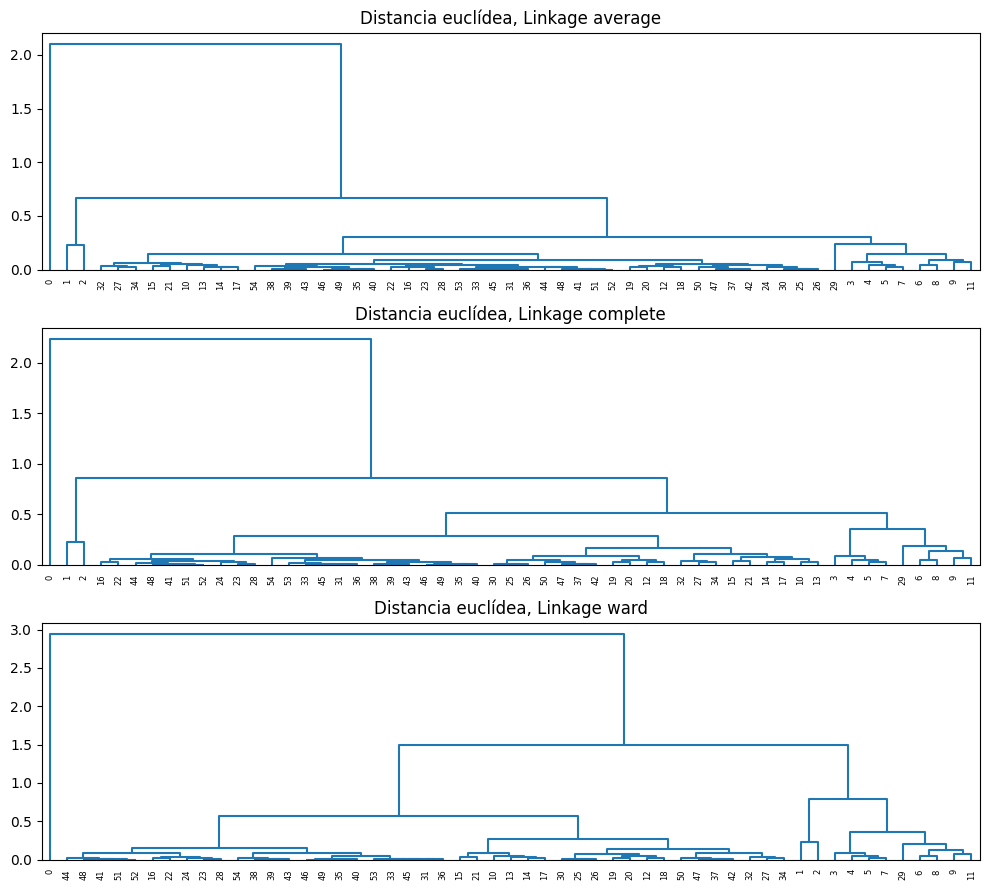

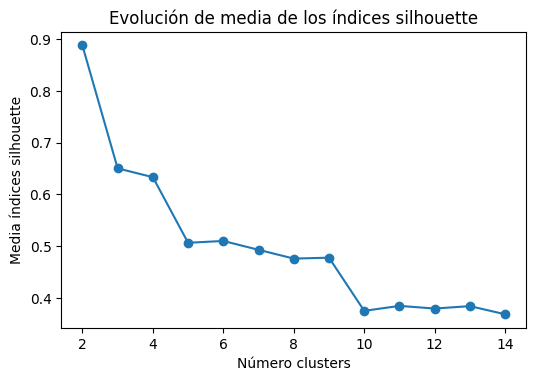

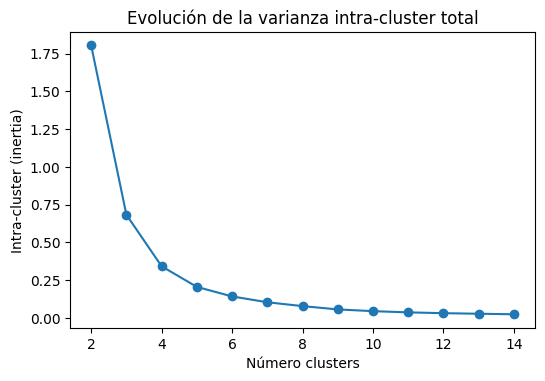

In [72]:
centralidad = grafo_1019_dict['centralidad'] #[['degree','betweenness','pagerank']]
#centralidad[~centralidad.index.isin(['ACCION SOCIAL Y SALUD PUBLICA', 'SALUD', 'SALUD Y DEPORTE'])].index
all_s_x = encontrar_clusters(centralidad[~centralidad.index.isin(['ACCION SOCIAL Y SALUD PUBLICA', 'SALUD', 'SALUD Y DEPORTE'])])

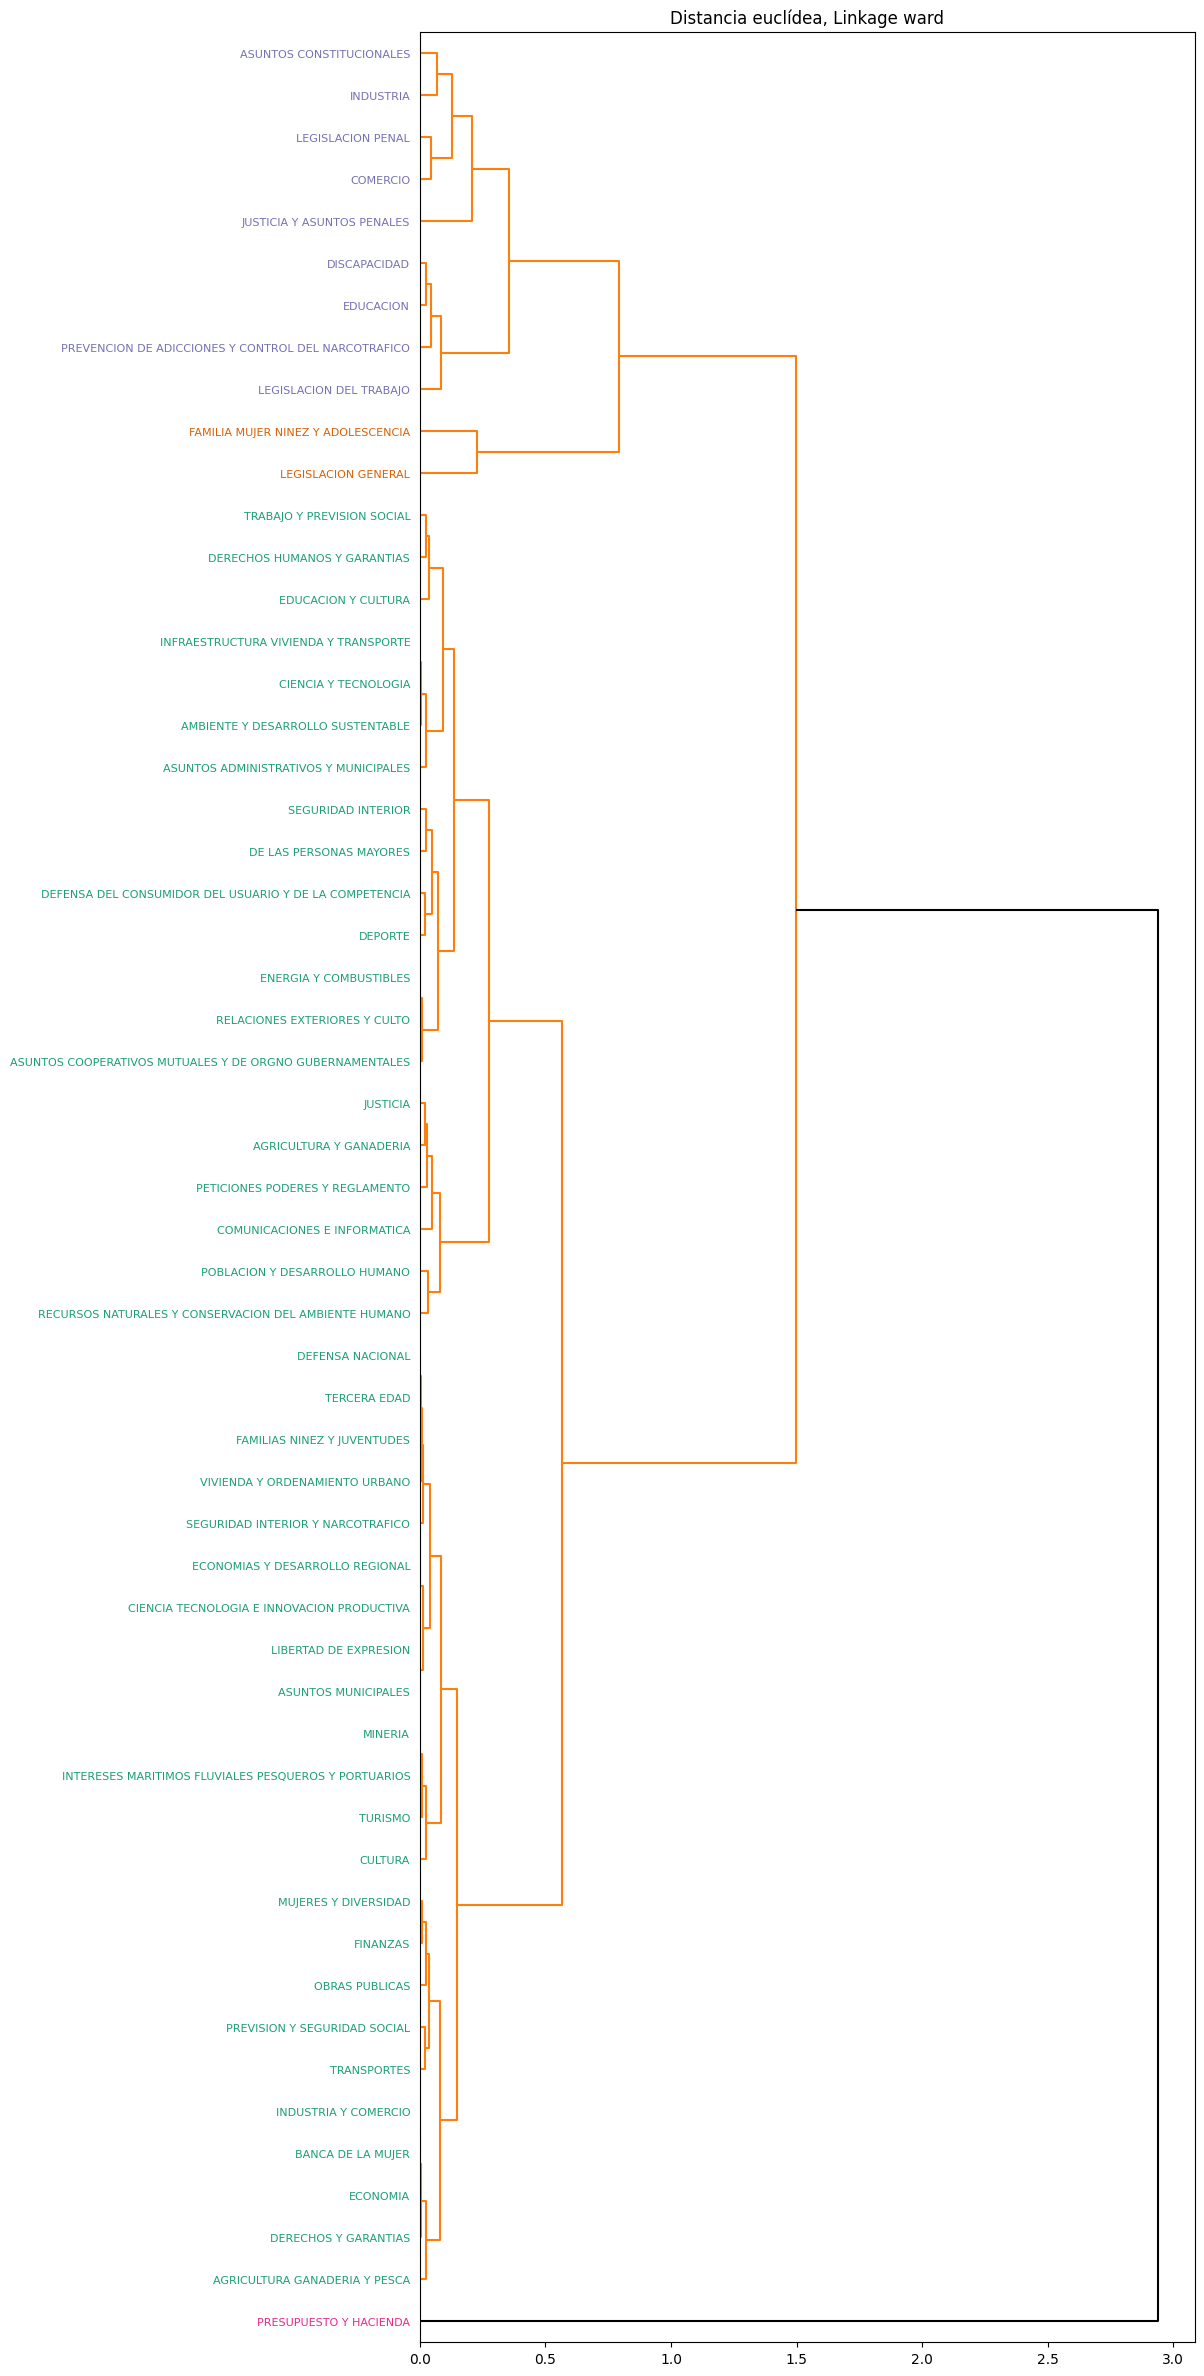

categ_agg_ward_k4
0    43
2     9
1     2
3     1
Name: count, dtype: int64

In [73]:
# Creamos dataframe
k = 4
model_p = get_cluster(all_s_x,k)
aggmodel_p_df =  pd.DataFrame(model_p.labels_ ,index = all_s_x.index).reset_index()
aggmodel_p_df.columns = ['comision_nombre_norm','categ_agg_ward_k'+str(k)]
display(aggmodel_p_df['categ_agg_ward_k'+str(k)].value_counts())

#### 2020

** Creación de grafo desde : (249, 4)
Número de nodos en el gráfo: 48
Número de aristas en el gráfo: 139
Densidad del grafo 0.12322695035460993
********** Métricas de Centralidad de la Red **********


count      mean       std       min       25%       50%  \
degree        48.0  1.641602  4.519531  0.074829  0.224365  0.523438   
centrality    48.0  0.123227  0.176489  0.021277  0.042553  0.085106   
eigenvector   48.0  0.058517  0.133340  0.004547  0.008754  0.019934   
pagerank      48.0  0.020833  0.050680  0.003853  0.005276  0.008437   
betweenness   48.0  0.058517  0.133340  0.004547  0.008754  0.019934   

                  75%        max  
degree       1.159424  27.968750  
centrality   0.111702   1.000000  
eigenvector  0.046600   0.691512  
pagerank     0.014851   0.320493  
betweenness  0.046600   0.691512

Nodos con mayor degree: ['ACCION SOCIAL Y SALUD PUBLICA', 'PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIAS NINEZ Y JUVENTUDES', 'INDUSTRIA', 'TRANSPORTES']
Nodos con mayor centrality: ['ACCION SOCIAL Y SALUD PUBLICA', 'PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'LEGISLACION PENAL', 'SALUD', 'FAMILIAS NINEZ Y JUVENTUDES']
Nodos con mayor eigenvector: ['ACCION SOCIAL Y SALUD PUBLICA', 'PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIAS NINEZ Y JUVENTUDES', 'TRANSPORTES', 'RELACIONES EXTERIORES Y CULTO']
Nodos con mayor pagerank: ['ACCION SOCIAL Y SALUD PUBLICA', 'PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIAS NINEZ Y JUVENTUDES', 'INDUSTRIA', 'TRANSPORTES']
Nodos con mayor betweenness: ['ACCION SOCIAL Y SALUD PUBLICA', 'PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIAS NINEZ Y JUVENTUDES', 'TRANSPORTES', 'RELACIONES EXTERIORES Y CULTO']
Nodos con mayor degree: ['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIAS NINEZ Y JUVENTUDES', 'INDUST

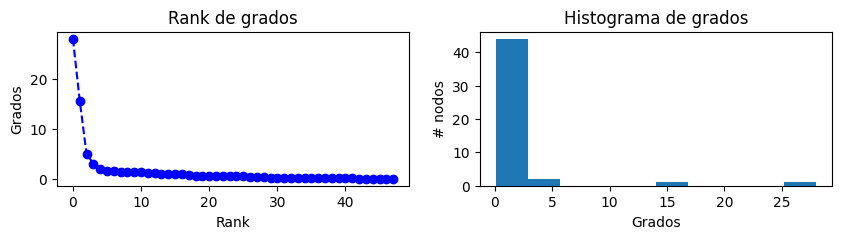

In [74]:
id_list = memoria_df.loc[(memoria_df['año']==2020) & (memoria_df['proyecto_girado_a_comisiones_SALUD']=='COMISIONES DE SALUD'),'proyecto_id'].unique()
edges_20_df = edges_1023_df[(edges_1023_df['proyecto_id'].isin(id_list))]
grafo_20_dict = get_dict_grafo(edges_20_df)
for col in grafo_20_dict['centralidad'].columns:
    top_nodos = grafo_20_dict['centralidad'][~grafo_20_dict['centralidad'].index.isin(['ACCION SOCIAL Y SALUD PUBLICA', 'SALUD', 'SALUD Y DEPORTE'])][col].sort_values(ascending=False).head(6).index.to_list()
    print(f"Nodos con mayor {col}: {top_nodos}")

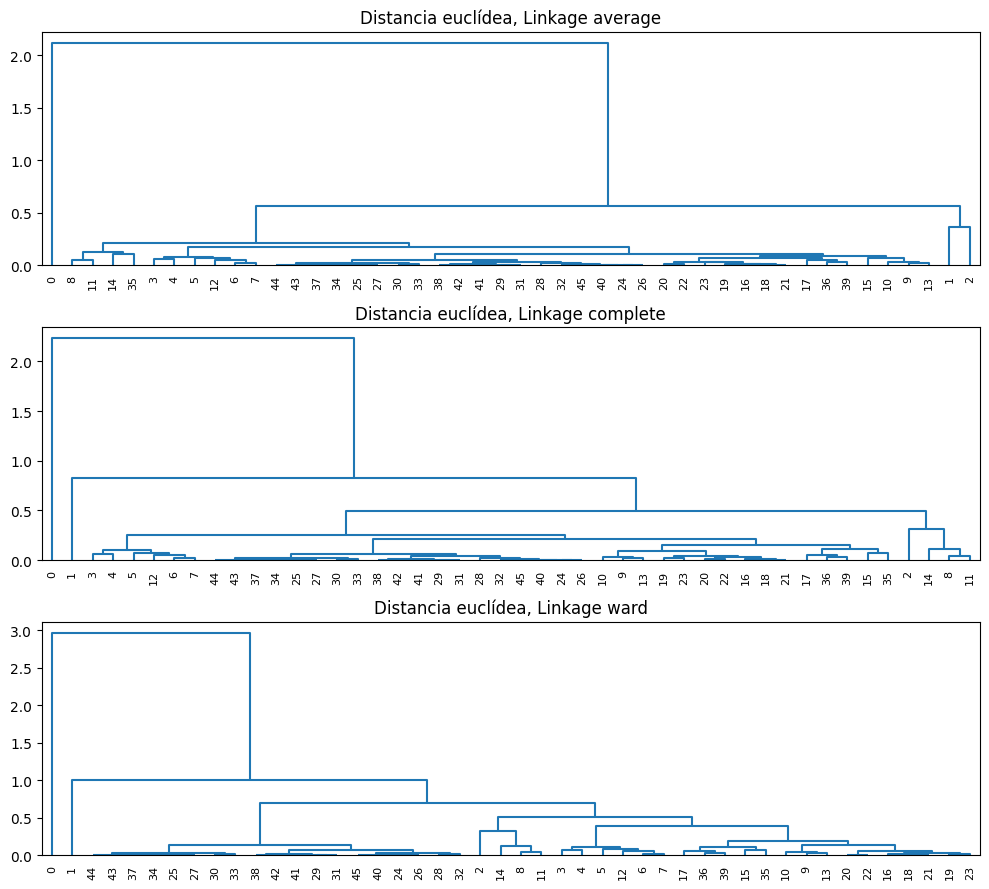

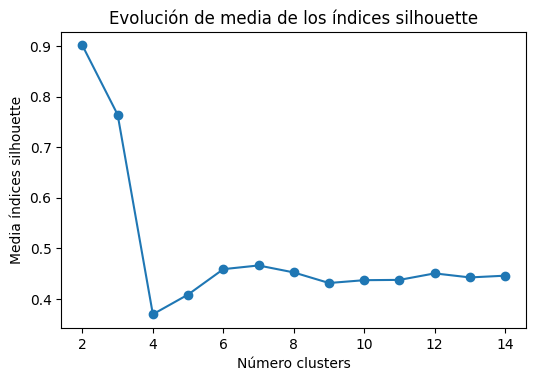

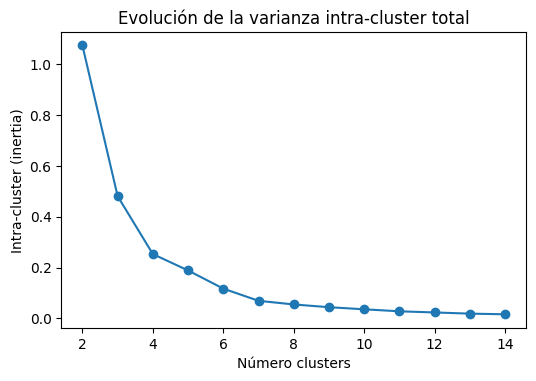

In [75]:
centralidad = grafo_20_dict['centralidad'] #[['degree','betweenness','pagerank']]
#centralidad[~centralidad.index.isin(['ACCION SOCIAL Y SALUD PUBLICA', 'SALUD', 'SALUD Y DEPORTE'])].index
all_s_x = encontrar_clusters(centralidad[~centralidad.index.isin(['ACCION SOCIAL Y SALUD PUBLICA', 'SALUD', 'SALUD Y DEPORTE'])])

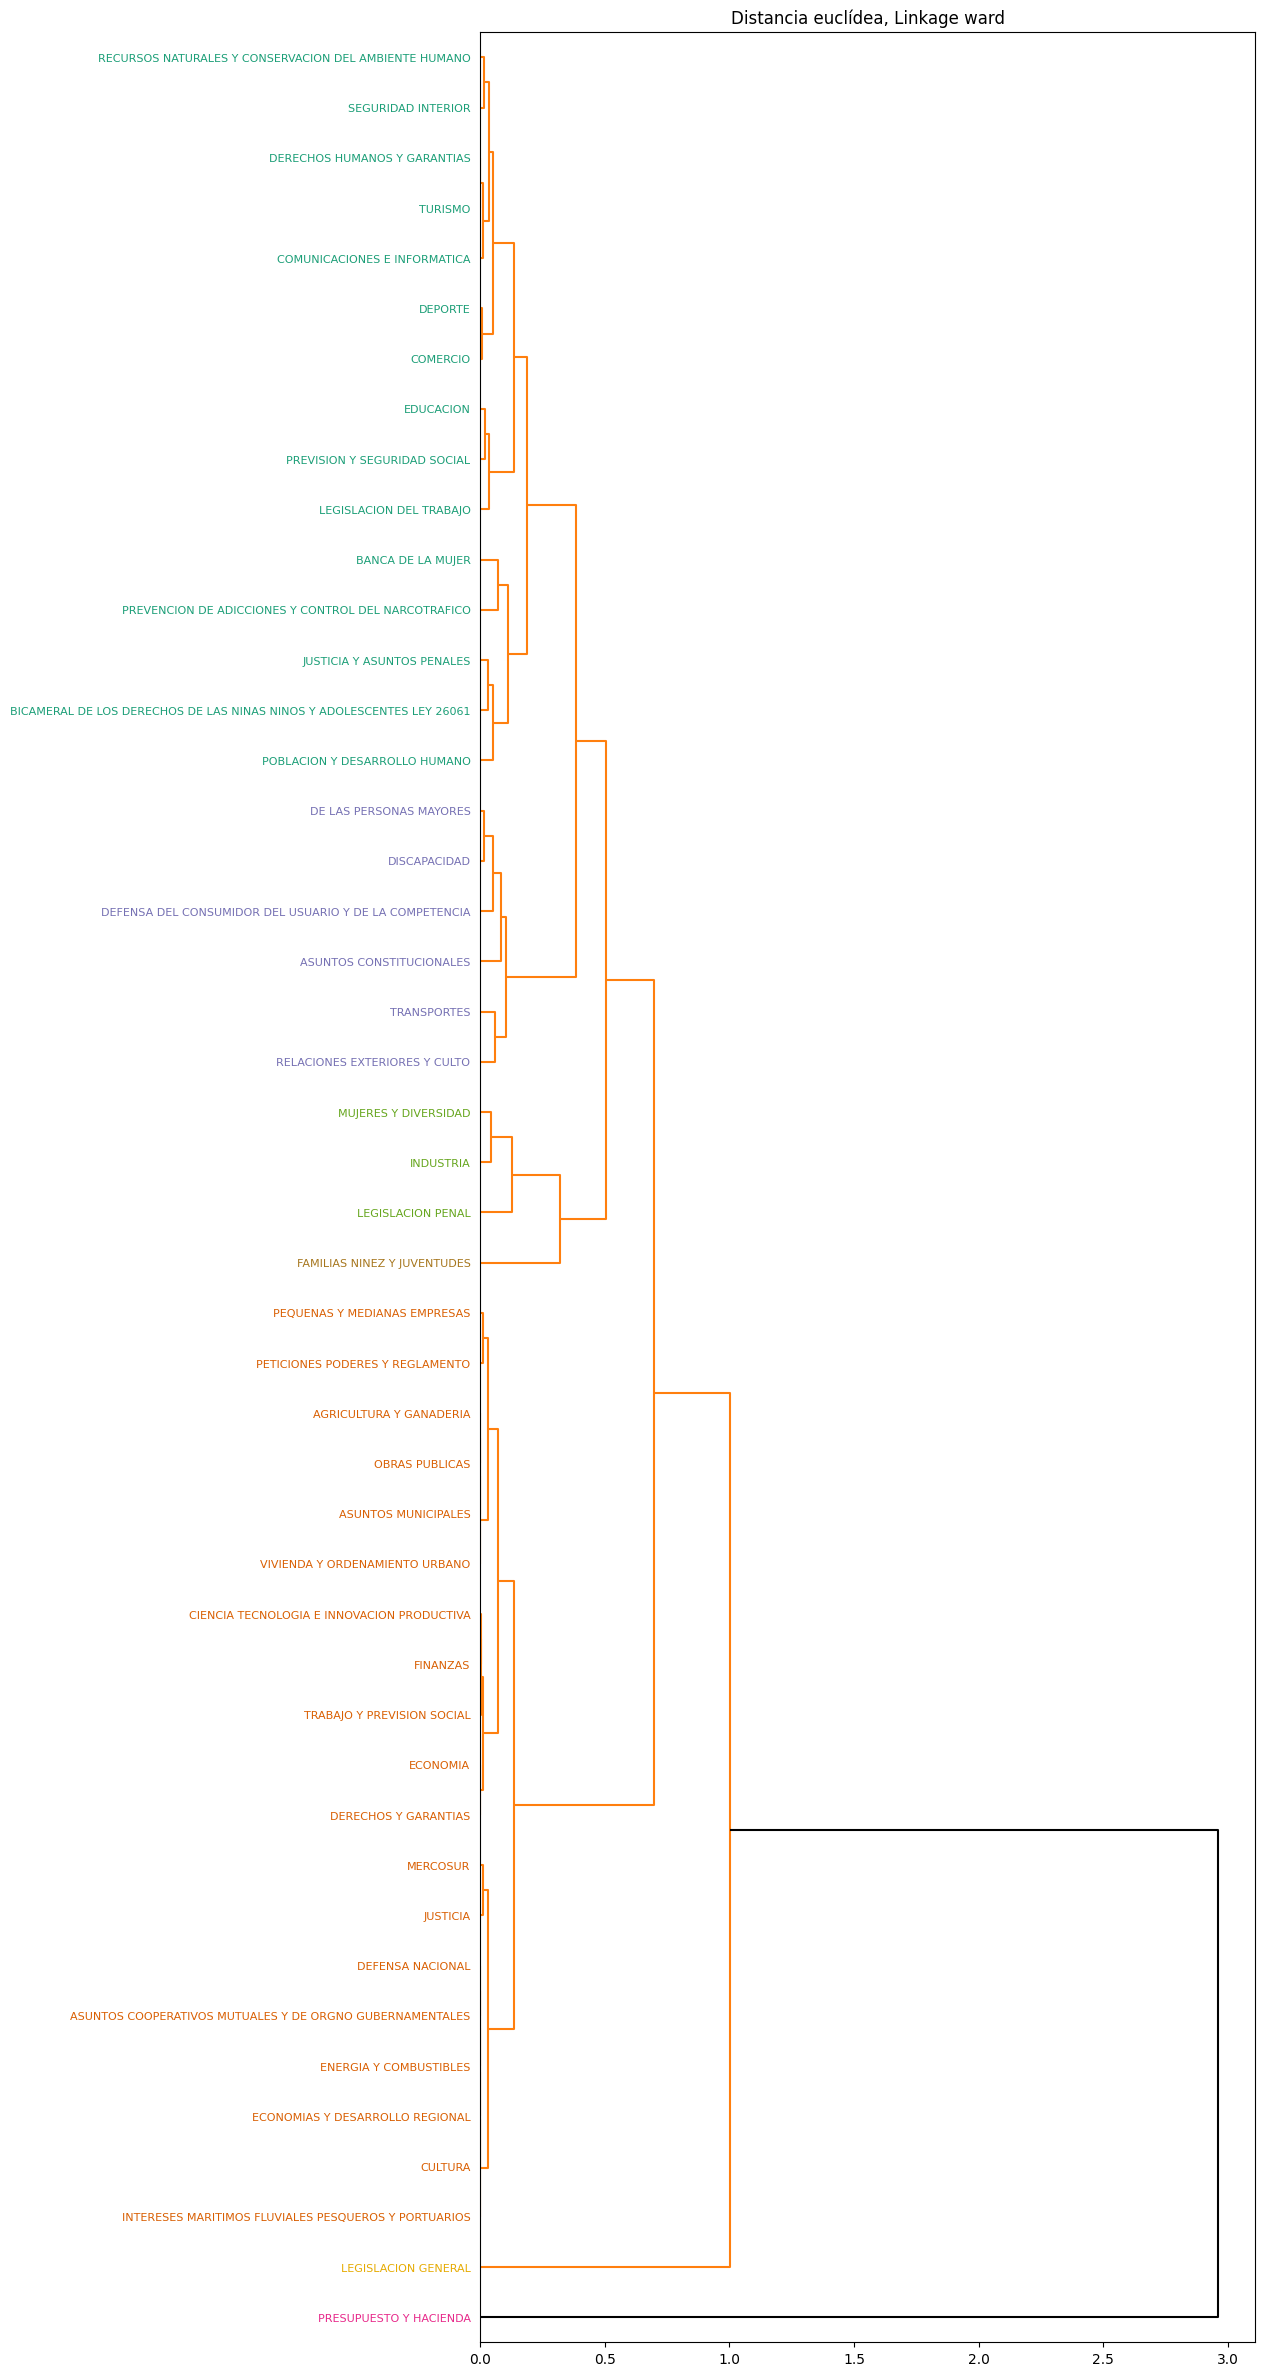

categ_agg_ward_k7
1    19
0    15
2     6
4     3
6     1
3     1
5     1
Name: count, dtype: int64

In [76]:
k = 7
model_p = get_cluster(all_s_x,k)
aggmodel_p_df =  pd.DataFrame(model_p.labels_ ,index = all_s_x.index).reset_index()
aggmodel_p_df.columns = ['comision_nombre_norm','categ_agg_ward_k'+str(k)]
display(aggmodel_p_df['categ_agg_ward_k'+str(k)].value_counts())

** Creación de grafo desde : (214, 4)
Número de nodos en el gráfo: 40
Número de aristas en el gráfo: 120
Densidad del grafo 0.15384615384615385
********** Métricas de Centralidad de la Red **********


count      mean        std       min       25%       50%  \
degree        40.0  4.632812  11.664062  0.445312  0.667969  1.335938   
centrality    40.0  0.153846   0.200052  0.025641  0.076923  0.102564   
eigenvector   40.0  0.063970   0.146437  0.006664  0.010105  0.020299   
pagerank      40.0  0.025000   0.054804  0.005554  0.007133  0.009419   
betweenness   40.0  0.063970   0.146437  0.006664  0.010105  0.020299   

                  75%        max  
degree       2.727539  61.906250  
centrality   0.128205   1.000000  
eigenvector  0.046669   0.691378  
pagerank     0.015698   0.295416  
betweenness  0.046669   0.691378

Nodos con mayor degree: ['ACCION SOCIAL Y SALUD PUBLICA', 'PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIAS NINEZ Y JUVENTUDES', 'INDUSTRIA', 'DEFENSA DEL CONSUMIDOR DEL USUARIO Y DE LA COMPETENCIA']
Nodos con mayor centrality: ['ACCION SOCIAL Y SALUD PUBLICA', 'PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIAS NINEZ Y JUVENTUDES', 'INDUSTRIA', 'LEGISLACION PENAL']
Nodos con mayor eigenvector: ['ACCION SOCIAL Y SALUD PUBLICA', 'PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIAS NINEZ Y JUVENTUDES', 'INDUSTRIA', 'MUJERES Y DIVERSIDAD']
Nodos con mayor pagerank: ['ACCION SOCIAL Y SALUD PUBLICA', 'PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIAS NINEZ Y JUVENTUDES', 'INDUSTRIA', 'DEFENSA DEL CONSUMIDOR DEL USUARIO Y DE LA COMPETENCIA']
Nodos con mayor betweenness: ['ACCION SOCIAL Y SALUD PUBLICA', 'PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'FAMILIAS NINEZ Y JUVENTUDES', 'INDUSTRIA', 'MUJERES Y DIVERSIDAD']
Nodos con mayor degree: ['PRESUPUESTO Y HACI

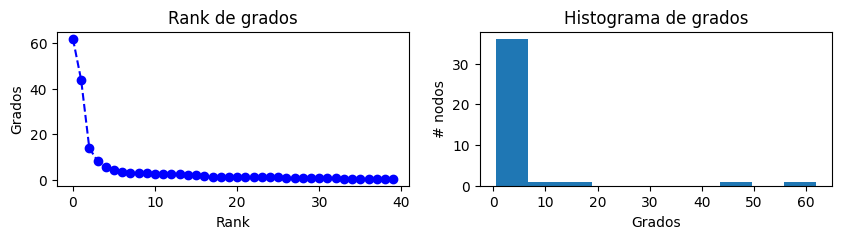

In [81]:
# SALUD 2020 LEY
grafo_20_LEY_dict = get_dict_grafo(edges_20_df[(edges_20_df['proyecto_id'].isin(t_list))])
for col in grafo_20_LEY_dict['centralidad'].columns:
    top_nodos = grafo_20_LEY_dict['centralidad'][~grafo_20_LEY_dict['centralidad'].index.isin(['ACCION SOCIAL Y SALUD PUBLICA', 'SALUD', 'SALUD Y DEPORTE'])][col].sort_values(ascending=False).head(6).index.to_list()
    print(f"Nodos con mayor {col}: {top_nodos}")


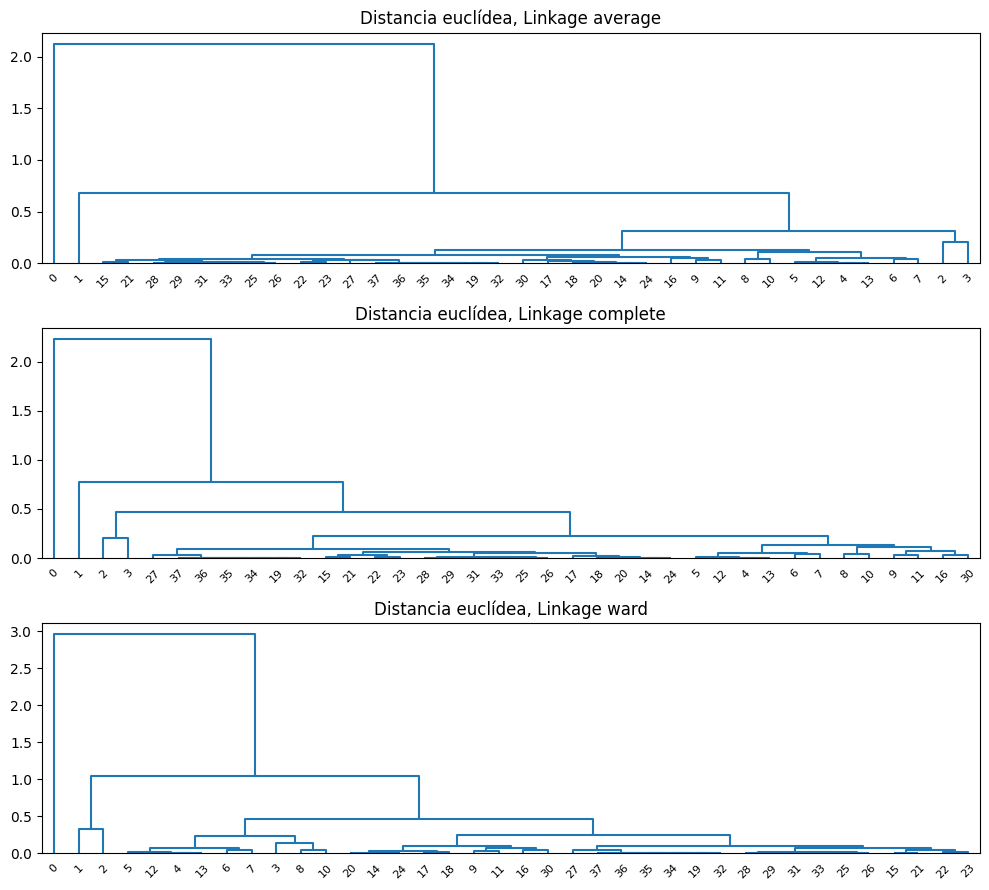

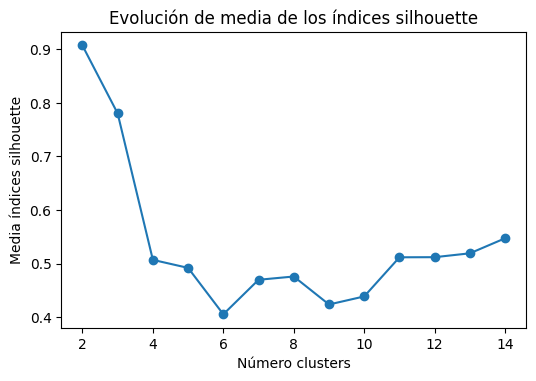

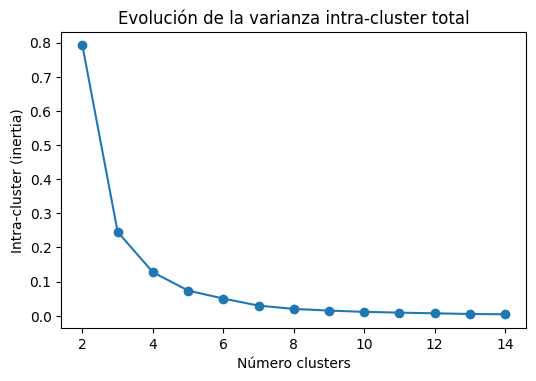

In [82]:
centralidad = grafo_20_LEY_dict['centralidad'] #[['degree','betweenness','pagerank']]
#centralidad[~centralidad.index.isin(['ACCION SOCIAL Y SALUD PUBLICA', 'SALUD', 'SALUD Y DEPORTE'])].index
all_s_l_x = encontrar_clusters(centralidad[~centralidad.index.isin(['ACCION SOCIAL Y SALUD PUBLICA', 'SALUD', 'SALUD Y DEPORTE'])])

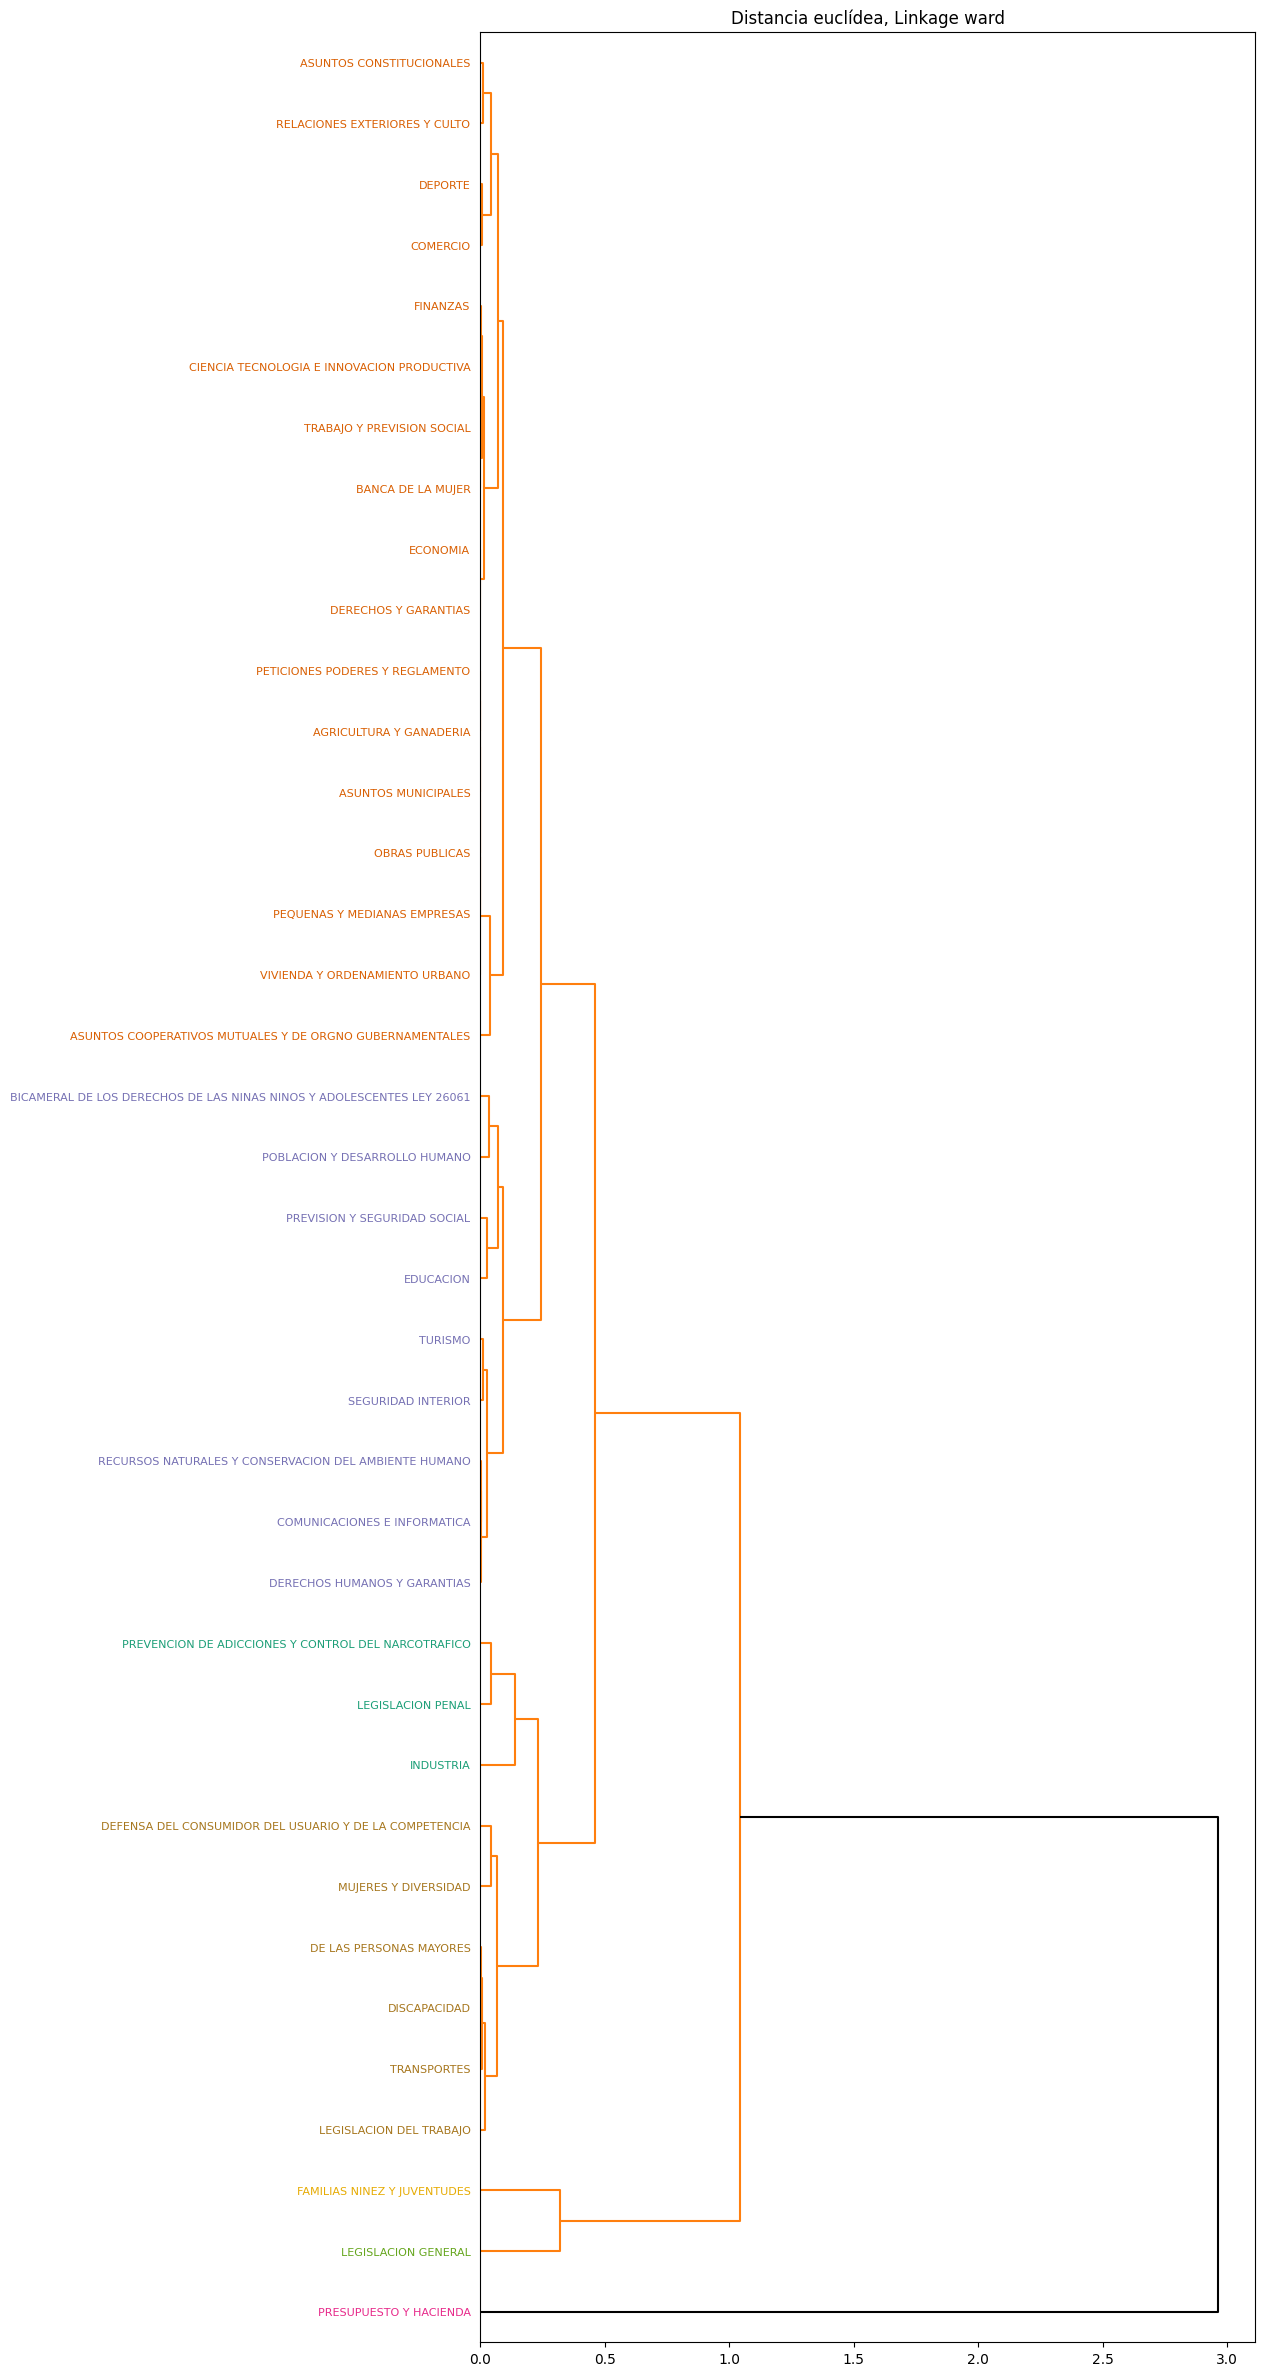

categ_agg_ward_k7
1    17
2     9
6     6
0     3
5     1
3     1
4     1
Name: count, dtype: int64

In [83]:
k = 7
model_p = get_cluster(all_s_l_x,k)
aggmodel_p_df =  pd.DataFrame(model_p.labels_ ,index = all_s_l_x.index).reset_index()
aggmodel_p_df.columns = ['comision_nombre_norm','categ_agg_ward_k'+str(k)]
display(aggmodel_p_df['categ_agg_ward_k'+str(k)].value_counts())

#### [2021-2023]

** Creación de grafo desde : (299, 4)
Número de nodos en el gráfo: 38
Número de aristas en el gráfo: 168
Densidad del grafo 0.23897581792318634
********** Métricas de Centralidad de la Red **********


count      mean       std       min       25%       50%  \
degree        38.0  2.929688  7.101562  0.053009  0.384338  0.901367   
centrality    38.0  0.238976  0.207791  0.027027  0.114865  0.175676   
eigenvector   38.0  0.073961  0.146318  0.002236  0.010214  0.022786   
pagerank      38.0  0.026316  0.055549  0.004308  0.006609  0.010443   
betweenness   38.0  0.073961  0.146318  0.002236  0.010214  0.022786   

                  75%        max  
degree       2.426270  39.437500  
centrality   0.297297   1.000000  
eigenvector  0.076664   0.680105  
pagerank     0.022937   0.315594  
betweenness  0.076664   0.680105

Nodos con mayor degree: ['ACCION SOCIAL Y SALUD PUBLICA', 'PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'EDUCACION', 'MUJERES Y DIVERSIDAD', 'FAMILIAS NINEZ Y JUVENTUDES']
Nodos con mayor centrality: ['ACCION SOCIAL Y SALUD PUBLICA', 'PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'LEGISLACION DEL TRABAJO', 'PREVENCION DE ADICCIONES Y CONTROL DEL NARCOTRAFICO', 'EDUCACION']
Nodos con mayor eigenvector: ['ACCION SOCIAL Y SALUD PUBLICA', 'PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'EDUCACION', 'MUJERES Y DIVERSIDAD', 'FAMILIAS NINEZ Y JUVENTUDES']
Nodos con mayor pagerank: ['ACCION SOCIAL Y SALUD PUBLICA', 'PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'EDUCACION', 'MUJERES Y DIVERSIDAD', 'FAMILIAS NINEZ Y JUVENTUDES']
Nodos con mayor betweenness: ['ACCION SOCIAL Y SALUD PUBLICA', 'PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'EDUCACION', 'MUJERES Y DIVERSIDAD', 'FAMILIAS NINEZ Y JUVENTUDES']
Nodos con mayor degree: ['PRESUPUESTO Y HACIENDA', 'LEGISLACION GENERAL', 'EDUCACI

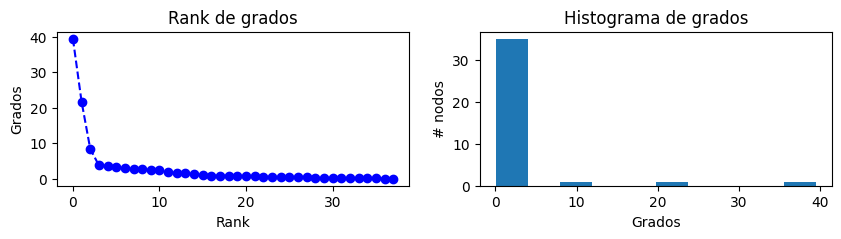

In [77]:
id_list = memoria_df.loc[(memoria_df['año']>2020) & (memoria_df['año']<2024) & (memoria_df['proyecto_girado_a_comisiones_SALUD']=='COMISIONES DE SALUD'),'proyecto_id'].unique()
edges_2123_df = edges_1023_df[(edges_1023_df['proyecto_id'].isin(id_list))]
grafo_2123_dict = get_dict_grafo(edges_2123_df)
for col in grafo_2123_dict['centralidad'].columns:
    top_nodos = grafo_2123_dict['centralidad'][~grafo_2123_dict['centralidad'].index.isin(['ACCION SOCIAL Y SALUD PUBLICA', 'SALUD', 'SALUD Y DEPORTE'])][col].sort_values(ascending=False).head(6).index.to_list()
    print(f"Nodos con mayor {col}: {top_nodos}")

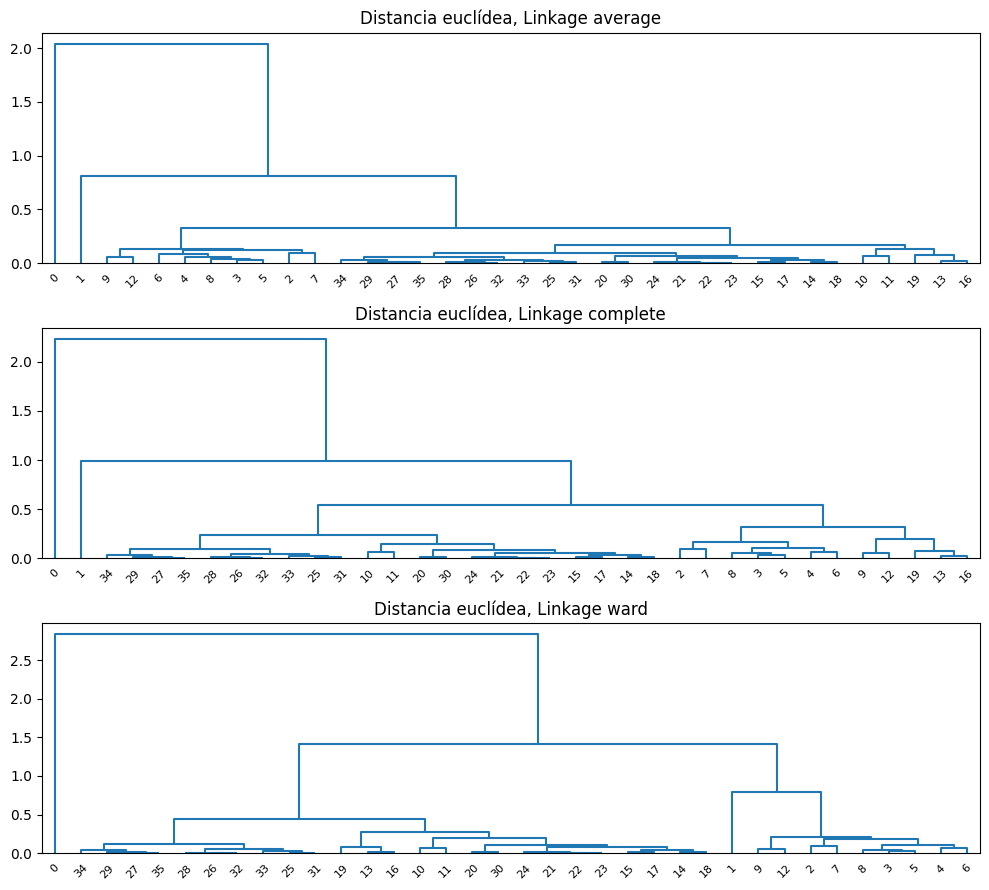

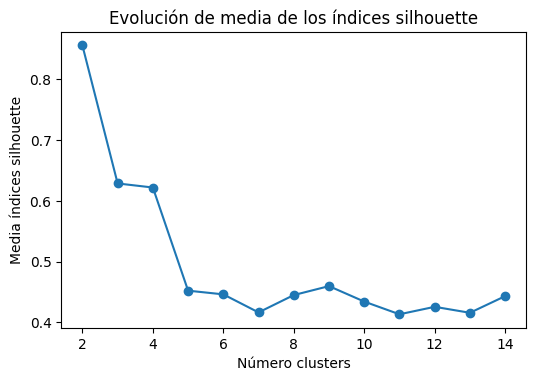

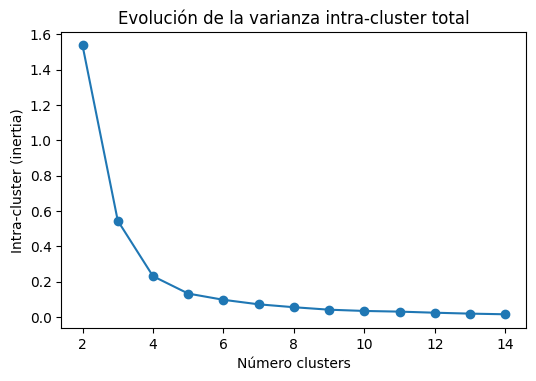

In [78]:
centralidad = grafo_2123_dict['centralidad'] #[['degree','betweenness','pagerank']]
#centralidad[~centralidad.index.isin(['ACCION SOCIAL Y SALUD PUBLICA', 'SALUD', 'SALUD Y DEPORTE'])].index
all_s_x = encontrar_clusters(centralidad[~centralidad.index.isin(['ACCION SOCIAL Y SALUD PUBLICA', 'SALUD', 'SALUD Y DEPORTE'])])

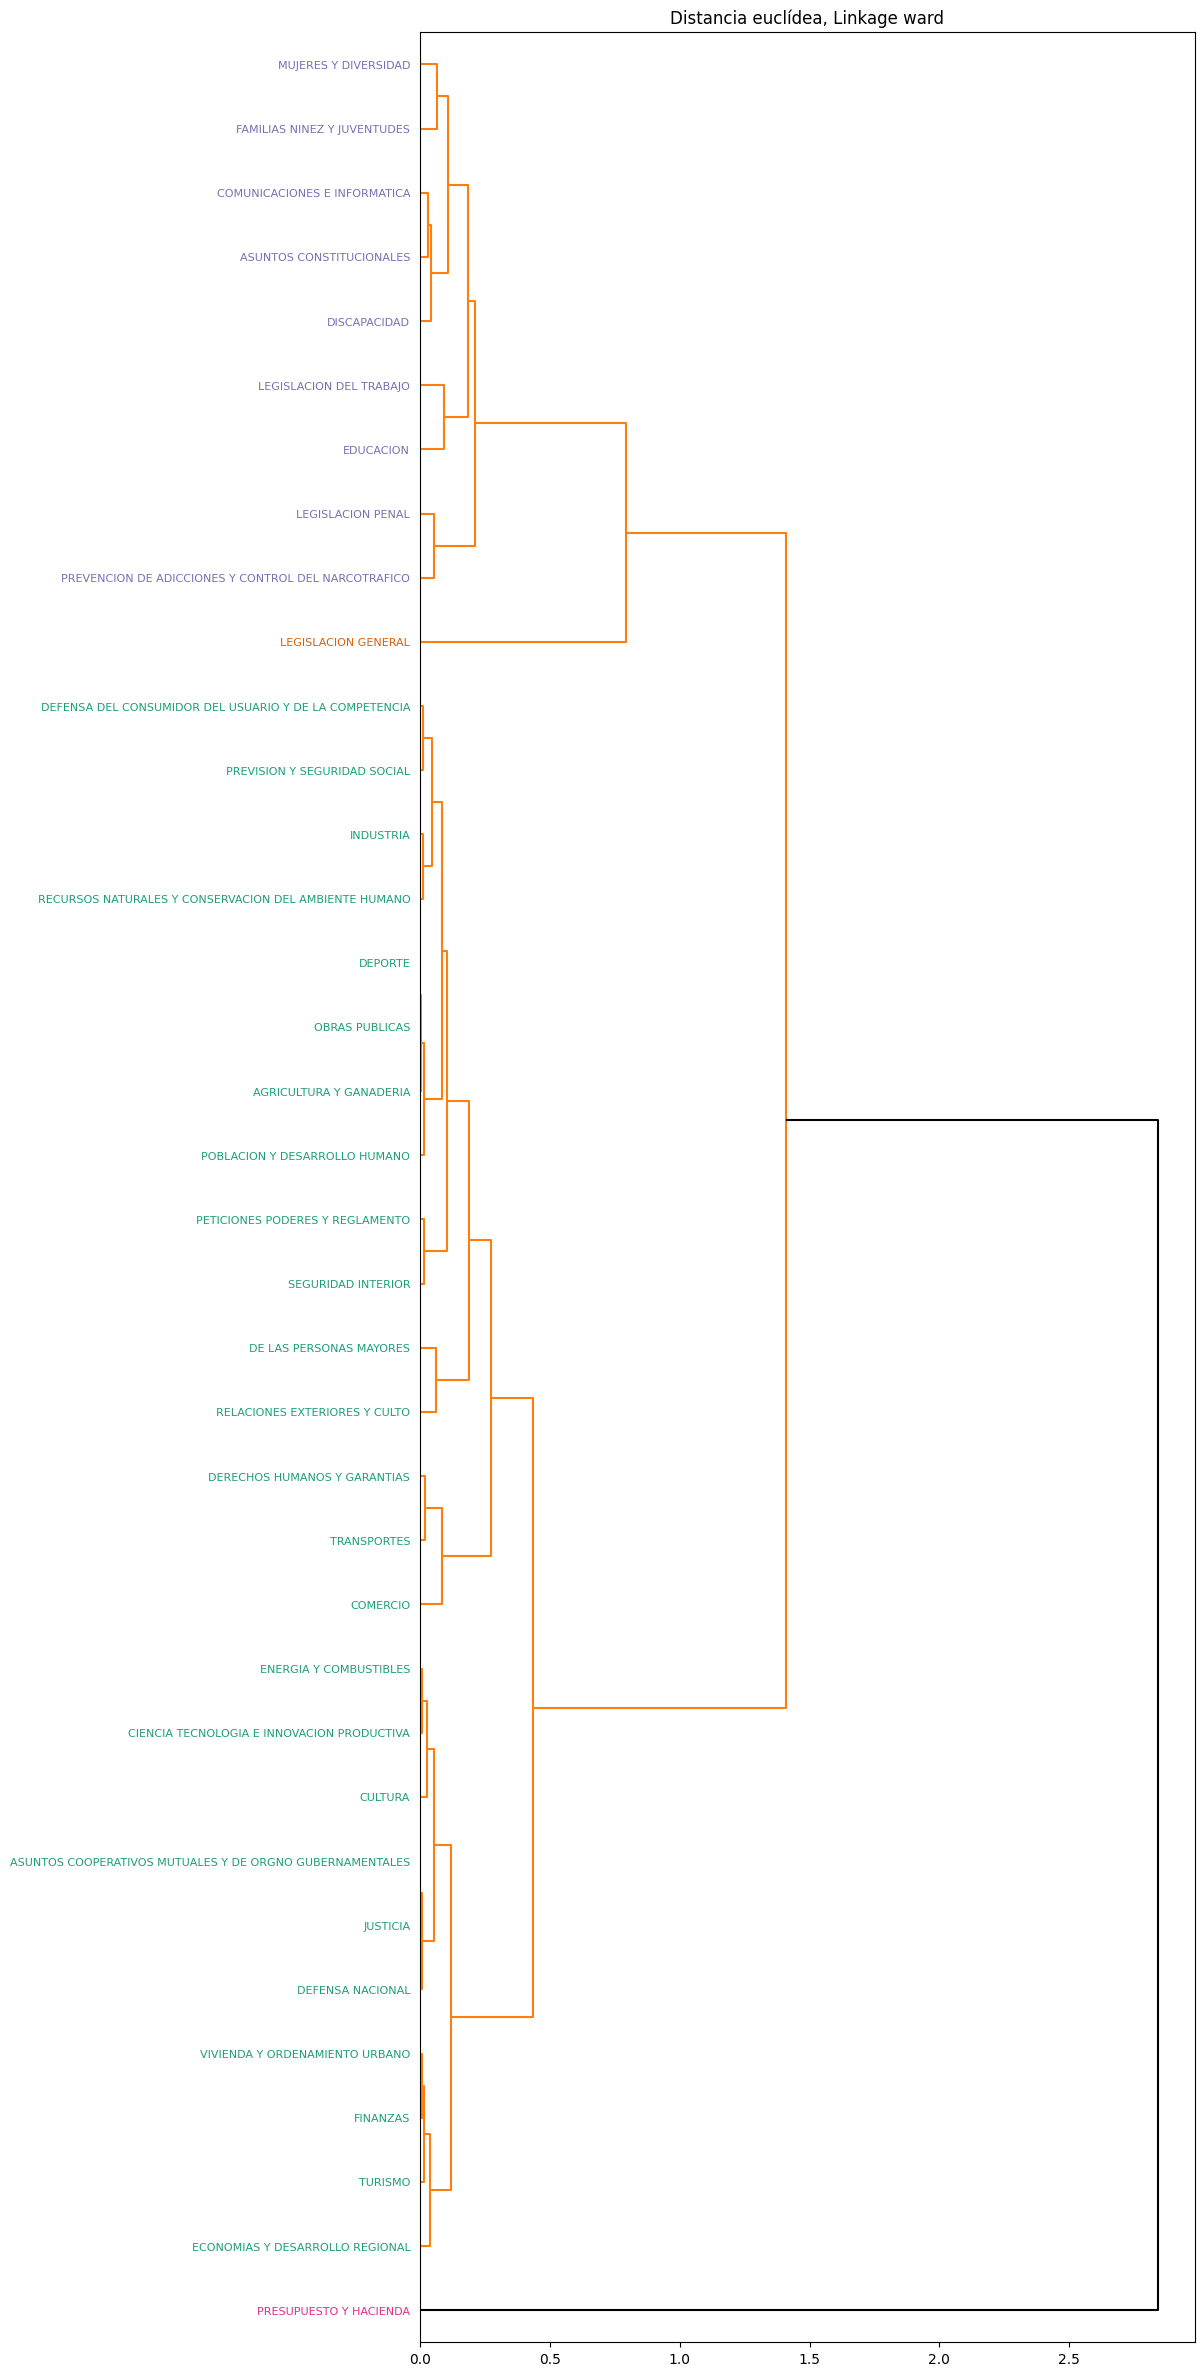

categ_agg_ward_k4
0    25
2     9
1     1
3     1
Name: count, dtype: int64

In [79]:
k = 4
model_p = get_cluster(all_s_x,k)
aggmodel_p_df =  pd.DataFrame(model_p.labels_ ,index = all_s_x.index).reset_index()
aggmodel_p_df.columns = ['comision_nombre_norm','categ_agg_ward_k'+str(k)]
display(aggmodel_p_df['categ_agg_ward_k'+str(k)].value_counts())